# From Wrights Generalized Bessel Function to Tweedie's Compound Poisson Distribution

**Table of Contents<a id="toc"></a>:**
- [1. Tweedie Distribution](#tweedie)
- [2. Wright's Generalized Bessel Function](#wright)
  - [2.1. Series Definition with Arbitrary Precision via MPMATH](#series_mpmath)
  - [2.2. Series Expansion with Finite Precision](#series)
  - [2.3. Taylor Series in rho - For small rho](#series_rho_small)
  - [2.4. Asymptotic Expansion](#asymptotic)
  - [2.4. Integral Representation](#integral)
  - [2.6. Taylor Series for large rho and large z](#series_rho_large)
  - [2.7. Check Precision on Data Grid](#grid)
- [3. Asymptotic Expansion](#asymptotic)

## 1. Tweedie Distribution <a id="tweedie"></a>
[back to TOC](#toc)

We start by plotting a few of the most commonly used Tweedie distributions.

In [1]:
import itertools

import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.special as ss
import scipy.stats as stats
import scipy.integrate as integrate

#plotting
import matplotlib.pyplot as plt
import seaborn as sns


plt.ion()
sns.set(style="whitegrid")

Calculate mean and variance of some distributions.

In [2]:
[
    stats.norm(loc=2, scale=1).stats("mv"),
    stats.gamma(a=4, scale=1/2).stats("mv"),
    stats.invgauss(mu=1/4, scale=8).stats("mv"),
]

[(2.0, 1.0), (2.0, 1.0), (2.0, 1.0)]

Text(0.5, 0.98, 'Common Tweedie Distributions: p=0, 1, 2, 3')

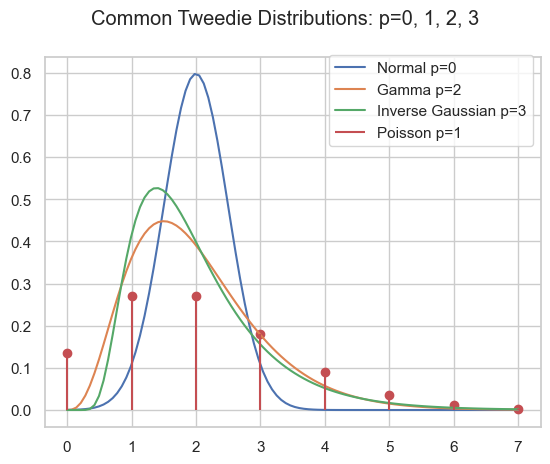

In [3]:
x = np.linspace(1e-10, 7, 100)
fig, ax = plt.subplots()
ax.plot(x, stats.norm(loc=2, scale=1/2).pdf(x), label="Normal p=0")
ax.plot(x, stats.gamma(a=4, scale=1/2).pdf(x), label="Gamma p=2")
ax.plot(x, stats.invgauss(mu=1/4, scale=8).pdf(x), label="Inverse Gaussian p=3")
x = np.arange(8)
ax.scatter(x, stats.poisson(mu=2).pmf(x), color="C3")
ax.vlines(x, 0, stats.poisson(mu=2).pmf(x), color="C3", label="Poisson p=1")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
fig.suptitle("Common Tweedie Distributions: p=0, 1, 2, 3")
# fig.savefig("tweedie.png")

Some special Tweedie distributions are the ones *between* Poisson and Gamma, i.e. $1<p<2$.
This gives a distribution with point mass at zero and otherwise a continuous density on the positive axis.
The PDF is given by:
$$f(y; \mu, \phi, p) = a(y, \phi, p) e^{\frac{y\theta - \kappa}{\phi}}$$
$$\theta = \frac{\mu^{1-p}}{1-p}$$
$$\kappa = \frac{\mu^{2-p}}{2-p}$$
$$a(y, \phi, p) = \frac{\Phi(-\alpha, 0, t)}{y}$$
$$\alpha = \frac{2 - p}{1 - p}$$
$$t = \frac{\left(\frac{(p - 1)\phi}{x}\right)^{\alpha}}{(2-p)\phi}$$
This depends on **Wright's (generalized Bessel) function** $\Phi(\rho, \beta, z)$.

In [4]:
def cpg_pmf(mu, phi, p):
    """Compound Poisson Gamma point mass at zero."""
    return np.exp(-np.power(mu, 2 - p) / (phi * (2 - p)))

def cpg_pdf(x, mu, phi, p):
    """Compound Poisson Gamma pdf."""
    if p == 1:
        theta = np.log(mu)
    else:
        theta = np.power(mu, 1 - p) / (1 - p)

    if p == 2:
        kappa = np.log(mu)
    else:
        kappa = np.power(mu, 2 - p) / (2 - p)

    alpha = (2 - p) / (1 - p)
    t = ((p - 1) * phi / x)**alpha
    t /= (2 - p) * phi
    a = 1 / x * ss.wright_bessel(-alpha, 0, t)
    return a * np.exp((x * theta - kappa) / phi)

To make sure that we got the formulas right by checking that the integral over the pdf plus point mass at zero gives one.

In [5]:
mu, phi, p = 2, 0.3, 1.5
integrate.quad(cpg_pdf, 1e-9, 30, args=(mu, phi, p))[0] + cpg_pmf(mu, phi, p)

0.9999999999964442

Text(0.5, 0.98, 'Tweedie Distributions mu=2')

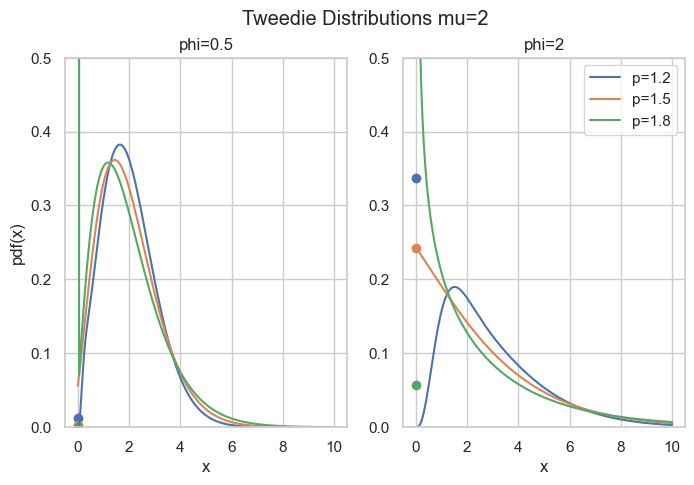

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=[6.4 * 1.25, 4.8])
x = np.linspace(1e-9, 10, 200)
mu = 2
for p in [1.2, 1.5, 1.8]:
    for i, phi in enumerate([0.5, 2]):
        axes[i].plot(x, cpg_pdf(x=x, mu=mu, phi=phi, p=p), label=f"{p=}")
        axes[i].scatter(0, cpg_pmf(mu=mu, phi=phi, p=p))
        axes[i].set_ylim(0, 0.5)
        axes[i].set_title(f"{phi=}")
        if i > 0:
            axes[i].legend()
        else:
            axes[i].set_ylabel("pdf(x)")
        axes[i].set_xlabel("x")
fig.suptitle("Tweedie Distributions mu=2")

## 2. Wright's Function <a id="wright"></a>
[back to TOC](#toc)

Wright's (generalized Bessel) function was introduced in a 1933 paper by E. Wright and is define, see also [DLMF 10.46](https://dlmf.nist.gov/10.46), as
$$\Phi(\rho, \beta, z) = \sum_{k=0}^{\infty} \frac{z^k}{k!\Gamma(\beta+\rho k)}, \quad \rho > -1, \beta \in R, z \in C$$

with [Gamma function](https://en.wikipedia.org/wiki/Gamma_function) $\Gamma(z)$.

**Properties**

$\Phi(\rho, \beta, z)$ is an [entire function](https://en.wikipedia.org/wiki/Entire_function).
For positive, real arguments, it is monotonically increasing with increasing $z$ and with decreasing $\rho$ and $\beta$.

It has the following derivatives
$$\frac{\partial^n}{\partial z^n} \Phi(\rho, \beta, z) = \Phi(\rho, \beta + n \rho, z)$$
and the following recurrence relation
$$\Phi(\rho, \beta-1, z) = \rho z \Phi(\rho, \beta + \rho, z) + (\beta-1) \Phi(\rho, \beta, z)$$

**Numeric Evaluation**
This function is very difficult to evaluate numerically.
We mostly restrict our analysis to non-negative real numbers.
For specific regions of the parameter space, difference evaluation strategies are more appropriate:
- Small $|z|$: Taylor series expansion as given by the definition.
- Small $|\rho|$: Taylor series in $\rho$ (Dunn & Smyth (2005)
- Large $\rho$: Taylor series expansion around the maximum term
- Large $Z = (\rho x)^{\frac{1}{1+\rho}}$: asymptotic expantion in $Z$
- General: integral representation

**References:**
- E. Maitland Wright (1933), "On the Coefficients of Power Series Having Exponential Singularities", J. Lond. Math. Soc. 8 (1933), 71-79, https://doi.org/10.1112/jlms/s1-8.1.71
- Rudolf GORENFLO, Yuri LUCHKO, Francesco MAINARDI (2997), "Analytical properties and applicationsof the Wright function", https://arxiv.org/pdf/math-ph/0701069.pdf
- R. Stankovic (1970) "On the function of E. M. Wright", Pub. L’Institut Mathématique 18(1970) 113–124. http://elib.mi.sanu.ac.rs/files/journals/publ/30/13.pdf

Numerical Evaluation:
- Y. F. Luchko (2008), "Algorithms for Evaluation of the Wright Function for the Real Arguments’ Values",<br>
  Fractional Calculus and Applied Analysis 11(1), https://eudml.org/doc/11309 or [direct link](http://sci-gems.math.bas.bg/jspui/bitstream/10525/1298/1/fcaa-vol11-num1-2008-57p-75p.pdf)

Asymptotic Expansion:
- E. M. Wright (1935), "The asymptotic expansion of the generalized Bessel",<br>
  function. Proc. London Math. Soc. (2) 38, pp. 257–270. https://doi.org/10.1112/plms/s2-38.1.257
- R. B. Paris (2017), The asymptotics of the generalised Bessel function,<br>
  Mathematica Aeterna, Vol. 7, 2017, no. 4, 381 - 406, https://arxiv.org/abs/1711.03006
- Smoothing of Stokes' discontinuity for the generalized Bessel function I, R. Wong and Y.-Q. Zhao, https://doi.org/10.1098/rspa.1999.0365
- Smoothing of Stokes's discontinuity for the generalized Bessel function. II, R. Wong and Y.-Q. Zhao, https://doi.org/10.1098/rspa.1999.0440
- Exponentially small expansions of the Wright function on the Stokes lines, R. B. Paris, [direct link](https://rke.abertay.ac.uk/ws/portalfiles/portal/8558833/Paris_ExponentiallySmallExpansionsOfTheWrightFunction_Author_2014.pdf)
- Asymptotic and structural properties of special cases of the Wright function arising in probability theory, Richard B. Paris, https://arxiv.org/pdf/1508.00863.pdf

For Tweedie:
- Dunn, P.K., Smyth, G.K. Series evaluation of Tweedie exponential dispersion model densities. Stat Comput 15, 267–280 (2005). https://doi.org/10.1007/s11222-005-4070-y
- Vinogradov, V., Paris, R.B. & Yanushkevichiene, O. New properties and representations for members of the power-variance family. I. Lith Math J 52, 444–461 (2012) doi:10.1007/s10986-012-9186-0, https://rke.abertay.ac.uk/files/8536176/Paris_NewPropertiesAndRepresentations_I_Author_2012.pdf
- Vinogradov, V., Paris, R.B. & Yanushkevichiene, O. New properties and representations for members of the power-variance family. II https://rke.abertay.ac.uk/ws/portalfiles/portal/8536555/Paris_NewPropertiesAndRepresentations_Author_2013.pdf


### 2.1. Taylor Series with Arbitrary Precision via mpmath <a id="series_mpmath"></a>
[back to TOC](#toc)
First of all, it is good to have some way to compute high precision results.
We accomplish this with the arbitrary floating point precition library mpmath and the Taylor series by computing enough terms.
This will be our reference to evaluate much faster methods.

In [7]:
from functools import lru_cache
import mpmath
import sympy
from sympy import Rational, S, symbols, gamma, digamma, polygamma, zeta, EulerGamma, pi, series
from sympy.printing.pycode import pycode


def rel_err(x1, x2):
    return float((x1 - x2)/x2)  # x1/x2 - 1

In [8]:
@lru_cache(maxsize=10_000)
def rgamma_cached(x, dps):
    with mpmath.workdps(dps):
        return mpmath.rgamma(x)

def Wright_Series_MPMATH(rho, beta, z, dps=20, method='r+s+e', **kwargs):
    """Compute Wright' generalized Bessel function as Series.
    
    This uses mpmath for arbitrary precision.
    """
    with mpmath.workdps(dps):
        res = mpmath.nsum(lambda k: z**k/mpmath.fac(k) * rgamma_cached(rho*k+beta, dps),
                          [0, mpmath.inf],
                          tol=dps, method=method, **kwargs
                          )
        res = sympy.Float(res)

    return res

In [9]:
Wright_Series_MPMATH(1, Rational(1, 2), 1, dps=20)

2.1225916201773919085

The larger $\rho$ or $\beta$ the smaller $\Phi$.
For $\rho, \beta, x \geq 0$:
$$\Phi(\rho,\beta, x) \leq \Phi(0, \beta, x) = \frac{\exp(x)}{\Gamma(\beta)}$$

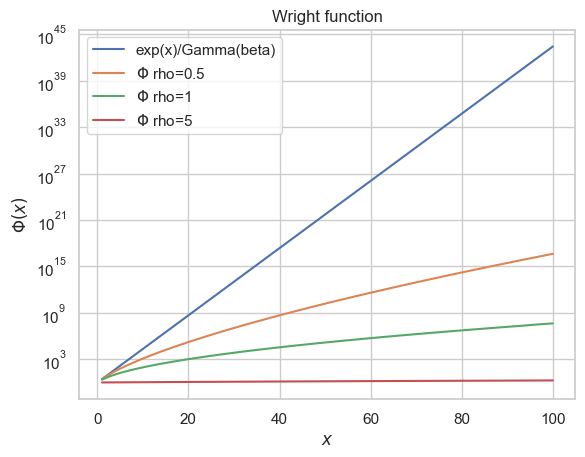

In [10]:
beta = 1
x = np.linspace(1, 100, num=100)
y = np.exp(x) * ss.rgamma(beta)
plt.plot(x, y, label='exp(x)/Gamma(beta)')

for rho in [0.5, 1, 5]:
    y = np.asarray([Wright_Series_MPMATH(rho, beta, z) for z in x])
    plt.plot(x, y, label=f'$\Phi$ rho={rho}')

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$\Phi(x)$')
plt.yscale('log')
plt.title('Wright function')
plt.show()

### 2.2 Tylor Series Expansion with Finite Precision <a id="series"></a>
[back to TOC](#toc)

In [11]:
def Wright_Series(rho, beta, z, nstart=0, nstop=100, tol=1e-20):
    # term k=nstart
    k = nstart
    zk_kk = np.power(z, k) * ss.rgamma(k+1)  # z^k/k!
    res = zk_kk * ss.rgamma(beta + rho*k)
    # term k=1,2,...
    for k in range(1, nstop):
        zk_kk *= z/float(k)
        rg = ss.rgamma(beta + rho*k)
        term = zk_kk * rg
        res += term
        # stop early
        if rg != 0 and term/res < tol:
            return res
        
    return res

In [12]:
# Compare simple examples
for rho, beta, z in [
    [Rational(1, 100), Rational(1, 10), 0.5],
    [Rational(1, 1000), Rational(1, 100), 1 - 1e-10],
    [Rational(1, 1000_000), Rational(1, 2), 1],
]:
    print()  # empty line
    x1 = Wright_Series_MPMATH(rho, beta, z, dps=50, verbose=True, steps=[100])
    x2 = Wright_Series(float(rho), float(beta), float(z), nstop=18, tol=0)
    print(f"{rho=}, {beta=}, {z=} Wright_Series_MPMATH={x1}")
    print(f"Relative error Wright_Series vs Wright_Series_MPMATH = {rel_err(x2, x1):.4e}")


----------------------------------------------------------------------
Adding terms #0-#100
Direct error: 1.76935e-186
rho=1/100, beta=1/10, z=0.5 Wright_Series_MPMATH=0.18238098764255952025993540799874756770882542146653
Relative error Wright_Series vs Wright_Series_MPMATH = -4.1536e-16

----------------------------------------------------------------------
Adding terms #0-#100
Direct error: 1.23229e-157
rho=1/1000, beta=1/100, z=0.9999999999 Wright_Series_MPMATH=0.030090087075305970407133141526014288648667841721763
Relative error Wright_Series vs Wright_Series_MPMATH = -8.6799e-17

----------------------------------------------------------------------
Adding terms #0-#100
Direct error: 6.04652e-157
rho=1/1000000, beta=1/2, z=1 Wright_Series_MPMATH=1.5336293040526887877418842520713751912516629005132
Relative error Wright_Series vs Wright_Series_MPMATH = -1.9335e-16


**MPMATH without steps argument** (`method='s'`) **would terminate early, after 10 summands.**
<br>
For $\rho,\beta \geq 0$ and $0\leq z \leq 1$, 20 terms seem to be sufficient. 

In [13]:
# Compare simple examples
for rho, beta, z in [
    [Rational(1, 100), 100, 1],
    [Rational(1, 1000), 100, 2],
]:
    print()  # empty line
    x1 = Wright_Series_MPMATH(rho, beta, z, dps=50, verbose=True, steps=[1000], method='s')
    x2 = Wright_Series(float(rho), float(beta), float(z), nstop=20, tol=0)
    print(f"{rho=}, {beta=}, {z=} Wright_Series_MPMATH={x1}")
    print(f"Relative error Wright_Series vs Wright_Series_MPMATH = {rel_err(x2, x1):.4e}")

rel_err(x2, x1)


----------------------------------------------------------------------
Adding terms #0-#1000
Direct error: 0.0
rho=1/100, beta=100, z=1 Wright_Series_MPMATH=2.7846121945040783629697798821081706253067994994632E-156
Relative error Wright_Series vs Wright_Series_MPMATH = -1.6634e-14

----------------------------------------------------------------------
Adding terms #0-#1000
Direct error: 0.0
rho=1/1000, beta=100, z=2 Wright_Series_MPMATH=7.8451061181728780948626797436807179201084664493801E-156
Relative error Wright_Series vs Wright_Series_MPMATH = -3.4209e-14


-3.420918547016962e-14

Special case $\rho=1$: Modified Bessel function of the first kind $J_\nu(t)$ of real order $\nu$
$$J_\nu(t) = \left(\frac{1}{2}t\right)^\nu \Phi(1, \nu + 1, -\frac{1}{4}t^2)$$
In Python:
<br>
`iv(v, z) = (1/2*z)**v * Phi(rho=1, beta=v+1, 1/4*z**2)`

By the way, this connection is **the reason for calling it generalized Bessel function**.

In [14]:
beta = 0
x = 10
v = beta - 1
x1 = mpmath.besseli(v, x)
x2 = ss.iv(v, x)
x3 = np.power(0.5*x, v) * Wright_Series(1, 1+v, 1/4*x**2)
print(f"{x=}, {v=} mpmath.besseli={x1}")
print(f"Relative error scipy.special.iv vs mpmath.besseli = {rel_err(x2, x1)}")
print(f"Relative error Bessel via Wright_Series vs mpmath.besseli = {rel_err(x3, x1)}")

x=10, v=-1 mpmath.besseli=2670.98830370125
Relative error scipy.special.iv vs mpmath.besseli = -1.7025434003447693e-16
Relative error Bessel via Wright_Series vs mpmath.besseli = 1.7025434003447693e-16


Cases with large z are difficult for a Taylor Series in z!

In [15]:
rho = 2
beta = 0.145
z = 1000

x1 = Wright_Series_MPMATH(rho, beta, z, dps=50, verbose=True, steps=[100])
x2 = Wright_Series(rho, beta, z, nstart=0, nstop=20, tol=0)

rel_err(x2, x1)

----------------------------------------------------------------------
Adding terms #0-#100
Direct error: 0.0


-1.3448955177431267e-13

In [16]:
rho = 1e-5
beta = 100
z = 1000

x1 = Wright_Series_MPMATH(rho, beta, z, dps=50, verbose=True, steps=[2000], method='s')
x2 = Wright_Series(rho, beta, z, nstart=0, nstop=20, tol=0)

float(x1), rel_err(x2 ,x1)

----------------------------------------------------------------------
Adding terms #0-#2000
Direct error: 5.89438e+108
Shanks error: 1.53676e+272


(2.016045087243279e+278, -1.0)

This shows that we need a different evaluation algorithm.

### 2.3. Taylor Series in rho - For small rho<a id="series_rho_small"></a>
[back to TOC](#toc)
$$\Phi(\rho, \beta, z) = \Phi(0, \beta, z)
    + \rho \frac{\partial}{\partial\rho}\Phi(\rho, \beta, z)\bigg|_{\rho=0}
    + \frac{\rho^2}{2} \frac{\partial^2}{\partial\rho^2}\Phi(\rho, \beta, z)\bigg|_{\rho=0} + O(\rho^3)$$
This gives:
$$\Phi(\rho, \beta, z) = \frac{e^z}{\Gamma(\beta)}
\left[1 - \rho \cdot z\cdot  \Psi(\beta) + \frac{\rho^2}{2}z(1+z)\left(\Psi(\beta)^2 - \Psi^\prime(\beta)\right)
-\frac{\rho^3}{6} z (z^2+3z+1) (\Psi(\beta)^3 - 3 \Psi(\beta) \Psi^\prime(\beta)) + \Psi^{\prime\prime}(\beta)\right]+ O(\rho^4)$$
with [Digamma function](https://en.wikipedia.org/wiki/Digamma_function) $\Psi(z)$.

Very importantly, one needs to take a care for small $\beta$ because ${\Gamma(\beta)}$ and $\Psi^{(n)}(\beta)$ have poles in $\beta = 0$.
One way is a proper series expression in $\beta=0$ by using the Laurent series of $\Psi$ which follows from:
$$\Psi(\beta+1) = \Psi(\beta)+\frac{1}{\beta}$$ and
$$\Psi(\beta+1) = -\gamma_E + \sum_{k=2}(-1)^k \zeta(k) \beta^{k-1}$$

#### 2.3.1 Expansion of $\Phi(\rho, \beta, z)$ in $\rho=0$
Here, we calculate the Series expansion analytically using [sympy](https://www.sympy.org).

In [17]:
rho, beta, z, k = symbols("rho beta z k")
expression = sympy.Sum(z**k/sympy.factorial(k)/gamma(rho * k + beta), (k, 0, S.Infinity))

In [18]:
# 1. term
expression.diff(rho, 1).subs(rho, 0).simplify().doit()

-z*exp(z)*polygamma(0, beta)/gamma(beta)

In [19]:
# 2. term
expression.diff(rho, 2).subs(rho, 0).simplify().doit()

z*(z + 1)*(polygamma(0, beta)**2 - polygamma(1, beta))*exp(z)/gamma(beta)

We could go on, but stop here.

As it would be nice to generate Python code, here is how.

In [20]:
# We devide by the common factor of exp(z)/Gamma(z).
print(pycode(
    gamma(beta)/sympy.exp(z)
    * expression.diff(rho, 2).subs(rho, 0).simplify().doit()
))

  # Not supported in Python:
  # polygamma
  # polygamma
z*(z + 1)*(polygamma(0, beta)**2 - polygamma(1, beta))


#### 2.3.2 Expansion of $\Phi(\rho, \beta, z)$ in $\rho=0$ and $\beta=0$

In [21]:
# Note that polygamma(2, 1) = -2*zeta(3)
tmp = sympy.expand_func(polygamma(2, 1) + 2 * zeta(3), deep=True)
tmp, tmp.n()

(0, 0)

Laurent series are a bit involved. To avoid a PoleError in sympy, we implement it ourselves.

In [22]:
def dg_series(z, n):
    """Laurent series expansion of digamma(z) up to order n"""
    return -1/z - EulerGamma + sympy.summation((-1)**k*sympy.zeta(k)*z**(k-1), (k, 2, n+1))

def pg_series(k, z, n):
    """Laurent series expansion of k-th polygamma up to order n"""
    return sympy.diff(dg_series(z, n+k), z, k)

In [23]:
dg_series(beta, n=3)

pi**4*beta**3/90 - beta**2*zeta(3) + pi**2*beta/6 - EulerGamma - 1/beta

In [24]:
pg_series(1, beta, n=1)

-2*beta*zeta(3) + pi**2/6 + beta**(-2)

In [25]:
# Check for small z
[
    rel_err(
        dg_series(z, n=n).evalf(subs={z: 1e-3}),
        digamma(1e-3)
    ) for n in range(4)
]

[1.6427875487905806e-06,
 -1.2002847594068997e-09,
 1.0806331064071415e-12,
 -1.043006292863358e-15]

In [26]:
# digamma / gamma up to beta^4
tmp = (dg_series(beta, n=10) / gamma(beta)).series(beta, 0, n=5).removeO()
tmp.subs(polygamma(2, 1), -2 * zeta(3)).simplify().collect(beta)

beta**4*(-5*EulerGamma*zeta(3)/3 - pi**4/288 - 5*EulerGamma**4/24 + 5*EulerGamma**2*pi**2/24) + beta**3*(-4*zeta(3)/3 - 2*EulerGamma**3/3 + EulerGamma*pi**2/3) + beta**2*(-3*EulerGamma**2/2 + pi**2/4) - 2*EulerGamma*beta - 1

In [27]:
# Check for small beta
rel_err(
    tmp.evalf(subs={beta: 1e-3}),
    (digamma(beta)/gamma(beta)).evalf(subs={beta: 1e-3}),
)

2.217890011901571e-16

In [28]:
# The 2. order term: (digamma(beta)**2 −polygamma(1, beta)) / gamma(beta)
tmp = (dg_series(beta, 6)**2 - sympy.diff(dg_series(beta, 7), beta)) / gamma(beta)
tmp = tmp.series(beta, 0, n=3).removeO()
tmp

beta**2*(-5*EulerGamma*pi**2/6 + 2*EulerGamma*(-pi**2/12 + EulerGamma**2/2) + EulerGamma**3 + 4*zeta(3)) + beta*(-pi**2/2 + 3*EulerGamma**2) + 2*EulerGamma

And so on ...

In [29]:
def Wright_small_rho(rho, beta, z, order=2):
    if beta <= 1e-3:
        M_EG = float(sympy.EulerGamma.evalf())
        M_PI = float(sympy.pi.evalf())
        M_Z3 = ss.zeta(3)
        M_Z5 = ss.zeta(5)
        # First term of expansion in beta at 0
        # digamma(z)/Gamma(z) = −1 − 2*EulerGamma*z
        #                       + z**2*(-3/2*EulerGamma**2 + pi**2/4) + O(z^3)
        # digamma(z)^2/Gamma(z) = 1/z + 3*EulerGamma
        #                       + z*(−5/12*PI^2+7/2*EulerGamma^2) + O(z^2)
        # polygamma(1, z)/Gamma(z) = 1/z + EulerGamma
        #                          + z*(1/12*PI^2 + 1/2*EulerGamma^2)+ O(z)
        C0 = 1
        C1 = 2*M_EG
        C2 = 3*M_EG**2 - M_PI**2/2
        C3 = 8*M_Z3 + 4*M_EG**3 - 2*M_EG*M_PI**2
        C4 = 40*M_EG*M_Z3 + 5*M_EG**4 - 5*M_EG**2*M_PI**2 + M_PI**4/12
        C5 = 144*M_Z5 + (120*M_EG**2 - 20*M_PI**2)*M_Z3 + 6*M_EG**5 - 10*M_EG**3*M_PI**2 + 1/2*M_EG*M_PI**4
        res = ss.rgamma(beta)
        res += rho*z*(C0 + C1*beta + C2*beta**2/2 + C3*beta**3/6 + C4*beta**4/24)
        res += rho**2/2*z*(1+z) * (C1 + C2*beta + C3*beta**2/2 + C4*beta**3/6)
        res += rho**3/6 * z*(z**2+3*z+1) * (C2 + C3*beta + C4*beta**2/2)
        res += rho**4/24 * z*(z**3+6*z**2+7*z+1) *(C3 + C4*beta)
        res += rho**5/120 * z*(z**4+10*z**3+25*z**2+15*z+1) * C4
        #res += rho**6/720 * z*(z**5 + 15*z**4 + 65*z**3 + 90*z**2 + 31*z + 1) * C5
        res *= np.exp(z)
    else:
        dg = ss.digamma(beta)
        pg1 = ss.polygamma(1, beta)
        if order <= 2:
            res = 1 + rho*z*(-dg + rho/2*(1+z)*(dg**2 - pg1))
        else:
            if order > 5:
                order = 5
            Z1 = z
            Z2 = z*(z + 1)
            Z3 = z*(z*(z + 3) + 1)
            Z4 = z*(z*(z*(z + 6) + 7) + 1)
            Z5 = z*(z*(z*(z*(z + 10) + 25) + 15) + 1)
            
            pg2 = ss.polygamma(2, beta)
            B0 = 1
            B1 = -dg
            B2 = dg**2 - pg1
            B3 = (-dg**2 + 3*pg1)*dg - pg2
            # polyval expects A[0] as coeff of highest order, A[-1] as constant term.
            A = np.zeros(order+1)
            A[order] = 1
            A[order-1] = Z1 * B1
            A[order-2] = Z2 * B2 / 2.
            A[order-3] = Z3 * B3 / 6.
            if order >= 4:
                pg3 = ss.polygamma(3, beta)
                B4 = ((dg**2 - 6*pg1)*dg + 4*pg2)*dg + 3*pg1**2 - pg3
                A[order-4] = Z4 * B4 / 24.
            if order >= 5:
                pg4 = ss.polygamma(4, beta)
                B5 = ((((-dg**2 + 10*pg1)*dg - 10*pg2)*dg - 15*pg1**2
                      + 5*pg3)*dg + 10*pg1*pg2 - pg4)
                A[order-5] = Z5 * B5 / 120.
            res = np.polyval(A, rho)
            
        res *= np.exp(z) * ss.rgamma(beta)
    return res

In [30]:
z = 8
rho = 1e-3
beta = 2e-3
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000], method='d', dpi=50)
for order in [3, 4, 5]:
    y2 = Wright_small_rho(rho, beta, z, order=order)
    print(f"order={order} accuracy = {rel_err(y2, y1)}")

order=3 accuracy = 2.9127683001963703e-08
order=4 accuracy = -1.439324771636689e-09
order=5 accuracy = 4.493976545669023e-12


Small beta

In [31]:
# values rho, beta, z
values = [[1e-3, 2e-3, 1],
          [1e-3, 1e-3, 1],
          [1e-3, 1e-4, 1],
          [1e-3, 1e-5, 1]]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method='d') for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=4) for rho, beta, z in values]
np.array(y2)/np.array(y1)-1
[rel_err(x1, x2) for x1, x2 in zip(y1, y2)]

[2.869572173879514e-12,
 -1.8473744127898688e-14,
 -8.970890919131457e-15,
 -8.25252519214719e-15]

In [32]:
# values rho, beta, z
values = [[1e-3, 1e-3, 8],
          [1e-4, 1e-3, 100],
          [1e-5, 1e-3, 700]]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method='d') for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=4) for rho, beta, z in values]
[rel_err(x1, x2) for x1, x2 in zip(y1, y2)]

[-8.056469787620134e-12, -7.641967340484247e-12, -1.4016114725682152e-12]

#### order = 2
rho=1e-3 and z<=1e-5 => 1e-11 precision

rho=1e-4 and z<=1e-2 => 1e-11 precision

rho=1e-5 and z<=1 => 1e-11 precision

In [33]:
# values rho, beta, z
values = [[1E-3, 2e-3, 1e-5],
          [1E-3, 2e-3, 1e-4],
          [1e-3, 2e-3, 1e-3],
          [1E-4, 2e-3, 1e-3],
          [1E-4, 2e-3, 1e-2],
          [1e-4, 2e-3, 1e-1],
          [1E-5, 2e-3, 1e-1],
          [1E-5, 2e-3, 1e+0],
          [1e-5, 2e-3, 1e+1],
         ]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method='r') for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=2) for rho, beta, z in values]
for i, [rho, beta, z] in enumerate(values):
    print(f"rho={rho:6} z={z:6} rel. error={rel_err(y2[i], y1[i])}")

rho= 0.001 z= 1e-05 rel. error=3.277460877977649e-12
rho= 0.001 z=0.0001 rel. error=3.278291483913837e-11
rho= 0.001 z= 0.001 rel. error=3.2856548861892493e-10
rho=0.0001 z= 0.001 rel. error=3.2893974182895953e-13
rho=0.0001 z=  0.01 rel. error=3.3741242059868164e-12
rho=0.0001 z=   0.1 rel. error=4.2718832164002354e-11
rho= 1e-05 z=   0.1 rel. error=4.29205086358911e-14
rho= 1e-05 z=   1.0 rel. error=1.6303656173787068e-12
rho= 1e-05 z=  10.0 rel. error=4.0885737922325697e-10


order 4: rho=1e-3 and z<=1 => 1e-11 precision

#### order = 3
rho=1e-3 and z<=1e-1 => 1e-11 precision

rho=1e-4 and z<=1 => 1e-11 precision

rho=1e-5 and z<=10 => 1e-11 precision

In [34]:
# values rho, beta, z
values = [[1E-3, 2e-3, 1e-2],
          [1E-3, 2e-3, 1e-1],
          [1e-3, 2e-3, 1e-0],
          [1E-4, 2e-3, 1e0],
          [1E-4, 2e-3, 1e1],
          [1e-4, 2e-3, 1e2],
          [1E-5, 2e-3, 1e1],
          [1E-5, 2e-3, 1e2],
          [1e-5, 2e-3, 709.7827128933840],
         ]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method='r') for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=3) for rho, beta, z in values]
for i, [rho, beta, z] in enumerate(values):
    print(f"rho={rho:6} z={z:6} rel. error={rel_err(y2[i], y1[i])}")

rho= 0.001 z=  0.01 rel. error=2.1360055233561207e-13
rho= 0.001 z=   0.1 rel. error=3.356731167830546e-12
rho= 0.001 z=   1.0 rel. error=1.9844359543260688e-10
rho=0.0001 z=   1.0 rel. error=2.865639421257646e-14
rho=0.0001 z=  10.0 rel. error=2.230519341122717e-11
rho=0.0001 z= 100.0 rel. error=3.390250857710632e-08
rho= 1e-05 z=  10.0 rel. error=3.4477207195072323e-15
rho= 1e-05 z= 100.0 rel. error=1.4177427536374886e-11
rho= 1e-05 z=709.782712893384 rel. error=1.0959241678744838e-08


#### order = 4
rho=1e-3 and z<=1 => 1e-11 precision

rho=1e-4 and z<=10 => 1e-11 precision

rho=1e-5 and z<=100 => 1e-11 precision

In [35]:
# values rho, beta, z
values = [[1E-3, 2e-3, 1e0],
          [1E-3, 2e-3, 1e1],
          [1e-3, 2e-3, 1e2],
          [1E-4, 2e-3, 1e0],
          [1E-4, 2e-3, 1e1],
          [1e-4, 2e-3, 1e2],
          [1E-5, 2e-3, 1e1],
          [1E-5, 2e-3, 1e2],
          [1e-5, 2e-3, 709.7827128933840],
         ]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method='r') for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=4) for rho, beta, z in values]
for i, [rho, beta, z] in enumerate(values):
    print(f"rho={rho:6} z={z:6} rel. error={rel_err(y2[i], y1[i])}")

rho= 0.001 z=   1.0 rel. error=-2.8695721738712792e-12
rho= 0.001 z=  10.0 rel. error=-3.0999049728296724e-09
rho= 0.001 z= 100.0 rel. error=-1.65867611697058e-05
rho=0.0001 z=   1.0 rel. error=-1.7821322420843256e-16
rho=0.0001 z=  10.0 rel. error=-1.248544177399762e-13
rho=0.0001 z= 100.0 rel. error=-1.5109579828225948e-09
rho= 1e-05 z=  10.0 rel. error=2.257587590884842e-16
rho= 1e-05 z= 100.0 rel. error=-6.087779743198712e-14
rho= 1e-05 z=709.782712893384 rel. error=-3.310798009077895e-10


#### order = 5
rho=1e-3 and z<=10 => 1e-11 precision

rho=1e-4 and z<=100 => 1e-11 precision

rho=1e-5 and z<=709. => 1e-11 precision

In [36]:
# values rho, beta, z
values = [[1E-3, 2e-3, 1e0],
          [1E-3, 2e-3, 1e1],
          [1e-3, 2e-3, 1e2],
          [1E-4, 2e-3, 1e1],
          [1E-4, 2e-3, 1e2],
          [1e-4, 2e-3, 709.7827128933840],
          [1E-5, 2e-3, 1e1],
          [1E-5, 2e-3, 1e2],
          [1e-5, 2e-3, 709.7827128933840],
         ]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method='r') for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=5) for rho, beta, z in values]
for i, [rho, beta, z] in enumerate(values):
    print(f"rho={rho:6} z={z:6} rel. error={rel_err(y2[i], y1[i])}")

rho= 0.001 z=   1.0 rel. error=2.8543002728067306e-15
rho= 0.001 z=  10.0 rel. error=1.1370932474205309e-11
rho= 0.001 z= 100.0 rel. error=4.6599564988755687e-07
rho=0.0001 z=  10.0 rel. error=3.0559263797028137e-16
rho=0.0001 z= 100.0 rel. error=4.048505138664529e-12
rho=0.0001 z=709.782712893384 rel. error=7.401359258191381e-08
rho= 1e-05 z=  10.0 rel. error=2.257587590884842e-16
rho= 1e-05 z= 100.0 rel. error=1.799405481649352e-16
rho= 1e-05 z=709.782712893384 rel. error=6.020782175912948e-13


### 2.3. Asymptotic Expansion <a id="asymptotic"></a>
[back to TOC](#toc)

Implementation according to Wright (1935), for $z=x > 0$, $\rho > 0$:
$$Z = (\rho x)^{\frac{1}{1+\rho}}$$
$$\Phi(\rho, \beta, x) \sim H(Z)$$
$$H(Z) = Z^{\frac{1}{2}-\beta} e^{\frac{1+\rho}{\rho}Z} \sum_{k=0} \frac{(-1)^k a_k}{Z^k}$$
$$a_0 = \frac{1}{\sqrt{2\pi(1+\rho)}}$$
See also R. B. Paris (2017) with different notation:
$$\bar{Z} = (1+\rho)(\rho^{-\rho}x)^{\frac{1}{1+\rho}} = \frac{1+\rho}{\rho} Z$$
$$\Phi(\rho, \beta, x) \sim \bar{Z}^{\frac{1}{2}-\beta} e^{\bar{Z}} \sum_{k=0} \frac{A_k}{\bar{Z}^k}$$
$$A_k = A_0 c_k$$
$$A_0 = \left(\frac{\rho}{1+\rho}\right)^{\frac{1}{2}-\beta} a_0$$
$$a_k = (-1)^k \cdot \left(\frac{1+\rho}{\rho}\right)^{\frac{1}{2}-\beta-k} \cdot A_k
= a_0 \cdot \left(-\frac{\rho}{1+\rho}\right)^{k} \cdot c_k$$
The coefficients $c_k$ are given in Paris (2017) up to $c_3$.

#### 2.3.1 Compute Coefficients of Asymptotic Expansion
We first need to analytically/symbolically calculate those coefficients for the asymptotic expansion.

In [37]:
v, m, rho, beta = symbols("v m rho beta")

class g(sympy.Function):
    nargs = 3

    @classmethod
    def eval(cls, n, rho, v):
        if not n >= 0:
            raise ValueError("must have n >= 0")
        
        if n == 0:
            return 1
        else:
            return g(n-1, rho,v) + sympy.gammasimp(gamma(rho+2+n)/gamma(rho+2)) \
                               / sympy.gammasimp(gamma(3+n)/gamma(3))*v**n

# Check for order n=3 in v, i.e. v**3
g(3, rho, v) - (1 + (rho+2)/S(3) * v \
                + ((rho+2)*(rho+3))/S(3*4) * v**2 \
                + ((rho+2)*(rho+3)*(rho+4))/S(3*4*5) * v**3)

0

In [38]:
class a(sympy.Function):
    nargs = 3
    
    @classmethod
    def eval(cls, m, rho, beta):
        if not m >= 0:
            raise ValueError("must have m >= 0")
        
        v = symbols("v")
        expression = (1-v)**(-beta) * g(2*m, rho, v)**(-m-Rational(1, 2))
        res = expression.diff(v, 2*m).subs(v, 0)/sympy.factorial(2*m)
        res = res * (gamma(m + Rational(1, 2)) / (2*pi) * (2/(rho+1))**(m + Rational(1, 2)))
        return res

In [39]:
a0 = a(0, rho, beta)
a0

sqrt(2)*sqrt(1/(rho + 1))/(2*sqrt(pi))

In [40]:
a1 = a(1, rho, beta)
a1

sqrt(2)*(beta*(beta + 1)/2 - beta*(2*rho + 4)/4 - (rho + 2)*(rho + 3)/8 + 5*(2*rho + 4)**2/96)*(1/(rho + 1))**(3/2)/(2*sqrt(pi))

In [41]:
# Check Python fomula against symbolic a1
(a1/( a0 / (24*(rho+1))) - ((2*rho+1)*(2+rho)-12*beta*(1+rho-beta))).simplify()

0

In [42]:
a2 = a(2, rho, beta)
a2

3*sqrt(2)*(-beta*(beta + 1)*(30*(rho + 2)*(rho + 3) - 7*(60*rho + 120)**2/360)/288 - beta*(60*rho + 120)*(beta**2 + 3*beta + 2)/432 - beta*(6*(rho + 2)*(rho + 3)*(rho + 4) - 7*(rho + 2)*(rho + 3)*(60*rho + 120)/12 + 7*(60*rho + 120)**3/43200)/144 + beta*(beta**3 + 6*beta**2 + 11*beta + 6)/24 + 35*(rho + 2)**2*(rho + 3)**2/1152 - (rho + 2)*(rho + 3)*(rho + 4)*(rho + 5)/144 + 7*(rho + 2)*(rho + 3)*(rho + 4)*(60*rho + 120)/8640 - 7*(rho + 2)*(rho + 3)*(60*rho + 120)**2/138240 + 77*(60*rho + 120)**4/8957952000)*(1/(rho + 1))**(5/2)/(2*sqrt(pi))

And so on...

Note that the calculation of those coefficients of the asymptotic series gets time consuming.
`a(3, rho, beta)` already needs some seconds, `a(5, rho, beta)` around a minute, `a(7, rho, beta)` around 1h.

In [43]:
%%time
a3 = a(3, rho, beta)
a3

CPU times: user 2.19 s, sys: 6.44 ms, total: 2.2 s
Wall time: 2.2 s


15*sqrt(2)*(beta*(beta + 1)*(1260*(rho + 2)**2*(rho + 3)**2 - 224*(rho + 2)*(rho + 3)*(rho + 4)*(rho + 5) + 3*(rho + 2)*(rho + 3)*(rho + 4)*(3360*rho + 6720)/5 - 11*(rho + 2)*(rho + 3)*(3360*rho + 6720)**2/13440 + 143*(3360*rho + 6720)**4/2731180032000)/46080 - beta*(3360*rho + 6720)*(beta**4 + 10*beta**3 + 35*beta**2 + 50*beta + 24)/345600 - beta*(1680*(rho + 2)*(rho + 3) - (3360*rho + 6720)**2/2240)*(beta**3 + 6*beta**2 + 11*beta + 6)/138240 - beta*(beta**2 + 3*beta + 2)*(336*(rho + 2)*(rho + 3)*(rho + 4) - 3*(rho + 2)*(rho + 3)*(3360*rho + 6720)/4 + 11*(3360*rho + 6720)**3/135475200)/34560 + beta*(beta**5 + 15*beta**4 + 85*beta**3 + 225*beta**2 + 274*beta + 120)/720 - beta*(-504*(rho + 2)**2*(rho + 3)**2*(rho + 4) + 11*(rho + 2)**2*(rho + 3)**2*(3360*rho + 6720)/16 + 32*(rho + 2)*(rho + 3)*(rho + 4)*(rho + 5)*(rho + 6) - (rho + 2)*(rho + 3)*(rho + 4)*(rho + 5)*(3360*rho + 6720)/10 + 11*(rho + 2)*(rho + 3)*(rho + 4)*(3360*rho + 6720)**2/67200 - 143*(rho + 2)*(rho + 3)*(3360*rho + 672

In [44]:
pycode((a3 / (a0 / (414720*(rho+1)**3))).simplify().collect(beta, sympy.factor))

'8640*beta**6 - 8640*beta**5*(7*rho - 1) + 10800*beta**4*(14*rho**2 - 7*rho - 2) - 1440*beta**3*(112*rho**3 - 147*rho**2 - 63*rho + 8) + 180*beta**2*(364*rho**4 - 1288*rho**3 - 567*rho**2 + 392*rho + 76) - 180*beta*(rho + 1)*(20*rho**4 - 516*rho**3 + 417*rho**2 + 172*rho - 12) - (rho + 2)*(2*rho + 1)*(556*rho**4 + 1628*rho**3 - 9093*rho**2 + 1628*rho + 556)'

Note that the leading term in $\beta$ for the coefficient $a_k$ is given by $\frac{\beta^{2k}}{2^k k! (\rho + 1)^k}$.
So for $k=3$ this is $\frac{\beta^{6}}{48 (\rho + 1)^3}$.
Compare this with the expression for a3 above, which has $\frac{8640}{414720} = \frac{1}{48}$.

#### 2.3.2 Implementation of Asymptotic Expansion

In [45]:
# as in Wright (1935)
def H(Z, rho, beta, order=4, verbose=False):
    a0 = 1./np.sqrt(2. * np.pi * (rho+1))
    
    a1 = a0 / (24 * (rho+1))
    a1 *= (2*rho+1)*(2+rho)-12*beta*(1+rho-beta)
    
    a2 = a0 / (1152 * (rho+1)**2)
    a2 *= ((2+rho)*(1+2*rho)*(2-19*rho+2*rho**2) \
          + 24*beta*(1+rho)*(2+7*rho-6*rho**2) \
          - 24*beta**2*(4-5*rho-20*rho**2)-96*beta**3*(1+5*rho)+144*beta**4)
    
    a3 = a0 / (414720*(rho+1)**3)
    a3 *= 8640*beta**6 - 8640*beta**5*(7*rho - 1) + 10800*beta**4*(14*rho**2 - 7*rho - 2) \
        - 1440*beta**3*(112*rho**3 - 147*rho**2 - 63*rho + 8) \
        + 180*beta**2*(364*rho**4 - 1288*rho**3 - 567*rho**2 + 392*rho + 76) \
        - 180*beta*(rho+1)*(20*rho**4 - 516*rho**3 + 417*rho**2 + 172*rho - 12) \
        - (rho + 2)*(2*rho + 1)*(556*rho**4 + 1628*rho**3 - 9093*rho**2 + 1628*rho + 556)
    
    a4 = a0 / (39813120*(rho+1)**4)
    a4 *= 103680*beta**8 - 414720*beta**7*(3*rho - 1) + 725760*beta**6*rho*(8*rho - 7) \
        - 48384*beta**5*(274*rho**3 - 489*rho**2 + 39*rho + 26) \
        + 30240*beta**4*(500*rho**4 - 1740*rho**3 + 495*rho**2 + 340*rho - 12) \
        - 2880*beta**3*(2588*rho**5 - 19780*rho**4 + 14453*rho**3 + 9697*rho**2 - 1892*rho - 404) \
        + 48*beta**2*(11488*rho**6 - 547836*rho**5 + 1007484*rho**4 + 593353*rho**3 - 411276*rho**2 \
                      - 114396*rho + 4288) \
        + 48*beta*(rho + 1)*(7784*rho**6 + 48180*rho**5 - 491202*rho**4 + 336347*rho**3 \
                             + 163734*rho**2 - 28908*rho - 5560) \
        - (rho + 2)*(2*rho + 1)*(4568*rho**6 - 226668*rho**5 - 465702*rho**4 + 2013479*rho**3 \
                                 - 465702*rho**2 - 226668*rho + 4568)
    
    a5 = a0 / (6688604160.*(rho+1)**5)
    a5 *= 1741824*beta**10 - 2903040*beta**9*(11*rho - 5) + 2177280*beta**8*(110*rho**2 - 121*rho + 14) \
        - 580608*beta**7*(1628*rho**3 - 3333*rho**2 + 1023*rho + 52) \
        + 169344*beta**6*(12364*rho**4 - 43648*rho**3 + 26763*rho**2 + 1232*rho - 788) \
        - 24192*beta**5*(104852*rho**5 - 646624*rho**4 + 721391*rho**3 - 16841*rho**2 - 74096*rho + 148) \
        + 2016*beta**4*(710248*rho**6 - 8878716*rho**5 + 17928834*rho**4 - 3333407*rho**3 \
                        - 4339566*rho**2 + 287364*rho + 89128) \
        - 1344*beta**3*(87824*rho**7 - 7150220*rho**6 + 29202756*rho**5 - 15113527*rho**4 \
                        - 14223011*rho**3 + 3462492*rho**2 + 1137092*rho - 18896) \
        - 84*beta**2*(1690480*rho**8 + 14139136*rho**7 - 232575464*rho**6 + 296712592*rho**5 \
                      + 215856619*rho**4 - 152181392*rho**3 - 47718440*rho**2 + 5813632*rho + 943216) \
        + 84*beta*(rho + 1)*(82224*rho**8 - 5628896*rho**7 - 26466520*rho**6 + 168779208*rho**5 \
                             - 104808005*rho**4 - 56259736*rho**3 + 15879912*rho**2 + 4020640*rho - 63952) \
        + (rho + 2)*(2*rho + 1)*(2622064*rho**8 + 12598624*rho**7 - 167685080*rho**6 - 302008904*rho**5 \
                                 + 1115235367*rho**4 - 302008904*rho**3 - 167685080*rho**2 + 12598624*rho + 2622064)
    
    a6 = a0 / (4815794995200.*(rho+1)**6)
    a6 *= 104509440*beta**12 - 209018880*beta**11*(13*rho - 7) \
        + 574801920*beta**10*(52*rho**2 - 65*rho + 12) \
        - 63866880*beta**9*(2834*rho**3 - 6279*rho**2 + 2769*rho - 134) \
        + 23950080*beta**8*(27404*rho**4 - 98228*rho**3 + 78663*rho**2 - 10868*rho - 1012) \
        - 13685760*beta**7*(105612*rho**5 - 599196*rho**4 + 791843*rho**3 - 224913*rho**2 - 27612*rho + 4540) \
        + 2661120*beta**6*(693680*rho**6 - 6473532*rho**5 + 13736424*rho**4 - 7047469*rho**3 \
                           - 723840*rho**2 + 471588*rho + 7376) \
        - 2661120*beta**5*(432536*rho**7 - 7850804*rho**6 + 27531114*rho**5 - 24234457*rho**4 \
                           - 703001*rho**3 + 3633474*rho**2 - 36244*rho - 45128) \
        + 166320*beta**4*(548912*rho**8 - 75660832*rho**7 + 502902712*rho**6 - 764807992*rho**5 \
                          + 91248287*rho**4 + 217811464*rho**3 - 20365384*rho**2 - 9776416*rho + 37936) \
        + 10080*beta**3*(18759728*rho**9 + 165932208*rho**8 - 4710418440.*rho**7 + 13686052536.*rho**6 \
                         - 5456818809.*rho**5 - 6834514245.*rho**4 + 1919299512*rho**3 + 752176152*rho**2 \
                         - 45661200*rho - 8616848) \
        - 360*beta**2*(32743360*rho**10 - 3381871792.*rho**9 - 21488827776.*rho**8 + 200389923864.*rho**7 \
                       - 198708005340.*rho**6 - 171633799779.*rho**5 + 123124874028.*rho**4 \
                       + 40072774872.*rho**3 - 9137993280.*rho**2 - 1895843248*rho + 18929728) \
        - 360*beta*(rho + 1)*(57685408*rho**10 + 406929456*rho**9 - 6125375760.*rho**8 \
                              - 27094918920.*rho**7 + 128752249410.*rho**6 - 74866710561.*rho**5 \
                              - 42917416470.*rho**4 + 16256951352.*rho**3 + 4375268400.*rho**2 \
                              - 316500688*rho - 47197152) \
        + (rho + 2)*(2*rho + 1)*(167898208*rho**10 - 22774946512.*rho**9 - 88280004528.*rho**8 \
                                 + 611863976472.*rho**7 + 1041430242126.*rho**6 - 3446851131657.*rho**5 \
                                 + 1041430242126.*rho**4 + 611863976472.*rho**3 - 88280004528.*rho**2 \
                                 - 22774946512.*rho + 167898208)
    
    a7 = a0 / (115579079884800.*(rho+1)**7)
    a7 *= (179159040*beta**14 - 1254113280*beta**13*(5*rho - 3) + 1358622720*beta**12*(70*rho**2 - 95*rho + 22)
           - 905748480*beta**11*(904*rho**3 - 2109*rho**2 + 1119*rho - 112) 
           + 1245404160*beta**10*(3532*rho**4 - 12824*rho**3 + 11829*rho**2 - 2824*rho + 44)
           - 59304960*beta**9*(256820*rho**5 - 1397680*rho**4 + 2025545*rho**3 - 869495*rho**2 + 52000*rho + 8788)
           + 14826240*beta**8*(2274536*rho**6 - 18601572*rho**5 + 40698318*rho**4 - 28230079*rho**3 + 3916398*rho**2
                               + 832668*rho - 65176)
           - 59304960*beta**7*(760224*rho**7 - 9849164*rho**6 + 32495784*rho**5 - 34813869*rho**4 + 9175207*rho**3
                               + 1898688*rho**2 - 469788*rho - 13184)
           + 25945920*beta**6*(1167504*rho**8 - 28779840*rho**7 + 149752856*rho**6 - 246026112*rho**5
                               + 111944073*rho**4 + 18341600*rho**3 - 12131496*rho**2 - 274368*rho + 102800)
           - 157248*beta**5*(12341872*rho**9 - 3122991216*rho**8 + 29900054232*rho**7 - 78024816720*rho**6
                             + 58914656739*rho**5 + 4637150811*rho**4 - 11523402480*rho**3 + 236218968*rho**2
                             + 337923216*rho + 1592048)
           - 28080*beta**4*(265154912*rho**10 + 2276098704*rho**9 - 105569461008*rho**8 + 496560666360*rho**7
                            - 627891462858*rho**6 + 41935358025*rho**5 + 203913875814*rho**4 - 23984801544*rho**3
                            - 13869306000*rho**2 + 372786832*rho + 103532640)
           + 1440*beta**3*(310292864*rho**11 - 55169117872*rho**10 - 358957020112*rho**9 + 5714152556088*rho**8
                           - 13241597459352*rho**7 + 4220720097141*rho**6 + 6845418090249*rho**5 - 2129559215808*rho**4
                           - 909225098472*rho**3 + 107518582576*rho**2 + 25619444368*rho - 113832704)
           + 12*beta**2*(135319651136*rho**12 + 1119107842176*rho**11 - 22193518174320*rho**10 - 133421793595520*rho**9
                         + 860103051087996*rho**8 - 703353374803080*rho**7 - 704240127687381*rho**6 + 513111704637960*rho**5
                         + 166909061348316*rho**4 - 57671564069120*rho**3 - 12453426246000*rho**2 + 695901207936*rho + 93786157376)
           - 12*beta*(rho + 1)*(4365353408*rho**12 - 720248637504*rho**11 - 4222331152560*rho**10 + 29413934270560*rho**9
                                + 132123980710980*rho**8 - 511247376962820*rho**7 + 283403639131779*rho**6
                                + 170415792320940*rho**5 - 79274388426588*rho**4 - 21009953050400*rho**3
                                + 3284035340880*rho**2 + 589294339776*rho - 3693760576)
           - (rho + 2)*(2*rho + 1)*(34221025984*rho**12 + 226022948160*rho**11 - 5067505612464*rho**10 - 18868361443936*rho**9
                                    + 86215425028308*rho**8 + 143500920544692*rho**7 - 437682618704613*rho**6
                                    + 143500920544692*rho**5 + 86215425028308*rho**4 - 18868361443936*rho**3
                                    - 5067505612464*rho**2 + 226022948160*rho + 34221025984)
          )
    
    a8 = a0 / (22191183337881600.*(rho+1)**8)
    a8 *= (2149908480.*beta**16 - 5733089280.*beta**15*(17*rho - 11) + 7166361600.*beta**14*(272*rho**2 - 391*rho + 104)
           - 3344302080.*beta**13*(6766*rho**3 - 16371*rho**2 + 9741*rho - 1306)
           + 1811496960.*beta**12*(93092*rho**4 - 341564*rho**3 + 344199*rho**2 - 104924*rho + 6308)
           - 517570560*beta**11*(1626220*rho**5 - 8641508*rho**4 + 13274773*rho**3 - 6952303*rho**2 + 1007420*rho + 5564)
           + 284663808*beta**10*(9979136*rho**6 - 75766892*rho**5 + 169256148*rho**4 - 136824959*rho**3 + 35714348*rho**2
                                 - 463692*rho - 293664)
           - 1423319040.*beta**9*(4466648*rho**7 - 49231116*rho**6 + 157507414*rho**5 - 187114257*rho**4 + 78372295*rho**3
                                  - 4470082*rho**2 - 1913996*rho + 82424)
           + 266872320*beta**8*(33133136*rho**8 - 564264544*rho**7 + 2618606424.*rho**6 - 4491310104.*rho**5
                                + 2853943765.*rho**4 - 374694552*rho**3 - 135365288*rho**2 + 17623968*rho + 696912)
           - 2156544*beta**7*(2914256144.*rho**9 - 93491712432.*rho**8 + 664876176984.*rho**7 - 1661362937880.*rho**6
                              + 1563719627313.*rho**5 - 382840842843.*rho**4 - 115399415640.*rho**3 + 34565562936.*rho**2
                              + 1609337232.*rho - 217321904)
           + 179712*beta**6*(1266018560.*rho**10 - 789261834512.*rho**9 + 10186841596896.*rho**8 - 38877799073352.*rho**7
                             + 54334425968952.*rho**6 - 22529574889533.*rho**5 - 5132942328000.*rho**4 + 3438377465592.*rho**3
                             + 84287641248.*rho**2 - 72493479440.*rho - 807415936)
           + 13824*beta**5*(156356794976.*rho**11 + 1180898077328.*rho**10 - 90615270907936.*rho**9 + 609258947056248.*rho**8
                            - 1312655191366722.*rho**7 + 885900509321745.*rho**6 + 112162151855265.*rho**5
                            - 212803071513258.*rho**4 + 6805217831352.*rho**3 + 10051742651296.*rho**2 - 55035924848.*rho
                            - 52946379296.)
           - 576*beta**4*(143943926464.*rho**12 - 60115486481856.*rho**11 - 376366989757200.*rho**10 + 9534223075576160.*rho**9
                          - 35603777465262396.*rho**8 + 39375990156664980.*rho**7 - 868175004137259.*rho**6
                          - 14279180718355020.*rho**5 + 1985747535239364.*rho**4 + 1264001337603680.*rho**3
                          - 75972792514320.*rho**2 - 23855850572736.*rho - 4996648256.)
           - 384*beta**3*(2038525473856.*rho**13 + 16057322146112.*rho**12 - 502133360559024.*rho**11
                          - 2985686417468080.*rho**10 + 32418922182093292.*rho**9 - 63665380623022452.*rho**8
                          + 16481208821092575.*rho**7 + 34161547357596099.*rho**6 - 11490298497454932.*rho**5
                          - 5117272758337156.*rho**4 + 933703210750480.*rho**3 + 234855186762000.*rho**2
                          - 7860524600000.*rho - 1226607567040.)
           + 96*beta**2*(324439754752.*rho**14 - 77231415197120.*rho**13 - 539102931841856.*rho**12
                         + 4618258299956336.*rho**11 + 28588485529469792.*rho**10 - 141383982651179428.*rho**9
                         + 98783147840417772.*rho**8 + 112831723492305801.*rho**7 - 83329761150975036.*rho**6
                         - 26553582937192900.*rho**5 + 12469117738765952.*rho**4 + 2587165396642160.*rho**3
                         - 340406368038080.*rho**2 - 53659641606080.*rho + 219671272960.)
           + 96*beta*(rho + 1)*(1026630779520.*rho**14 + 8781958472768.*rho**13 - 210659786204384.*rho**12
                             - 1222283505284208.*rho**11 + 5064251967491416.*rho**10 + 24013052207628140.*rho**9
                             - 79710880160087370.*rho**8 + 42596558293213227.*rho**7 + 26570293386695790.*rho**6
                             - 14407831324576884.*rho**5 - 3617322833922440.*rho**4 + 950664948554384.*rho**3
                             + 172358006894496.*rho**2 - 7430887938496.*rho - 889746675584.)
           - (rho + 2)*(2*rho + 1)*(573840801152.*rho**14 - 156998277198784.*rho**13 - 898376974770592.*rho**12
                                + 8622589006459984.*rho**11 + 32874204024803560.*rho**10 - 111492707520083828.*rho**9
                                - 184768503480287646.*rho**8 + 528612016938984183.*rho**7 - 184768503480287646.*rho**6
                                - 111492707520083828.*rho**5 + 32874204024803560.*rho**4 + 8622589006459984.*rho**3
                                - 898376974770592.*rho**2 - 156998277198784.*rho + 573840801152.)
          )
    
    res = a0
    if order >= 1:
        res += - a1/Z
    if order >= 2:
        res += a2/Z**2
    if order >= 3:
        res += - a3/Z**3
    if order >= 4:
        res += a4/Z**4
    if order >= 5:
        res += - a5/Z**5
    if order >= 6:
        res += a6/Z**6
    if order >= 7:
        res += - a7/Z**7
    if order >= 8:
        res += a8/Z**8
        
    #res *= np.power(Z, 0.5 - beta) * np.exp((1+rho)/rho * Z)
    logZ = np.log(Z)
    res *= np.exp(logZ * (0.5 - beta) + (1+rho)/rho * Z)
    
    if verbose is False:
        return res
    else:
        return res, np.array([a0, a1, a2, a3, a4, a5, a6, a7])

def Wright_Asymptotic(rho, beta, z, order=6):
    if z == 0:
        return ss.rgamma(beta)
    #if rho == 0:
    #    return np.exp(z) * ss.rgamma(beta)
    
    # asymptotic expansion
    if rho >= 0:
        Z = np.power(rho * z, 1/(rho+1))
        if z > 0:
            if rho <= 1:
                return H(Z, rho, beta, order=order)
            else:
                return H(Z, rho, beta, order=order)
        else:
            return 0 # not implemented yet
    else:
        return 0 # not implemented yet

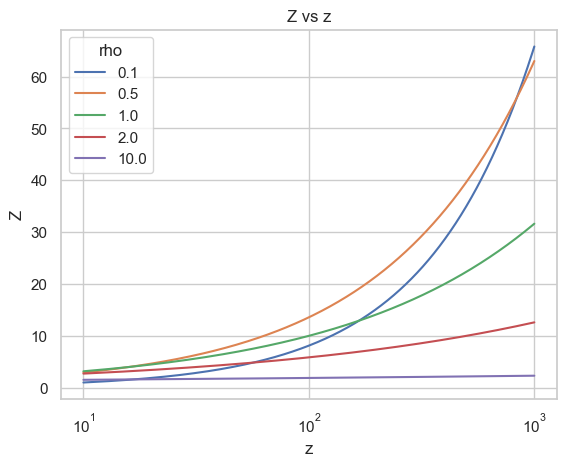

In [46]:
rho = np.array([0.1, 0.5, 1., 2., 10])
z = np.linspace(10., 1e3, 1000)
df = pd.DataFrame(np.asarray(np.meshgrid(rho, z)).T.reshape(-1, 2), columns=['rho', 'z'])
df = df.assign(Z = lambda x: np.power(x['rho'] * x['z'], 1/(x['rho']+1)))
df['rho'] = df['rho'].astype('category')

ax = sns.lineplot(x='z', y='Z', hue='rho', data=df)
ax.set(xscale='log')
ax.set_title('Z vs z');

**It becomes clear that the asymptotic expansion only works when $\rho$ is not too large.**
Otherweise, $Z$ will be too small.

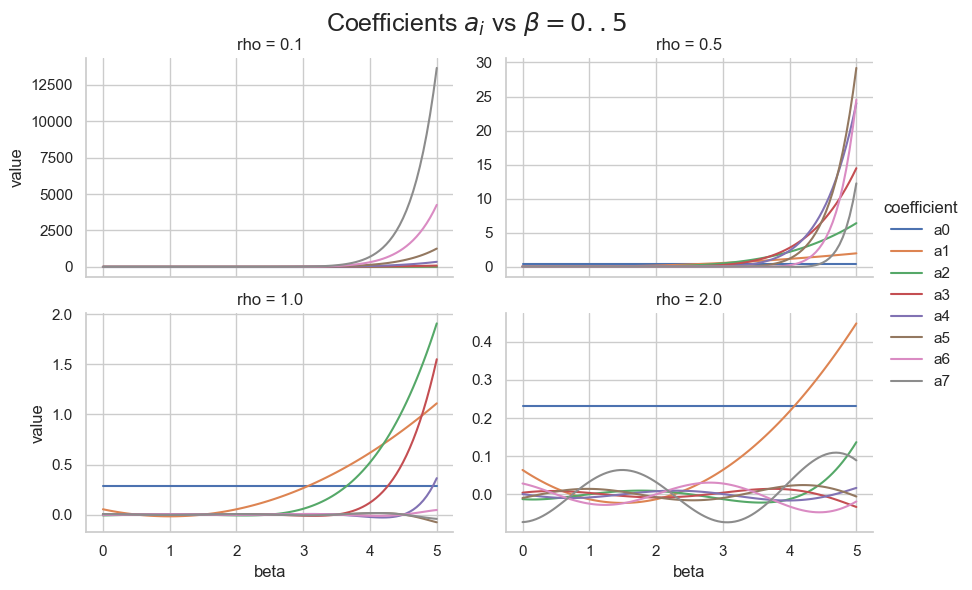

In [47]:
rho = np.array([0.1, 0.5, 1., 2.])
beta = np.linspace(0, 5, 100)
df = pd.DataFrame(
    np.asarray(np.meshgrid(rho, beta)).T.reshape(-1, 2), columns=['rho', 'beta']
)
df['a0'], df['a1'], df['a2'], df['a3'], df['a4'], df['a5'], df['a6'], df['a7'] = [0.] * 8

for row in df.itertuples():
    df.loc[row.Index, ['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7']] = (
        H(1., row.rho, row.beta, order=5, verbose=True)[1]
    )

df = df.melt(
    id_vars=['rho', 'beta'],
    value_vars=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7'],
    var_name='coefficient',
)
g = sns.FacetGrid(
    data=df, col='rho', hue='coefficient', sharey=False, col_wrap=2, aspect=1.5
)
g.map(plt.plot, 'beta', 'value')
g.add_legend()
g.fig.suptitle('Coefficients $a_i$ vs $\\beta = 0..5$', fontsize=18)
#g.fig.subplots_adjust(hspace=0.3);
g.fig.subplots_adjust(top=0.9);

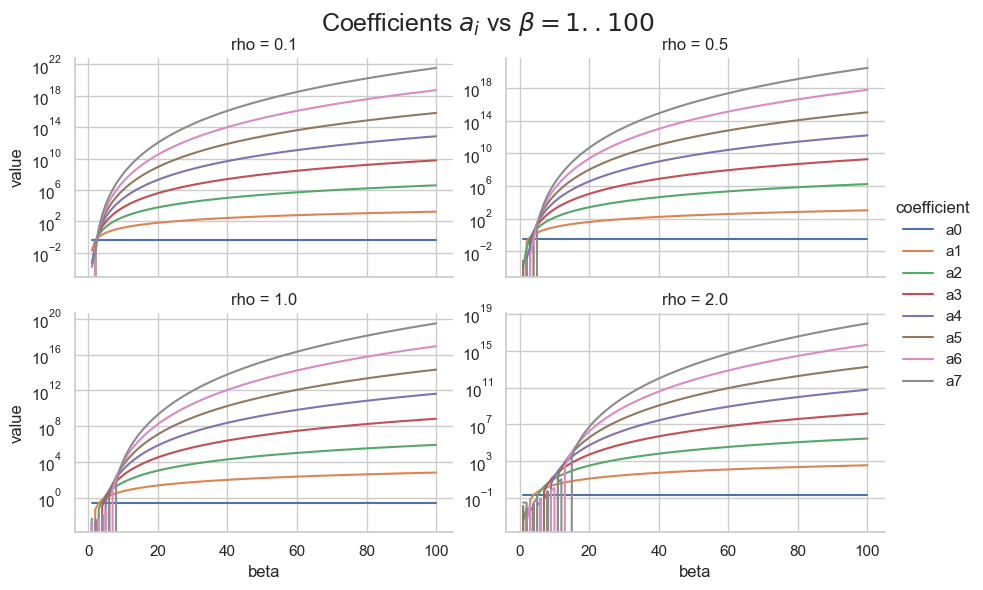

In [48]:
rho = np.array([0.1, 0.5, 1., 2.])
beta = np.linspace(1, 100, 100)
df = pd.DataFrame(
    np.asarray(np.meshgrid(rho, beta)).T.reshape(-1, 2), columns=['rho', 'beta']
)
df['a0'], df['a1'], df['a2'], df['a3'], df['a4'], df['a5'], df['a6'], df['a7'] = [0.] * 8

for row in df.itertuples():
    df.loc[row.Index, ['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7']] = (
        H(1., row.rho, row.beta, order=5, verbose=True)[1]
    )

df = df.melt(
    id_vars=['rho', 'beta'],
     value_vars=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7'],
     var_name='coefficient',
)
g = sns.FacetGrid(
    data=df, col='rho', hue='coefficient', sharey=False, col_wrap=2, aspect=1.5
)
g.map(plt.plot, 'beta', 'value')
g.set(yscale='log')
g.add_legend()
g.fig.suptitle('Coefficients $a_i$ vs $\\beta=1..100$', fontsize=18)
#g.fig.subplots_adjust(hspace=0.3);
g.fig.subplots_adjust(top=0.9);

In [49]:
# Coefficients (except a0) are zero at rho=1, beta=1/2 ?
H(1., rho=1, beta=1/2, order=7, verbose=True)[1]

array([0.28209479, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

#### Search for region of convergence $Z > \ldots$
In general, the asymptotic expansion is good only for large $Z$, wich is more likely for smaller $\rho$, say $\rho < 5$.
Additionally, the expansion is good only if the coefficients $a_k$ are not too large.
As the leading term of $a_k$ in $\beta$ is $\frac{\beta^{2k}}{2^k k! (\rho + 1)^k}$, the asymptotic expansion is only good for not too large $\beta$.

Text(0.5, 1.0, 'Accuracy of Asymptotic Expansion')

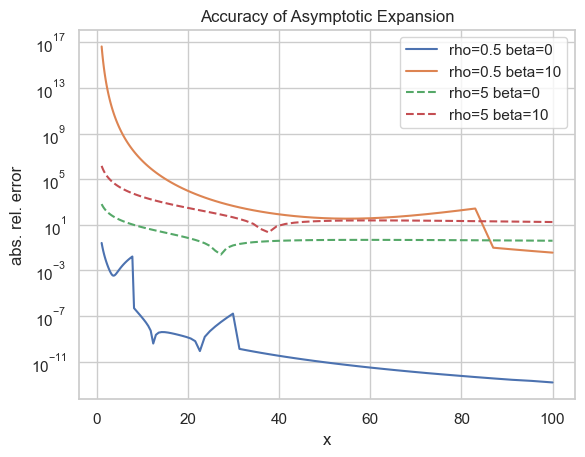

In [86]:
fig, ax = plt.subplots()
x = np.logspace(np.log(1), np.log(100), num=100, base=np.exp(1))
for rho, beta in itertools.product([0.5, 5], [0, 10]):
    y1 = np.array([
        Wright_Series_MPMATH(rho, beta, xx, dps=30, maxterms=2000, method='d') for xx in x
    ])
    y2 = np.array([Wright_Asymptotic(rho, beta, xx, order=8) for xx in x])
    lsty = "solid" if rho == 0.5 else "dashed"
    ax.plot(x, np.abs(y2/y1 - 1), label=f"{rho=} {beta=}", linestyle=lsty)
ax.set(yscale="log")
ax.set_xlabel("x")
ax.set_ylabel("abs. rel. error")
ax.legend()
ax.set_title("Accuracy of Asymptotic Expansion")

In [50]:
%%time
# Grid search for region of convergence
# set Z = 12  + beta**2 / (10*(1+rho))
rho = np.array([1e-2, 1e-1, 0.2, 0.5, 0.7, 0.9, 1, 1.1, 1.5, 2, 5, 10])
beta = np.array([0, 0.1, 0.2, 0.5, 0.7, 0.9, 1, 1.2, 1.5, 2, 5, 10, 100])
df = pd.DataFrame(np.asarray(np.meshgrid(rho, beta)).T.reshape(-1, 2), columns=['rho', 'beta'])

df['x'] = np.power(12 + df['beta']**2 / 4 / (1 + df['rho']), 1 + df['rho']) / df['rho']
df['Z'] = np.power(df['rho'] * df['x'], 1./(df['rho']+1))

df = df.query('log(Z) * (0.5 - beta) + (1+rho)/rho * Z <= 900')  # protection against overflow
df = df.sort_values(by=['rho', 'beta', 'x'])

df['a0'], df['a1'], df['a2'], df['a3'], df['a4'], df['a5'], df['a6'], df['a7'] = [0.]*8
df['H_5'] = 0.
df['H_6'] = 0.
df['H_7'] = 0.
df['H_8'] = 0.
df['MPMATH'] = 0.

for row in df.itertuples():
    df.loc[row.Index, ['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7']] = \
    H(1., row.rho, row.beta, order=5, verbose=True)[1]
    df.at[row.Index, 'H_6'] = H(row.Z, row.rho, row.beta, order=6)
    df.at[row.Index, 'H_7'] = H(row.Z, row.rho, row.beta, order=7)
    df.at[row.Index, 'H_8'] = H(row.Z, row.rho, row.beta, order=8)
    df.at[row.Index, 'MPMATH'] = float(
        Wright_Series_MPMATH(row.rho, row.beta, row.x, dps=30, steps=[200], maxterms=1100, method='s')
    )

df['rel_error_5'] = df['H_5'] / df['MPMATH'] - 1
df['rel_error_6'] = df['H_6'] / df['MPMATH'] - 1
df['rel_error_7'] = df['H_7'] / df['MPMATH'] - 1
df['rel_error_8'] = df['H_8'] / df['MPMATH'] - 1

CPU times: user 7.57 s, sys: 70.3 ms, total: 7.64 s
Wall time: 7.67 s


In [51]:
with pd.option_context("display.max_rows", 150, "display.float_format", '{:.4g}'.format):
    display(df
            .sort_values(by=['rho', 'beta', 'x'])
            .loc[:, ['rho', 'beta', 'x', 'Z', 'MPMATH', 'rel_error_5', 'rel_error_6', 'rel_error_7', 'rel_error_8']])

rho  beta         x     Z     MPMATH  rel_error_5  rel_error_6  \
13   0.1     0     153.9    12  2.775e+57           -1   -8.001e-13   
14   0.1   0.1     153.9    12  2.228e+57           -1   -1.032e-11   
15   0.1   0.2       154 12.01  1.879e+57           -1   -1.664e-11   
16   0.1   0.5     154.7 12.06  1.514e+57           -1   -6.403e-12   
17   0.1   0.7     155.4 12.11  1.673e+57           -1      1.2e-11   
18   0.1   0.9     156.4 12.18  2.248e+57           -1    1.569e-11   
19   0.1     1     157.1 12.23  2.801e+57           -1    9.182e-12   
20   0.1   1.2     158.5 12.33  5.031e+57           -1   -1.015e-11   
21   0.1   1.5     161.1 12.51  1.738e+58           -1   -7.161e-12   
22   0.1     2     166.7 12.91  3.578e+59           -1    3.266e-10   
23   0.1     5     235.7 17.68  1.697e+78           -1    9.109e-05   
24   0.1    10     495.2 34.73 2.348e+150           -1      0.01138   
26   0.2     0     98.63    12  2.324e+31           -1    2.521e-11   
27   0.2   0.1     98.65    12  1.843e+31           -1    1.955e-11   
28   0.2   0.2     98.71 12.01  1.497e+31           -1    9.622e-12   
29   0.2   0.5     99.14 12.05  9.282e+30           -1   -2.025e-11   
30   0.2   0.7     99.63  12.1  7.609e+30           -1   -1.837e-11   
31   0.2   0.9     100.3 12.17   6.86e+30           -1    1.668e-12   
32   0.2     1     100.7 12.21  6.748e+30           -1    1.255e-11   
33   0.2   1.2     101.6  12.3  7.007e+30           -1    2.119e-11   
34   0.2   1.5     103.3 12.47  8.829e+30           -1   -7.579e-12   
35   0.2     2     106.9 12.83  2.059e+31           -1    8.832e-12   
36   0.2     5       152 17.21  4.454e+38           -1    2.575e-05   
37   0.2    10       330 32.83  1.793e+70           -1     0.006278   
39   0.5     0     83.14    12  4.808e+15           -1   -7.646e-11   
40   0.5   0.1     83.16    12  3.784e+15           -1   -6.462e-11   
41   0.5   0.2     83.21 12.01  3.007e+15           -1   -4.347e-11   
42   0.5   0.5     83.57 12.04  1.595e+15           -1    3.629e-11   
43   0.5   0.7     83.99 12.08  1.094e+15           -1     6.28e-11   
44   0.5   0.9     84.55 12.13  7.784e+14           -1    4.823e-11   
45   0.5     1     84.88 12.17  6.653e+14           -1    2.784e-11   
46   0.5   1.2     85.65 12.24  4.989e+14           -1   -2.263e-11   
47   0.5   1.5     87.07 12.37  3.456e+14           -1   -6.144e-11   
48   0.5     2     90.16 12.67  2.217e+14           -1    4.753e-11   
49   0.5     5       130 16.17   9.55e+14           -1    1.849e-07   
50   0.5    10       307 28.67  3.971e+22           -1    0.0009508   
52   0.7     0     97.61    12  4.743e+12           -1   -2.644e-11   
53   0.7   0.1     97.63    12  3.727e+12           -1   -8.084e-11   
54   0.7   0.2     97.69 12.01  2.949e+12           -1   -1.217e-10   
55   0.7   0.5     98.12 12.04   1.52e+12           -1   -1.331e-10   
56   0.7   0.7     98.61 12.07  1.008e+12           -1   -5.774e-11   
57   0.7   0.9     99.27 12.12  6.862e+11           -1    4.089e-11   
58   0.7     1     99.66 12.15  5.713e+11           -1    8.339e-11   
59   0.7   1.2     100.6 12.21  4.032e+11           -1     1.29e-10   
60   0.7   1.5     102.2 12.33  2.499e+11           -1    7.297e-11   
61   0.7     2     105.9 12.59  1.262e+11           -1   -1.314e-10   
62   0.7     5     153.8 15.68  3.184e+10           -1   -1.801e-09   
63   0.7    10     380.3 26.71  5.084e+13           -1    0.0002362   
65   0.9     0     124.8    12  9.924e+10           -1    3.126e-10   
66   0.9   0.1     124.8    12  7.794e+10           -1    2.307e-10   
67   0.9   0.2     124.9 12.01  6.152e+10           -1    1.301e-10   
68   0.9   0.5     125.4 12.03  3.119e+10           -1    -1.74e-10   
69   0.9   0.7     126.1 12.06  2.033e+10           -1   -2.833e-10   
70   0.9   0.9     126.9 12.11   1.35e+10           -1   -2.711e-10   
71   0.9     1     127.4 12.13  1.108e+10           -1   -2.218e-10   
72   0.9   1.2     128.6 12.1

In [52]:
# Does a small term (a_k) correspond to small relative error in total? Yes.
# exclude zeros of coefficients: rho=1 and beta=0.5 or beta=1.5
df.loc[
    (np.abs(df['a5']/df['Z']**5 / df['a0']) < 1e-8)
    & ~((df['rho']==1) & (df['beta']==0.5))
    & ~((df['rho']==1) & (df['beta']==1.5)),
    ['rho', 'beta', 'x', 'Z', 'a0', 'a1', 'a5', 'a6', 'MPMATH', 'rel_error_5', 'rel_error_6']
]

rho  beta           x          Z        a0        a1        a5        a6  \
13  0.1   0.0  153.850662  12.000000  0.380377  0.036309  0.000179 -0.000260   
14  0.1   0.1  153.882715  12.002273  0.380377  0.019019  0.000288 -0.000186   
15  0.1   0.2  153.978876  12.009091  0.380377  0.005187  0.000318 -0.000066   
16  0.1   0.5  154.652157  12.056818  0.380377 -0.015561 -0.000029  0.000246   
17  0.1   0.7  155.421948  12.111364  0.380377 -0.012103 -0.000295  0.000146   
18  0.1   0.9  156.448875  12.184091  0.380377  0.005187 -0.000211 -0.000141   
19  0.1   1.0  157.058903  12.227273  0.380377  0.019019 -0.000029 -0.000245   
20  0.1   1.2  158.472425  12.327273  0.380377  0.057056  0.000322 -0.000168   
21  0.1   1.5  161.077586  12.511364  0.380377  0.140048  0.000020  0.000245   
26  0.2   0.0   98.625110  12.000000  0.364183  0.038947 -0.000155 -0.000186   
27  0.2   0.1   98.645657  12.002083  0.364183  0.022256  0.000028 -0.000278   
28  0.2   0.2   98.707303  12.008333  0.364183  0.008599  0.000194 -0.000303   
29  0.2   0.5   99.139005  12.052083  0.364183 -0.014163  0.000306 -0.000009   
30  0.2   0.7   99.632762  12.102083  0.364183 -0.014163  0.000016  0.000246   
31  0.2   0.9  100.291740  12.168750  0.364183 -0.002023 -0.000305  0.000259   
32  0.2   1.0  100.683350  12.208333  0.364183  0.008599 -0.000365  0.000148   
33  0.2   1.2  101.591211  12.300000  0.364183  0.038947 -0.000155 -0.000186   
34  0.2   1.5  103.266036  12.468750  0.364183  0.107232  0.000448 -0.000233   
35  0.2   2.0  106.899918  12.833333  0.364183  0.281736  0.001068  0.000060   
39  0.5   0.0   83.138439  12.000000  0.325735  0.045241 -0.000417  0.000630   
40  0.5   0.1   83.155760  12.001667  0.325735  0.030040 -0.000601  0.000680   
41  0.5   0.2   83.207730  12.006667  0.325735  0.017011 -0.000682  0.000624   
42  0.5   0.5   83.571827  12.041667  0.325735 -0.009048 -0.000326  0.000005   
43  0.5   0.7   83.988586  12.081667  0.325735 -0.015563  0.000182 -0.000445   
44  0.5   0.9   84.545338  12.135000  0.325735 -0.013391  0.000570 -0.000609   
45  0.5   1.0   84.876490  12.166667  0.325735 -0.009048  0.000637 -0.000538   
46  0.5   1.2   85.645021  12.240000  0.325735  0.006153  0.000444 -0.000130   
47  0.5   1.5   87.065843  12.375000  0.325735  0.045241 -0.000417  0.000630   
48  0.5   2.0   90.161994  12.666667  0.325735  0.153819 -0.000287 -0.000203   
52  0.7   0.0   97.613543  12.000000  0.305975  0.048596  0.000504 -0.000196   
53  0.7   0.1   97.633880  12.001471  0.305975  0.034197  0.000079  0.000251   
54  0.7   0.2   97.694902  12.005882  0.305975  0.021598 -0.000325  0.000639   
57  0.7   0.9   99.266489  12.119118  0.305975 -0.016199 -0.000285  0.000011   
58  0.7   1.0   99.655871  12.147059  0.305975 -0.014399  0.000082 -0.000382   
59  0.7   1.2  100.560005  12.211765  0.305975 -0.005400  0.000759 -0.000989   
61  0.7   2.0  105.886894  12.588235  0.305975  0.102592 -0.000958  0.001223   
68  0.9   0.5  125.447125  12.032895  0.289423 -0.001777 -0.000670  0.000944   
72  0.9   1.2  128.566820  12.189474  0.289423 -0.012440 -0.000653  0.000631   
95  1.1   0.7  169.555005  12.058333  0.275296 -0.010051 -0.000573  0.000508   

          MPMATH  rel_error_5   rel_error_6  
13  2.774655e+57         -1.0 -8.001377e-13  
14  2.227664e+57         -1.0 -1.031542e-11  
15  1.878871e+57         -1.0 -1.663880e-11  
16  1.513574e+57         -1.0 -6.403322e-12  
17  1.673350e+57         -1.0  1.199751e-11  
18  2.247520e+57         -1.0  1.568656e-11  
19  2.801291e+57         -1.0  9.182211e-12  
20  5.031101e+57         -1.0 -1.014966e-11  
21  1.738026e+58         -1.0 -7.161161e-12  
26  2.323892e+31         -1.0  2.521250e-11  
27  1.842651e+31         -1.0  1.954636e-11  
28  1.497080e+31         -1.0  9.622303e-12  
29  9.282391e+30         -1.0 -2.024836e-11  
30  7.609401e+30         -1.0 -1.836808e-11  
31  6.859997e+30         -1.0  1.667999e-12  
32  6.748300e+30         -1.0  1.254685e-11  
33  7.006762e+30     

In [53]:
df.query("abs(rel_error_8) <= 1e-10").loc[:, 'rho'].unique()

array([0.1, 0.2, 0.5, 0.7, 0.9, 1. , 1.1, 1.5])

In [54]:
rho, beta, z = 1, 10, 500
Z = np.power(rho * z, 1/(rho+1))
print(f"Z = {Z}, beta**2/(10(1+rho))={beta**2/(10*(1+rho))}")

y1 = float(Wright_Series_MPMATH(rho, beta, z, steps=[5000], dps=40, maxterms=10_000, method='d'))
for order in [6, 7, 8]:
    print(
        f"relaltive error with asymptotic expansion of {order=}: "
        f"{rel_err(Wright_Asymptotic(rho, beta, z, order=order), y1):>9.2e}"
    )

Z = 22.360679774997898, beta**2/(10(1+rho))=5.0
relaltive error with asymptotic expansion of order=6:  4.06e-05
relaltive error with asymptotic expansion of order=7: -1.44e-06
relaltive error with asymptotic expansion of order=8:  1.60e-08


### 2.4. Integral Representation <a id="integral"></a>
[back to TOC](#toc)
<br>
See Luchko (2008).
Note that the definition of $P(\rho, \beta, x, \epsilon, \varphi)$ in Eq. (9) has a misprint.
The $\cos(\varphi(\beta-1))$ at the end of the first line should be removed and the the $−\sin(\varphi(\beta−1))$ at the end of the second line should read $+(1-b)\varphi$.

Here we use $a=\rho$ and $b=\beta$:
$$K(a, b, x, r) = \exp(-r + x \cdot r^{-a} \cos(\pi a)) \cdot r^{-b} \cdot
                  \sin(x \cdot r^{-a} \sin(\pi a) + \pi b)$$
$$P(\epsilon, a, b, x, \varphi) = \exp(\epsilon \cos(\varphi) + x \cdot \epsilon^{-a} \cos(a \varphi))
                          \cdot \cos(\epsilon \sin(\varphi) - x \cdot \epsilon^{-a} \sin(a \varphi)
                              + (1-b) \varphi)$$
Then
$$\Phi(a, b, x) = \frac{1}{\pi} \int_{\epsilon}^\infty K(a, b, x, r) \; dr
        + \frac{\epsilon^{1-b}}{\pi} \int_0^\pi P(\epsilon, a, b, x, \varphi) \; d\varphi$$

for any $\epsilon > 0$.

**Very importantly**, while Luchko (2008) strives to set the limit $\epsilon \rightarrow 0$, we use the freedom to choose it.
In fact, any $\epsilon > 0$ is allowed.

#### 2.4.1 Definition of Integral Representation
Here comes already the full implementation of the integral represantation.
This includes the choice of $\epsilon$.
The next section goes into depth how this is done.

In [136]:
def K(rho, beta, x, r):
    r_rho = np.power(r, -rho)
    return (
        np.exp(-r + x * r_rho * np.cos(np.pi*rho))
        * np.power(r, -beta)
        * np.sin(x * r_rho * np.sin(np.pi * rho) + np.pi * beta)
    )

def Kmod(eps, rho, beta, x, r):
    """
    Kmod = K(rho, beta, x, r+eps) / exp(-r-eps)
    """
    r_rho = np.power(r+eps, -rho)
    return (
        np.exp(x * r_rho * np.cos(np.pi*rho))
        * np.power(r+eps, -beta)
        * np.sin(x * r_rho * np.sin(np.pi * rho) + np.pi * beta)
    )

def P(eps, rho, beta, x, phi):
    """Beware of misprints in Luchko!!!"""
    eps_rho = np.power(1. * eps, -rho)
    return (
        np.exp(eps*np.cos(phi) + x * eps_rho * np.cos(rho*phi))
        * np.cos(eps*np.sin(phi) - x * eps_rho * np.sin(rho*phi) + (1-beta)*phi)
    )

def Wright_Integral_quad(rho, beta, z, error_out=False, eps=1e-10, epsrel=1e-10):
    if rho <= -1:
        raise ValueError("rho must be larger than -1.")    
    
    # boundary r0 for integral over K according to Luchko:
    if z * np.cos(np.pi * rho) <= 0:
        if beta >= 0:
            r0 = -np.log(eps)
        else:
            r0 = max(-beta + 1,
                     -2 * np.log(eps * np.power(-2.*beta, beta)/(-beta + 2)))
    elif beta >= 0:
        r0 = max(-2 * np.log(eps*np.power(2., beta-1)),
                 np.power(2 * z * np.cos(rho*np.pi), 1/(1+rho)))
    else:
        r0 = max(2 * (-beta + 1),
                 -4 * np.log(eps * np.power(-4.*beta, beta) / (2*(-beta + 2))),
                 np.power(2 * z * np.cos(rho*np.pi), 1/(1+rho)))

    if z > 0:
        if (rho < 0 and beta <= 1) or (rho == 0 and beta < 1):
            K_int = integrate.quad(lambda r: K(rho, beta, z, r), 0, r0, epsrel=epsrel, limit=1000)
            err = 1./np.pi * K_int[1]
            res = 1./np.pi * K_int[0]
        
            if beta == 1 and rho < 0:
                res += 1.
        else:
            K_int = integrate.quad(lambda r:   K(rho, beta, z, r),   1, r0, epsrel=epsrel, limit=1000)
            P_int = integrate.quad(lambda phi: P(1, rho, beta, z, phi), 0, np.pi,  epsrel=epsrel, limit=1000)
            err = 1./np.pi * (K_int[1] + P_int[1])
            res = 1./np.pi * (K_int[0] + P_int[0])            
    else:
        raise NotImplementedError("z < 0 is not yet implemented.")
        
    if error_out:
        return res, err
    else:
        return res


def _cached_roots_laguerre(n):
    """Cache roots_laguerre results to speed up calls of the fixed_laguerre function.
    """
    if n in _cached_roots_laguerre.cache:
        return _cached_roots_laguerre.cache[n]

    _cached_roots_laguerre.cache[n] = ss.roots_laguerre(n)
    return _cached_roots_laguerre.cache[n]


_cached_roots_laguerre.cache = dict()


def fixed_laguerre(func, args=(), n=5):
    """Compute fixed order Gauss-Laguerre quadruature"""
    x, w = _cached_roots_laguerre(n)
    x = np.real(x)
    return np.sum(w*func(x, *args), axis=-1), None


def eps_select(rho, beta, z):
    """Select an appropriate eps for integration.
    a = rho, b=beta, z = x
    """
    # We use the free choice of eps to make the integral better behaved.
    # 1. Concern is oscillatory behaviour of P. Therefore, we'd like to
    #    make the change in the argument of cosine small, i.e. make arc length
    #    int_0^phi sqrt(1 + f'(phi)^2) dphi small, with
    #    f(phi) = eps * sin(phi) - x * eps^(-a) * sin(a*phi) + (1-b)*phi
    #    Proxy, make |f'(phi)| small.
    # 2. Concern is int_0 K ~ int_0 (r+eps)^(-b) .. dr
    #    This is difficult as r -> 0  for large b. It behaves better for larger
    #    values of eps.
    #
    # 1. Minimize oscillatory behaviour of P.
    #a = [2.25974, 12.3104, 0.975979, 1.57556, 2.42271, 1.94177E-03]
    #eps = a[0] * beta + a[1] * np.power(z, a[2]/(1.+rho)) * np.power(rho, a[3]) * (np.exp(-a[4]*np.sqrt(rho)) + a[5])
    A = [0.41037, 0.30833, 6.9952, 18.382, -2.8566, 2.1122]
    eps = A[0] * beta * np.exp(-0.5*rho) + np.exp(A[1] + 1/(1+rho) * np.log(z) - A[2] * np.exp(-A[3]*rho) + A[4] / (1 + np.exp(A[5]*rho)))
    if rho > 4 and z >= 100:
        eps += 1
        
    # 2. Large b
    if beta >= 8:
        # Make P small compared to K by setting eps large enough.
        # int K ~ exp(-eps) and int P ~ eps^(1-b)
        eps = max(eps, np.power(beta, -beta/(1.-beta)) + 0.1 * beta)
        
#    elif z > 1 and rho > 1:
#        # set eps such that z*eps^(-rho) = 2^(-rho)
#        eps = 2*np.power(z, 1./rho)
#    elif z > 1 and rho > 0:  # 0 < a < 1
#        # approx sin(a * phi) ~ a * phi
#        # set eps such that eps ~ a * x * eps^(-a)
#        # multiply by 2**(beta-1) to take advantage larger beta values.
#        eps = np.power(rho*z, 1./(1.+rho)) * 2**(beta-1)
#        #if z <= 5 and beta >= 5:
#        #    eps = 2*eps
#        #elif rho <= 0.1:
#        #    eps *= np.power(2, np.log10(rho))
#    else:
#        eps = 1.
    # safeguard, higher better for larger a, lower better for tiny a.
    eps = min(eps, 150)
    eps = max(eps, 3)
    return eps


def Wright_Integral(rho, beta, z, n_laguerre=50, n_legendre=50, eps=None):
    """
    Compute Wrights generalized Bessel function via integration.
    
    n_laguerre : order of quadrature rule for gauss-laguerre for integration over K.
    n_legendre : order of quadrature rule for gauss-legendre for integration over P.
    """
    if rho <= -1:
        raise ValueError("rho must be larger than -1.")    

    if z > 0:
        if (rho < 0 and beta <= 1) or (rho == 0 and beta < 1):
            # integrate from 0 to inf
            K_int = fixed_laguerre(lambda r: K(rho, beta, z, r) * np.exp(r), n=n_laguerre)[0]
            res = 1. / np.pi * K_int
        
            if beta == 1 and rho < 0:
                res += 1.
        else:
            if eps is None:
                eps = eps_select(rho, beta, z)
            #print(eps)
            K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=n_laguerre)
            P_int = integrate.fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=n_legendre)
            res = 1. / np.pi * (np.exp(-eps) * K_int[0] + np.power(eps, 1.-beta) * P_int[0])            
    else:
        raise NotImplementedError("z < 0 is not yet implemented.")
        
    return res

In [137]:
rho = 1.
beta = 10.
x = 500.
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y1, rel_err(y2, y1), eps_select(rho, beta, x)

(454308.62922139864454, -2.671207051898103e-14, 24.850932083693337)

In [138]:
rho = 0.1
beta = 5.
x = 100.
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
rel_err(y2, y1), eps_select(rho, beta, x)

(4.174425824716926e-05, 10.149627517981061)

In [139]:
rho = 0.001
beta = 7.
x = 100.
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[200], method='s')
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y3 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=1)
rel_err(y2, y1), rel_err(y3, y1), eps_select(rho, beta, x)

(-2.741317558080446e-14, 3.43216523086125e-06, 3)

In [140]:
rho = 0.001
beta = 7.
x = 500.
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[2000], method='s')
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y3 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=1)
rel_err(y2, y1), rel_err(y3, y1), eps_select(rho, beta, x)

(-9.355078491507919e-15, 3.402457343913597e-05, 3.040155049758932)

In [141]:
rho = 0.001
beta = 7.
x = 500.
{f"beta = {beta}": (eps_select(rho, beta, 100), eps_select(rho, beta, 500)),
 f"beta = {0}": (eps_select(rho, 0, 100), eps_select(rho, 0, 500))
}

{'beta = 7.0': (3, 3.040155049758932), 'beta = 0': (3, 3)}

In [142]:
# for rho < 0 and beta < 1, test integration equivalence
rho = -0.5
beta = 0.1
z = 1
integrate.quad(lambda r: K(rho, beta, z, r), 0, np.inf, epsrel=1e-6, limit=2000)[0], \
integrate.quad(lambda r: K(rho, beta, z, r), 1, np.inf, epsrel=1e-6, limit=2000)[0] \
+ integrate.quad(lambda phi: P(1, rho, beta, z, phi), 0, np.pi,  epsrel=1e-6, limit=1000)[0]

(-0.46574098486097193, -0.46574098486037246)

### 4.2 Choice of epsilon
We have an integral over $K$ and an integral over $P$.
We are looking for a choice of $\epsilon$ that **makes both integrands numerical well behaved at the same time**.

#### Integrand P
Goal: Least oscillatory behaviour of integrand => arc length of argument of $cos(...)$ of $P(\epsilon, a, b, x, \varphi)$ should be minimal.
Arc length of function $f$ is computed as $\int \sqrt{1+f'(t)^2}dt$.

We have $f(\varphi) = \epsilon \sin(\varphi) - x \epsilon^{-\rho} \sin(\rho \varphi) + (1-\beta) \varphi$ and arc length $s = \int_0^\pi \sqrt{1+f^{\prime 2}}d\varphi$.

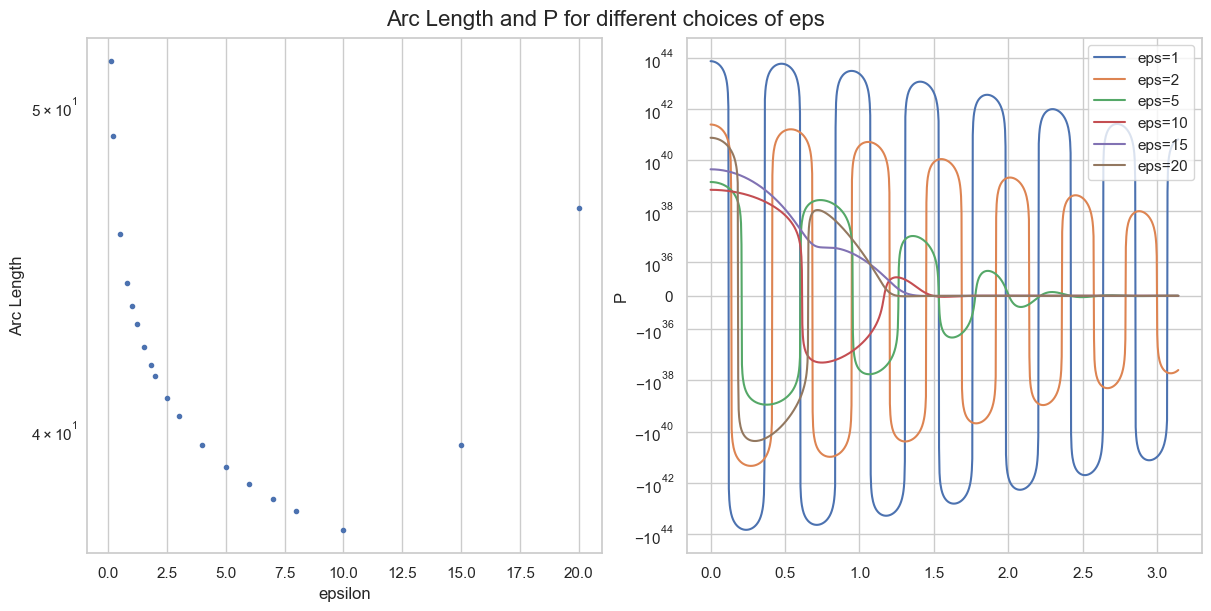

In [143]:
# Arc length of argument of cosine part of P
def f(eps, rho, beta, x, phi):
    """Argument of cosine of P."""
    eps_rho = np.power(1.*eps, -rho)
    return eps*np.sin(phi) - x * eps_rho * np.sin(rho*phi) + (1-beta)*phi


def fp(eps, rho, beta, x, phi):
    """Derivative w.r.t. phi"""
    eps_rho = np.power(1.*eps, -rho)
    return eps*np.cos(phi) - rho* x * eps_rho * np.cos(rho*phi) + (1-beta)

def arclength(eps, rho, beta, x, epsrel=1e-2, limit=100):
    return integrate.quad(lambda phi: np.sqrt(1 + fp(eps, rho, beta, x, phi)**2), 0, np.pi,  epsrel=epsrel, limit=100)[0]


eps = 1
rho = 1e-1
beta = 5
x = 100

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
eps_list = [0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 1.8, 2, 2.5, 3, 4, 5, 6, 7, 8, 10, 15, 20]
eps_list_small = [1, 2, 5, 10, 15, 20]
phi = np.linspace(0, np.pi, 1_000)
res = []
for eps in eps_list:
    res.append(arclength(eps, rho, beta, x))
    # leave out np.power(eps, 1.-beta) as we are only interested in oscillation
    if eps in eps_list_small:
        y2 = P(eps, rho, beta, x, phi)
        axes[1].plot(phi, y2, label=f"eps={eps}")

axes[0].plot(eps_list, res, ".")
axes[0].set_xlabel("epsilon")
axes[0].set_ylabel("Arc Length")
axes[0].set_yscale("log")
axes[1].legend(loc='upper right')
axes[1].set_ylabel("P")
axes[1].set_yscale("asinh", linear_width=1e35, base=10)
fig.suptitle("Arc Length and P for different choices of eps", fontsize=16);

In [144]:
rho = 4.999
beta = 0
x = 1e5

eps_opt = optimize.minimize_scalar(
            lambda eps: arclength(eps, rho, beta, x),
            bounds=(1e-3, 1000),
            method='Bounded', options={'xatol':1e-3}).x

y1 = Wright_Series_MPMATH(rho, beta, x, steps=[300])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y3 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=eps_opt)
{'value': y1,
 'abs_rel_fit_esp': y2/y1-1,
 'abs_rel_opt_esp': y3/y1-1,
 'eps': eps_select(rho, beta, x),
 'eps_opt': eps_opt, 'Z': np.power(rho*x, 1/(1+rho))}

{'value': 19975.784421040304722,
 'abs_rel_fit_esp': -7.7728026685668864110e-14,
 'abs_rel_opt_esp': -1.5385395577314315771e-13,
 'eps': 10.275686364581858,
 'eps_opt': 10.063596956686323,
 'Z': 8.911938581802515}

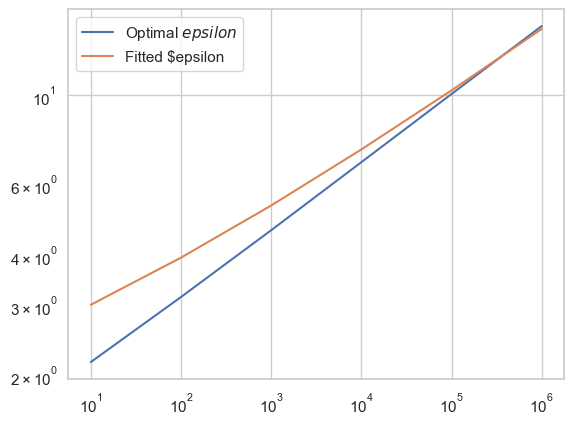

In [145]:
rho = 4.999
beta = 0
x_list = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
res = []
for x in x_list:
    res.append(
        optimize.minimize_scalar(
            lambda eps: arclength(eps, rho, beta, x),
            bounds=(1e-3, 1000),
            method='Bounded', options={'xatol':1e-3}).x
    )

plt.plot(x_list, res, label='Optimal $epsilon$')
plt.plot(x_list, [eps_select(rho, beta, x) for x in x_list], label='Fitted $epsilon')

plt.xscale('log')
plt.yscale('log')
plt.legend()

In [146]:
%%time
# grid of minimal arc length values
data_rho = [1e-3, 0.1, 0.5, 0.9, 1, 2, 4, 5, 6, 8]
data_beta = [0, 1, 4, 7, 10]
data_x = [1, 1.5, 2, 4, 10, 20, 50, 100, 200, 500, 1e3, 5e3, 1e4]
data_rho, data_beta, data_x = np.meshgrid(data_rho, data_beta, data_x)
data_rho, data_beta, data_x = data_rho.flatten(), data_beta.flatten(), data_x.flatten()
best_eps = []
for i in range(data_x.size):
    best_eps.append(
        optimize.minimize_scalar(lambda eps: arclength(eps, data_rho[i], data_beta[i], data_x[i]),
                                    bounds=(1e-3, 1000),
                                    method='Bounded', options={'xatol':1e-3}).x
    )
best_eps = np.array(best_eps)
df = pd.DataFrame({'rho': data_rho,
                   'beta': data_beta,
                    'x': data_x,
                    'eps': best_eps})

#with pd.option_context("display.max_rows", 200):
#    display(df.query("eps>=1 and beta <= 8"))

CPU times: user 4.02 s, sys: 16.9 ms, total: 4.04 s
Wall time: 4.04 s


In [147]:
#def func(data, a1, a2, a3, a4, a5, a6):
#    rho = data['rho']
#    beta = data['beta']
#    x = data['x']
#    return (a1 * beta + a2 * np.power(x, a3/(1+rho))) * np.power(rho, a4) * (np.exp(-a5 * np.sqrt(rho)) + a6)
#
#func_params = list(optimize.curve_fit(func, df, df['eps'])[0])
#func_params

In [148]:
def func(data, a1, a2, a3, a4, a5, a6):
    rho = data['rho']
    beta = data['beta']
    x = data['x']
    return a1 * beta * np.exp(-0.5*rho) + np.exp(a2 + 1/(1+rho) * np.log(x) - a3 * np.exp(-a4*rho) + a5 / (1 + np.exp(a6*rho)))

func_params = list(optimize.curve_fit(func, df, df['eps'], method='trf')[0])
func_params

[0.41036929567970204,
 0.3083321464843335,
 6.995192544799408,
 18.382034940021658,
 -2.8566177025334007,
 2.112188446194987]

In [149]:
print("Mean Squared Error")
np.square(func(pd.DataFrame({'rho': data_rho,
                   'beta': data_beta,
                    'x': data_x}), *func_params)
          - best_eps).mean()

Mean Squared Error


1.3893478058360933

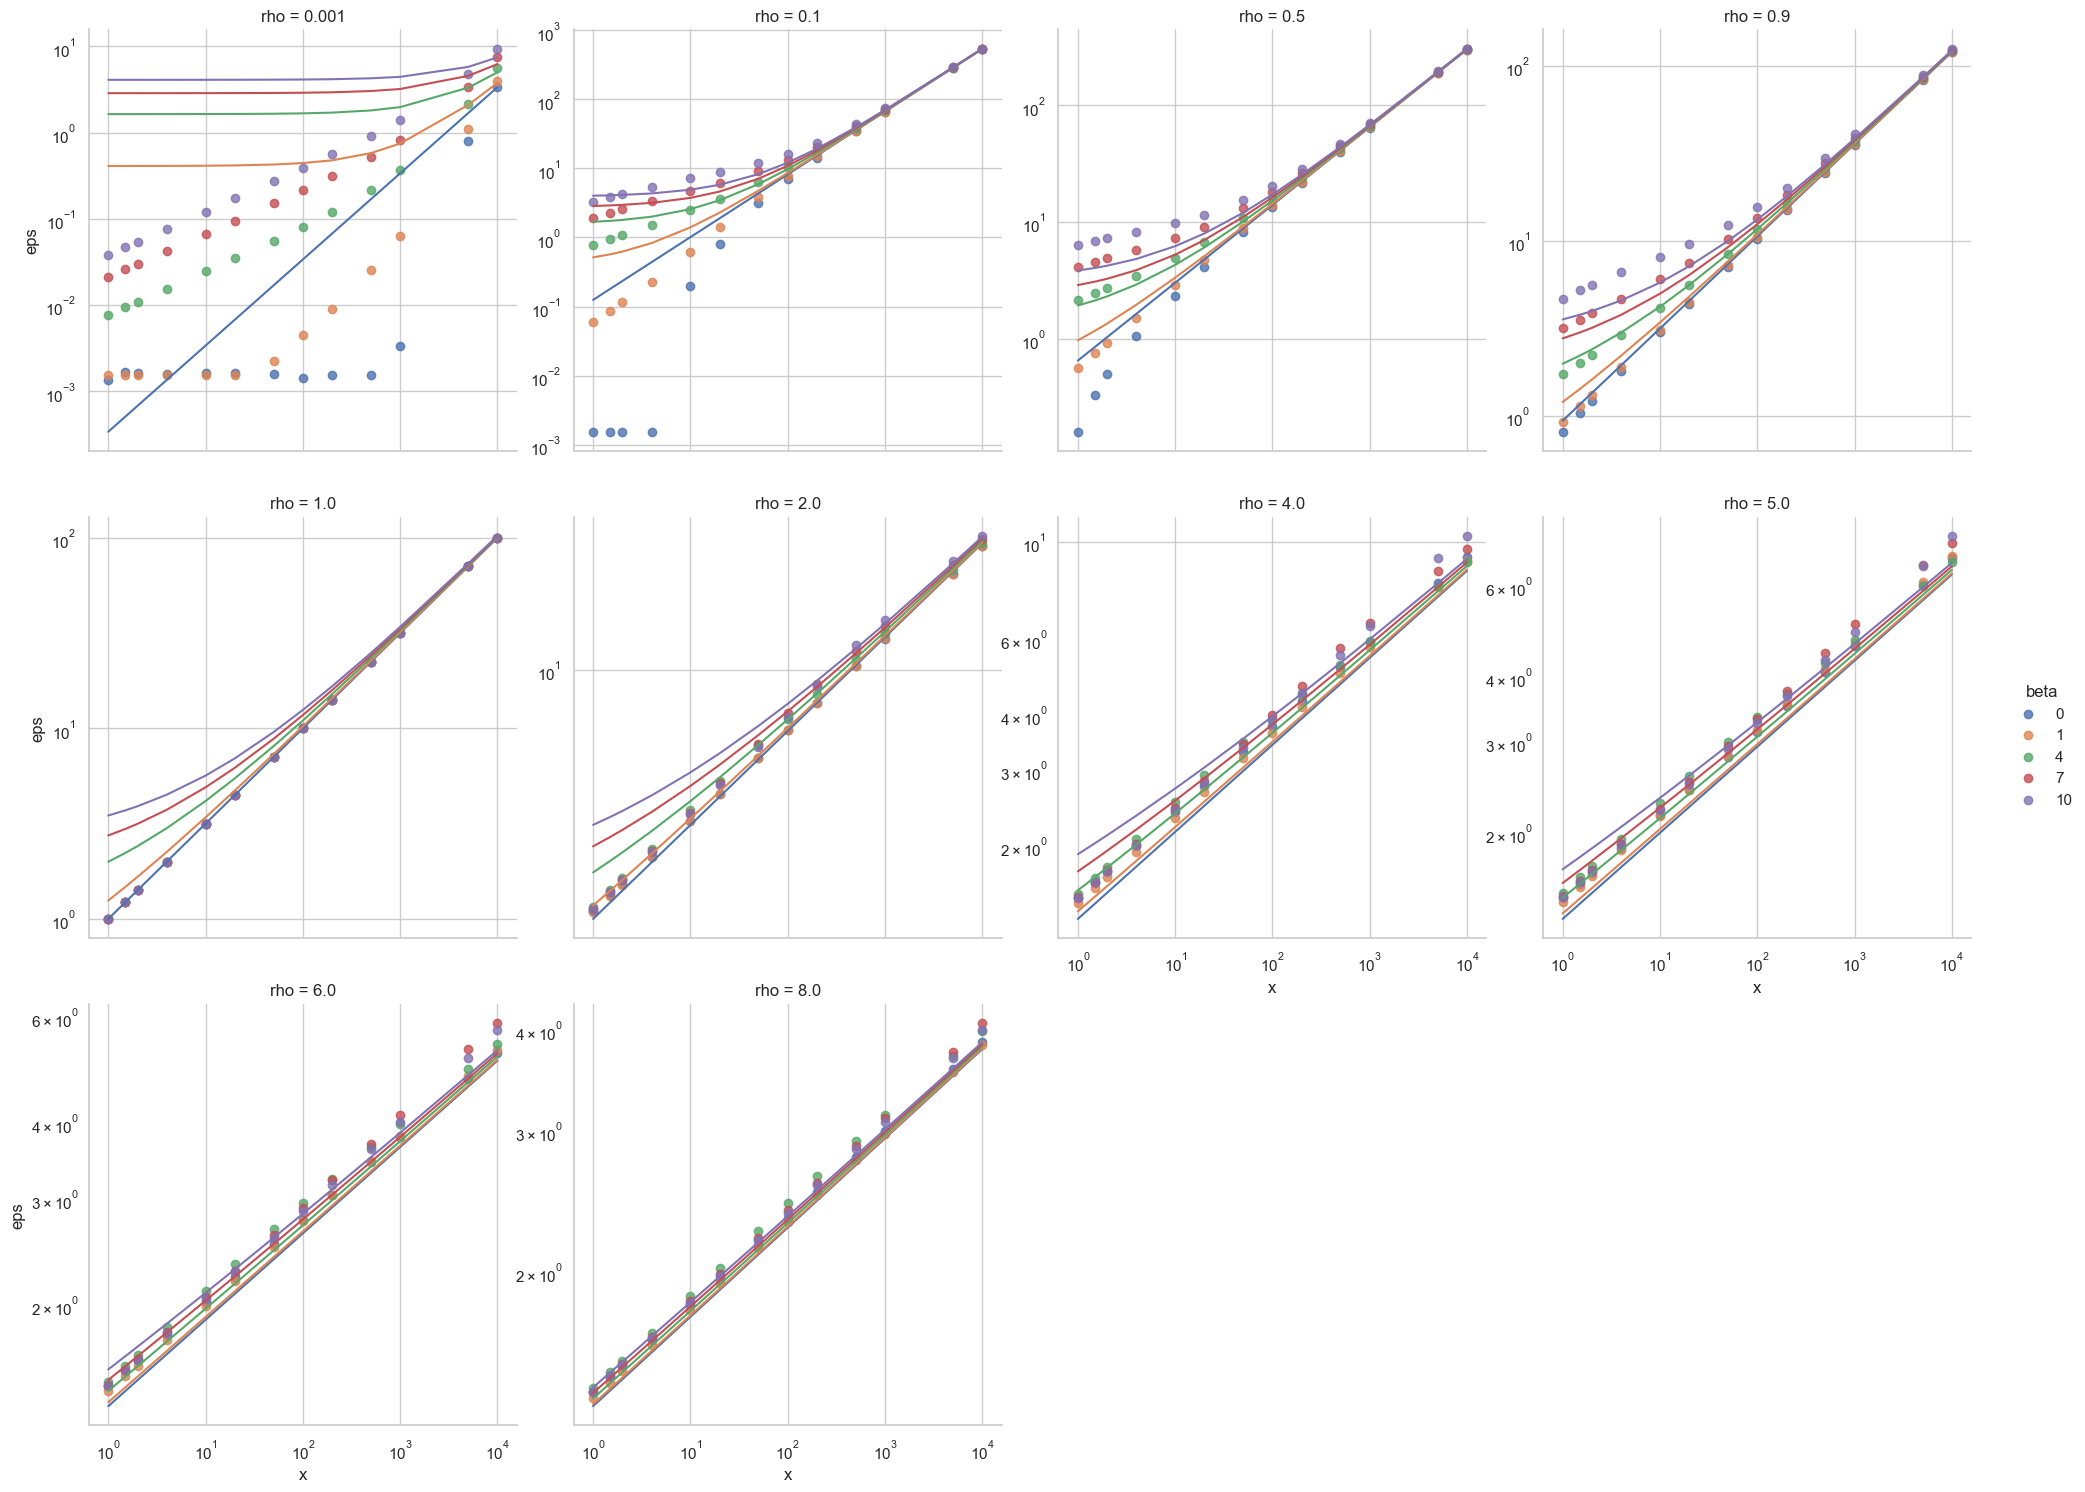

In [151]:
g = sns.lmplot(x = 'x', y = 'eps',
              hue='beta', col='rho',
              data = df,
              fit_reg=False,
              col_wrap=4,
              facet_kws=dict(sharey=False))

#g = sns.FacetGrid(df, hue='beta', col='rho')
#g.map(plt.scatter, "x", "eps")

def my_fit(*args, **kwargs):
    x = args[0]
    rho = args[2].iloc[0]
    beta = args[3].iloc[0]
    y = func(pd.DataFrame({'x': x, 'rho':rho, 'beta': beta}), *func_params)
    kwargs['marker'] = None
    return plt.plot(x, y, **kwargs)

g.map(my_fit, 'x', 'eps', 'rho', 'beta')
g.set(xscale = 'log')
g.set(yscale = 'log')

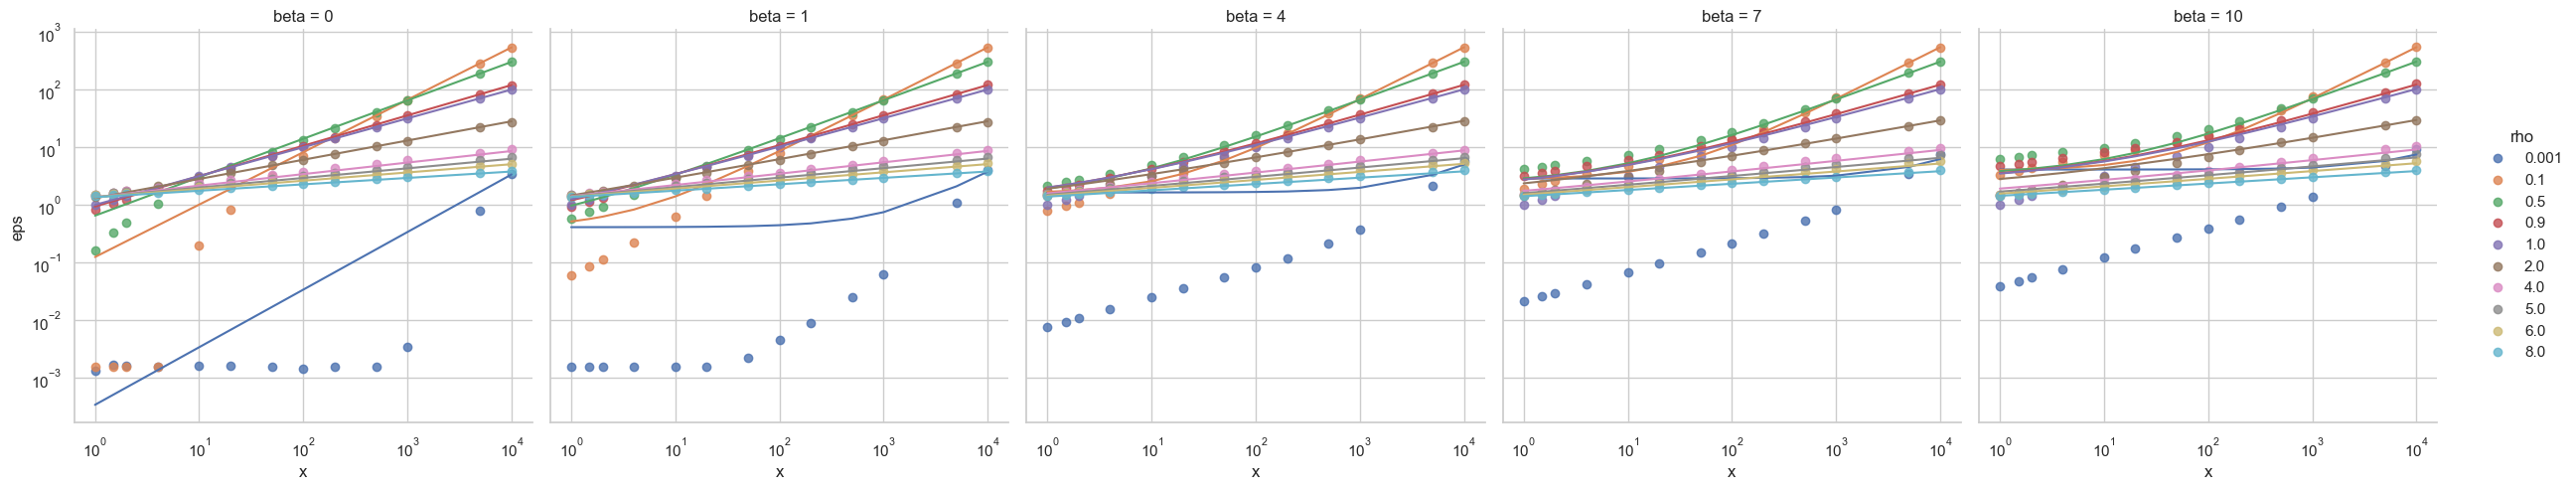

In [153]:
g = sns.lmplot(x = 'x', y = 'eps',
              col='beta', hue='rho',
              data = df,
              fit_reg=False,
              col_wrap=5)

#g = sns.FacetGrid(df, hue='beta', col='rho')
#g.map(plt.scatter, "x", "eps")

def my_fit(*args, **kwargs):
    x = args[0]
    rho = args[2].iloc[0]
    beta = args[3].iloc[0]
    y = func(pd.DataFrame({'x': x, 'rho':rho, 'beta': beta}), *func_params)
    kwargs['marker'] = None
    return plt.plot(x, y, **kwargs)

g.map(my_fit, 'x', 'eps', 'rho', 'beta')
g.set(xscale = 'log')
g.set(yscale = 'log')

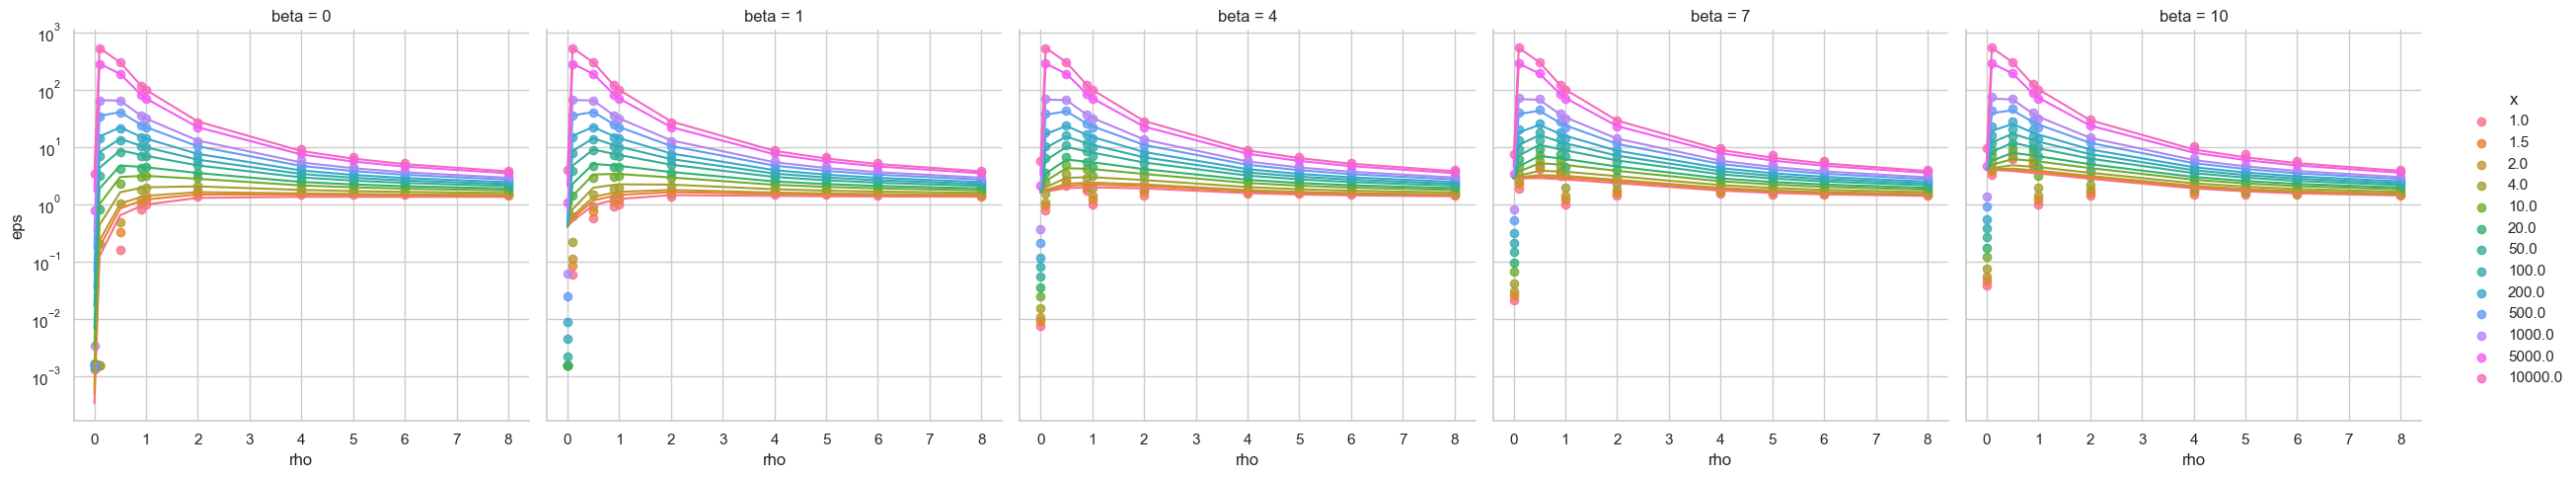

In [154]:
g = sns.lmplot(x = 'rho', y = 'eps',
              col='beta', hue='x',
              data = df,
              fit_reg=False,
              col_wrap=5)

#g = sns.FacetGrid(df, hue='beta', col='rho')
#g.map(plt.scatter, "x", "eps")

def my_fit(*args, **kwargs):
    x = args[2]
    rho = args[0]
    beta = args[3]
    y = func(pd.DataFrame({'x': x, 'rho':rho, 'beta': beta}), *func_params)
    kwargs['marker'] = None
    return plt.plot(rho, y, **kwargs)

g.map(my_fit, 'rho', 'eps', 'x' , 'beta')
g.set(yscale="log")

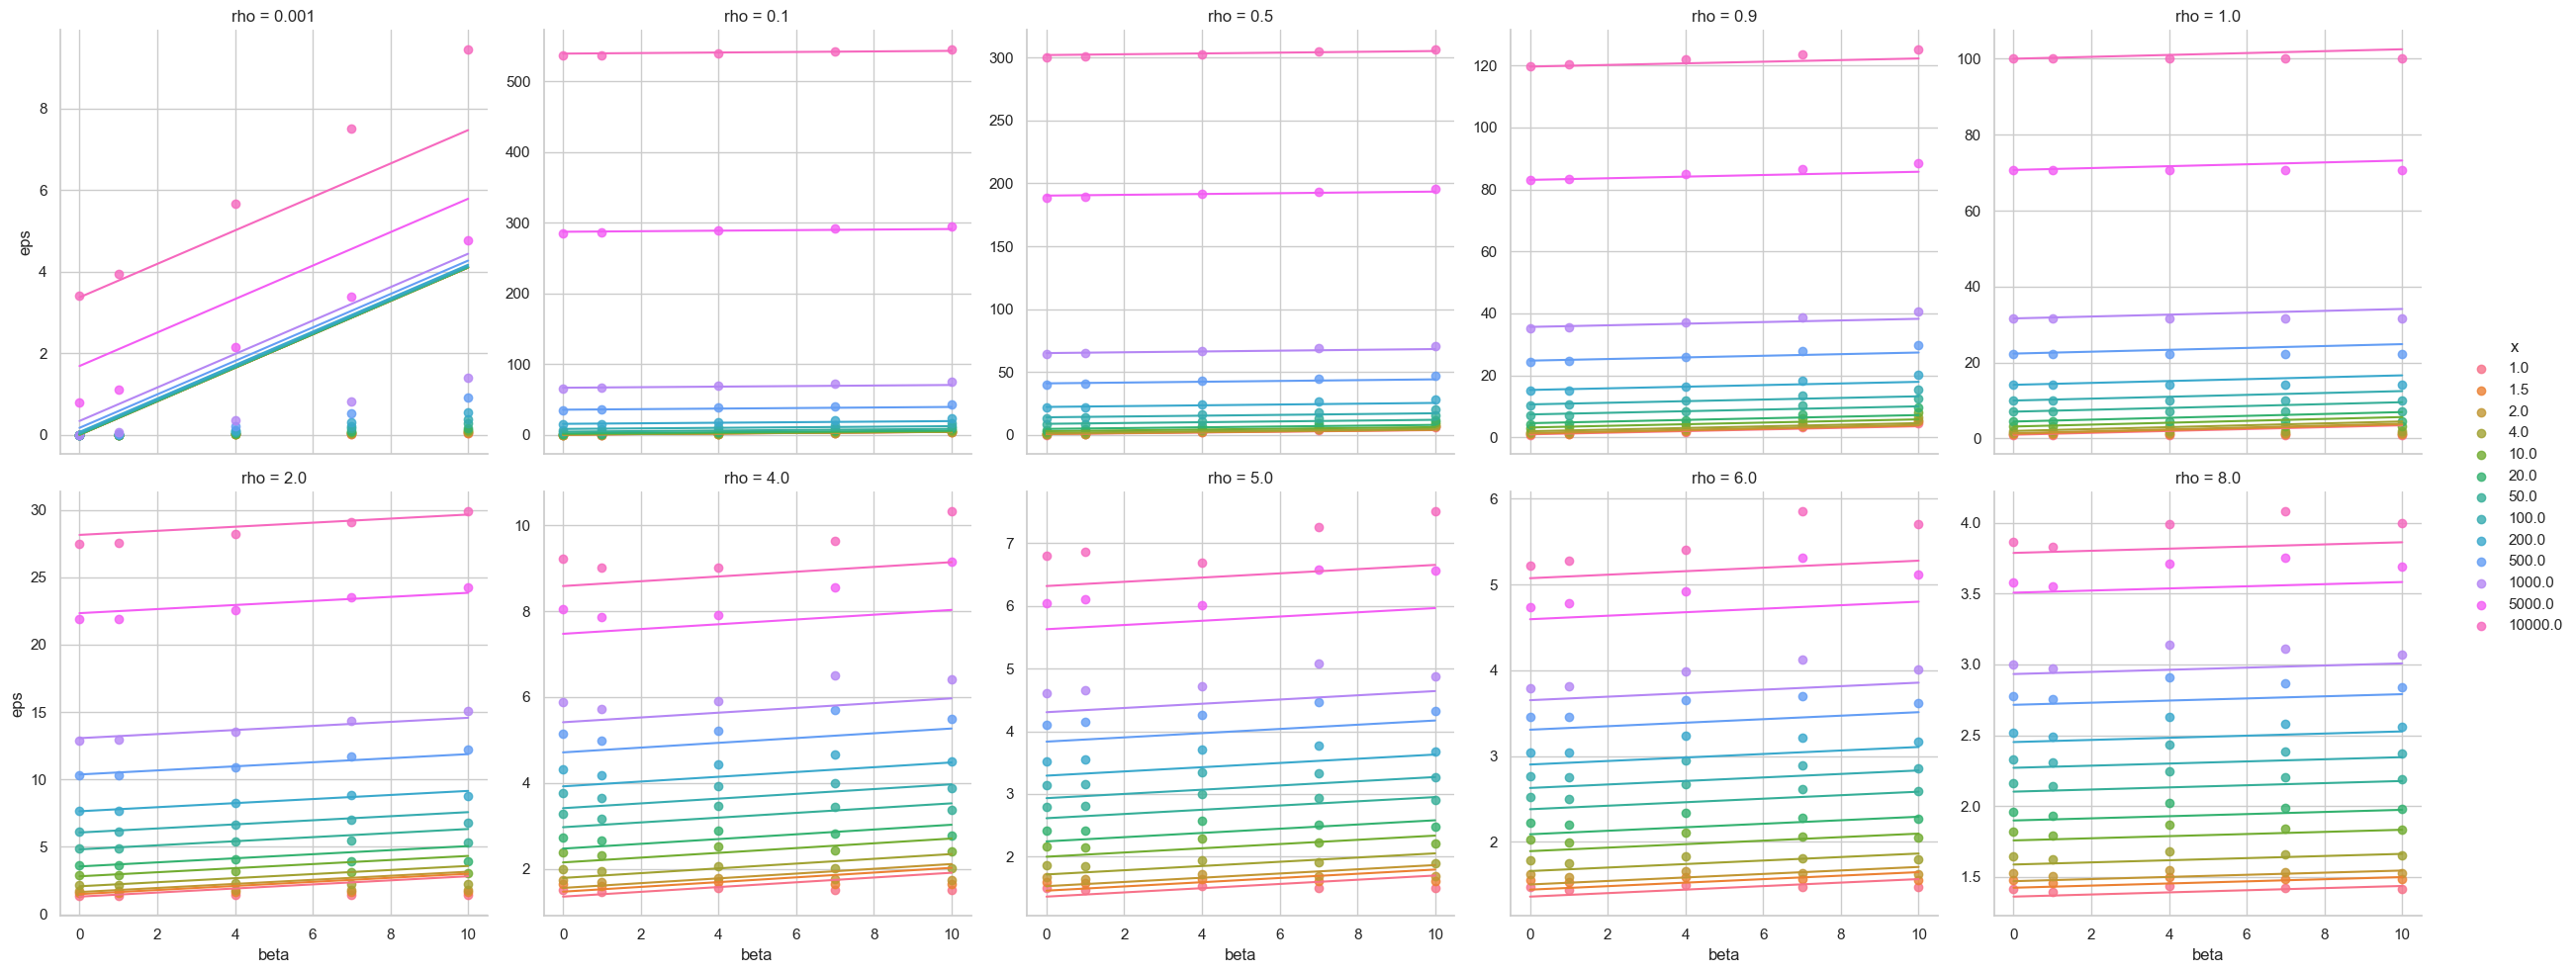

In [156]:
g = sns.lmplot(x = 'beta', y = 'eps',
              col='rho', hue='x',
              data = df,
              fit_reg=False,
              col_wrap=5,
              facet_kws=dict(sharey=False))

#g = sns.FacetGrid(df, hue='beta', col='rho')
#g.map(plt.scatter, "x", "eps")

def my_fit(*args, **kwargs):
    x = args[2]
    rho = args[3]
    beta = args[0]
    y = func(pd.DataFrame({'x': x, 'rho':rho, 'beta': beta}), *func_params)
    kwargs['marker'] = None
    return plt.plot(beta, y, **kwargs)

g.map(my_fit, 'beta', 'eps', 'x' , 'rho')

#### Integrand K
Potentially probematic is the behaviour for $r \rightarrow 0$ of the term $(r+\epsilon)^{-\beta}$.

Text(0, 0.5, '$\\sin(x \\cdot (r+\\epsilon)^{-\\rho} \\cdot \\sin(\\pi\\rho) + \\pi\\beta)$')

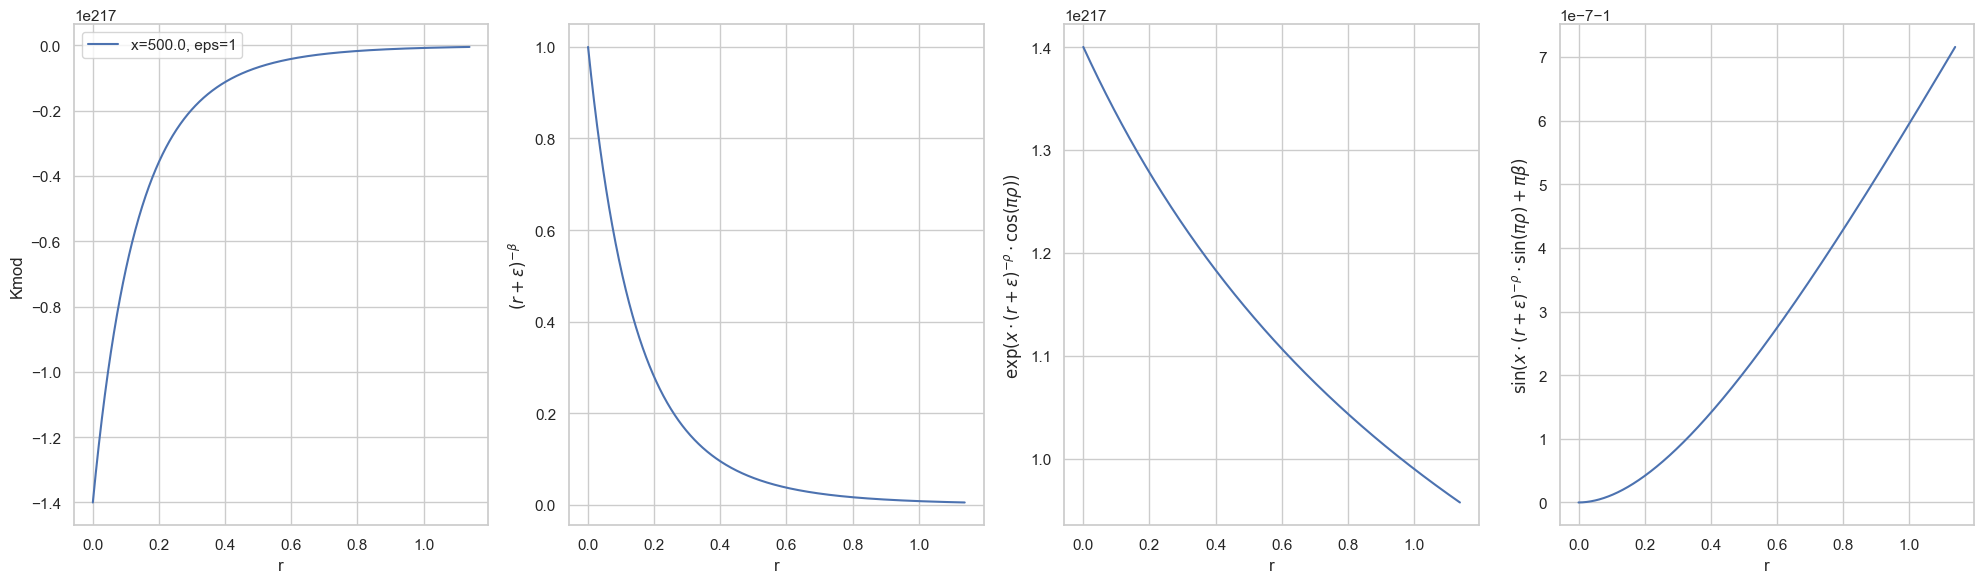

In [157]:
rho = 0.001
beta = 7
x = 500.

fig, axes = plt.subplots(1, 4, figsize=(4*5, 6), tight_layout=True)

eps = 1.
r = np.linspace(0, 1 + np.power(1e-6, 1./beta), 1_000)
y1 = Kmod(eps, rho, beta, x, r)
y2 = np.power(r+eps, -beta)

r_rho = np.power(r+eps, -rho)
y3 = np.exp(x * r_rho * np.cos(np.pi*rho))
y4 = np.sin(x * r_rho * np.sin(np.pi * rho) + np.pi * beta)

axes[0].plot(r, y1, label=f"x={x}, eps={1}")
axes[0].set_xlabel("r")
axes[0].set_ylabel("Kmod")
axes[0].legend()

axes[1].plot(r, y2)
axes[1].set_xlabel("r")
axes[1].set_ylabel(r"$(r+\epsilon)^{-\beta}$")

axes[2].plot(r, y3)
axes[2].set_xlabel("r")
axes[2].set_ylabel(r"$\exp(x \cdot (r+\epsilon)^{-\rho} \cdot \cos(\pi\rho))$")

axes[3].plot(r, y4)
axes[3].set_xlabel("r")
axes[3].set_ylabel(r"$\sin(x \cdot (r+\epsilon)^{-\rho} \cdot \sin(\pi\rho) + \pi\beta)$")

In [158]:
rho = 0.001
x = 100.

for beta in range(9):
    y1 = Wright_Series_MPMATH(rho, beta, x, steps=[2000], method='s')
    for eps in range(1, 10):
        y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=eps)
        print(f"beta={beta} and eps={eps} with precision {y2/y1-1}")
    print("\n")

beta=0 and eps=1 with precision -7.5474841118941277812E-14
beta=0 and eps=2 with precision -2.2788531891875744156E-13
beta=0 and eps=3 with precision -7.4533640723731990965E-13
beta=0 and eps=4 with precision -2.3417047660562206358E-12
beta=0 and eps=5 with precision -7.2000077044716216841E-12
beta=0 and eps=6 with precision -1.7210266525230087827E-11
beta=0 and eps=7 with precision -7.0092322467709008114E-11
beta=0 and eps=8 with precision -2.5053275055794905005E-10
beta=0 and eps=9 with precision -6.9839903979494673573E-10


beta=1 and eps=1 with precision 3.4497670392790846100E-13
beta=1 and eps=2 with precision -1.5004434801286874179E-14
beta=1 and eps=3 with precision -2.0963226034893204380E-14
beta=1 and eps=4 with precision -5.8468564225497374892E-14
beta=1 and eps=5 with precision -1.5065458104125684091E-13
beta=1 and eps=6 with precision -3.3818127030021179896E-13
beta=1 and eps=7 with precision -1.0244938993087351377E-12
beta=1 and eps=8 with precision -3.0620502378318173627E

Starting with $\beta >= 2$, setting $\epsilon = 2$ instead of $1$ is beneficial. For larger $\rho$, this starts earlier.

#### Look at K and P at the same time

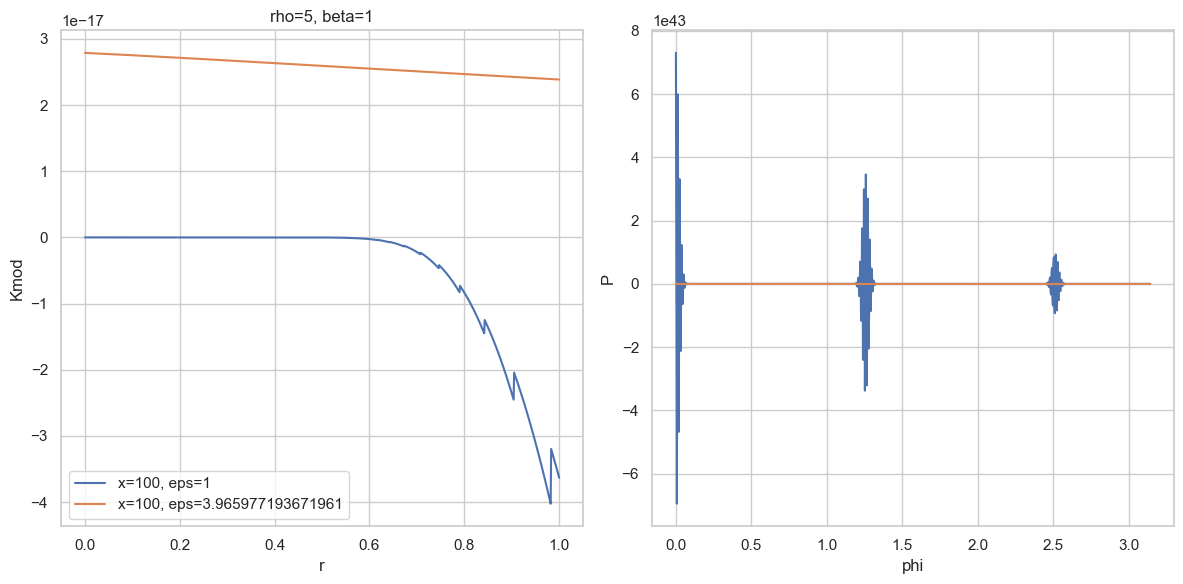

In [178]:
# look at special case
rho = 5 #0.001
beta = 1 #7
x = 100 #500.

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

eps = 1.
r = np.linspace(0, 1 + np.power(1e-6, 1./beta), 1_000)
y1 = Kmod(eps, rho, beta, x, r)
phi = np.linspace(0, np.pi, 1_000)
y2 = np.power(eps, 1.-beta) * P(eps, rho, beta, x, phi)
        
# modified eps
eps = eps_select(rho, beta, x)   
y3 = Kmod(eps, rho, beta, x, r)
y4 = np.power(eps, 1.-beta) * P(eps, rho, beta, x, phi)
    
axes[0].plot(r, y1, label=f"x={x}, eps={1}")
axes[0].plot(r, y3, label=f"x={x}, eps={eps}")
axes[1].plot(phi, y2, label=f"rho={x}, eps={1}")
axes[1].plot(phi, y4, label=f"rho={x}, eps={eps}")
axes[0].set_xlabel("r")
axes[0].set_ylabel("Kmod")
#axes[i, 0].set_yscale("log")
axes[0].legend()
axes[0].set_title(f"rho={rho}, beta={beta}")
axes[1].set_xlabel("phi")
axes[1].set_ylabel("P")

fig.tight_layout()
#fig.subplots_adjust()

#fig.suptitle(f'Determin good eps for Kmod and P')

#### Look at several cases for $K$ and $P$ at the same time

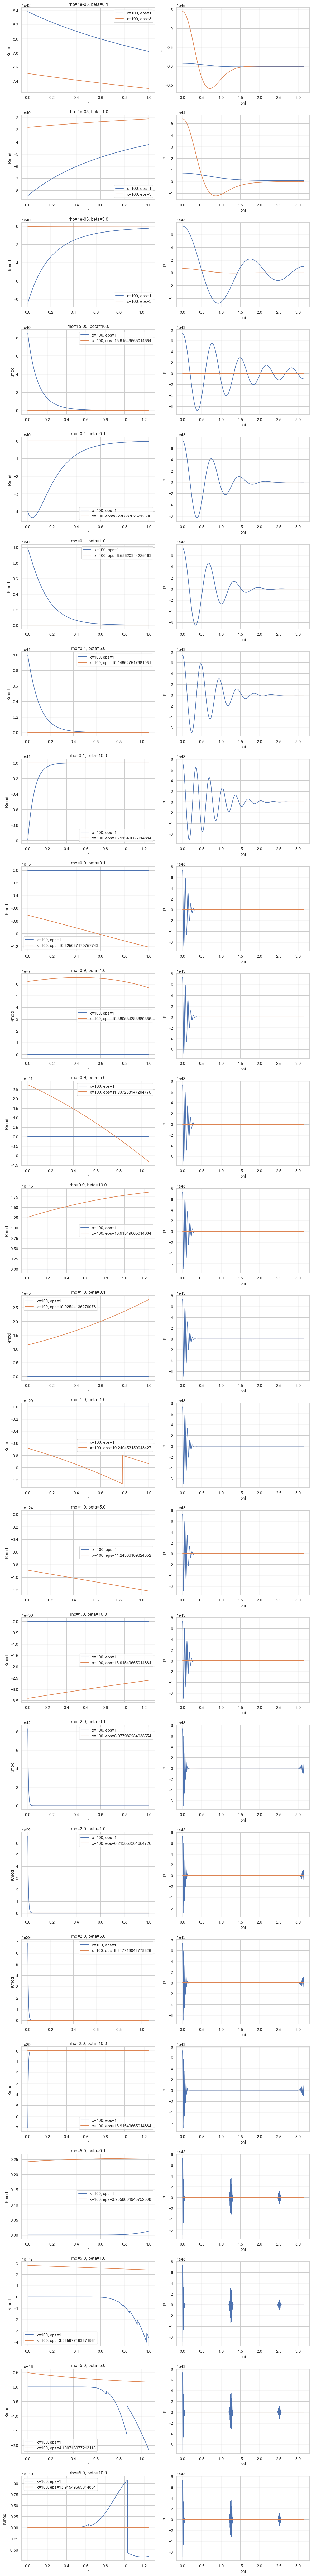

In [179]:
# Which epsilon ?

data_rho = np.array([1e-5, 0.1, 0.9, 1, 2, 5])
data_beta = np.array([0.1, 1, 5, 10])
grid = np.asarray(np.meshgrid(data_rho, data_beta)).T.reshape(-1, 2)

data_x = np.array([100])

fig, axes = plt.subplots(grid.shape[0], 2, figsize=(12, 4 * grid.shape[0] + 2))

for i in range(grid.shape[0]):
    rho, beta = grid[i, :]
    for x in data_x:
        eps = 1.
        r = np.linspace(0, 1 + np.power(1e-6, 1./beta), 1_000)
        y1 = Kmod(eps, rho, beta, x, r)
        phi = np.linspace(0, np.pi, 1_000)
        y2 = np.power(eps, 1.-beta) * P(eps, rho, beta, x, phi)
        
        # modified eps
        eps = eps_select(rho, beta, x)
        
        y3 = Kmod(eps, rho, beta, x, r)
        y4 = np.power(eps, 1.-beta) * P(eps, rho, beta, x, phi)
    
        axes[i, 0].plot(r, y1, label=f"x={x}, eps={1}")
        axes[i, 0].plot(r, y3, label=f"x={x}, eps={eps}")
        axes[i, 1].plot(phi, y2, label=f"rho={x}, eps={1}")
        axes[i, 1].plot(phi, y4, label=f"rho={x}, eps={eps}")
    axes[i, 0].set_xlabel("r")
    axes[i, 0].set_ylabel("Kmod")
    #axes[i, 0].set_yscale("log")
    axes[i, 0].legend()
    axes[i, 0].set_title(f"rho={rho}, beta={beta}")
    axes[i, 1].set_xlabel("phi")
    axes[i, 1].set_ylabel("P")

fig.tight_layout()
#fig.subplots_adjust()

#fig.suptitle(f'Determin good eps for Kmod and P')

In [161]:
# special case rho = 5
rho = 5.
beta = 1
z = 100
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000], method='s')
y2 = Wright_Integral(rho, beta, z, n_laguerre=50, n_legendre=50)
y2/y1-1

-4.6620827248082356842e-14

In [162]:
# special case rho = 0
# This is a hard one for the integral!!!
rho = 0.
beta = 0.5
z = 1
y1 = np.exp(z)*ss.rgamma(beta)
y2 = Wright_Series_MPMATH(rho, beta, z, steps=[100])
y3 = Wright_Integral(rho, beta, z, n_laguerre=100, n_legendre=50)
y4 = Wright_Integral_quad(rho, beta, z)

y2/y1-1, y3/y1-1, y4/y1-1

(1.0008541304756812806e-16, -0.0490587907684068, -2.4313884239290928e-14)

In [163]:
# special case rho = 0
rho = 0.
beta = 1.5
z = 1
y1 = np.exp(z)*ss.rgamma(beta)
y2 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y3 = Wright_Integral(rho, beta, z)
y2/y1-1, y3/y1-1

(1.0008541304756812806e-16, -1.3877787807814457e-14)

In [164]:
# special case rho = 0, beta=1
rho = 0.
beta = 1
z = 1
y1 = np.exp(z)*ss.rgamma(beta)
y2 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y3 = Wright_Integral(rho, beta, z)
y2/y1-1, y3/y1-1

(5.3181810626308501089e-17, -2.9753977059954195e-14)

In [165]:
rho = -0.5
beta = 1.
z = 2
y1 = ss.erfc(-z/2.)
y2 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y3 = Wright_Integral(rho, beta, z, n_laguerre=100, n_legendre=100)
y2/y1-1, y3/y1-1

(4.6790100006327550730e-17, -0.030064949146606623)

In [166]:
rho = -0.5
beta = 0.99
z = 2.
Wright_Series_MPMATH(rho, beta, z), Wright_Integral(rho, beta, z)

(1.8013566827720609548, 0.7782455056728405)

Text(0, 0.5, 'K')

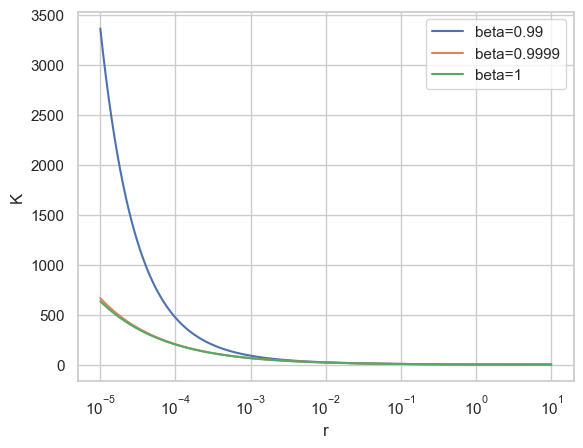

In [167]:
x = np.power(10, np.linspace(-5, 1, 10_000))
y1 = K(-0.5, 0.99, 2., x)
y2 = K(-0.5, 0.9999, 2., x)
y3 = K(-0.5, 1.0, 2., x)
plt.plot(x, y1, label="beta=0.99")
plt.plot(x, y2, label="beta=0.9999")
plt.plot(x, y3, label="beta=1")
plt.legend()
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("r")
plt.ylabel("K")

Text(0, 0.5, 'K')

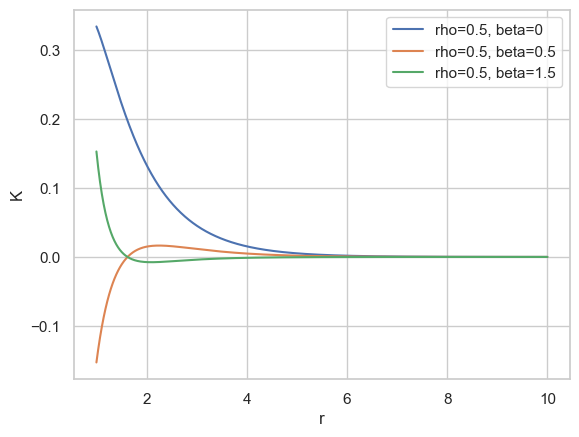

In [168]:
x = np.linspace(1, 10, 1_000)
y1 = K(0.5, 0, 2., x)
plt.plot(x, y1, label="rho=0.5, beta=0")
y2 = K(0.5, 0.5, 2., x)
plt.plot(x, y2, label="rho=0.5, beta=0.5")
y3 = K(0.5, 1.5, 2., x)
plt.plot(x, y3, label="rho=0.5, beta=1.5")
plt.legend()
plt.xlabel("r")
plt.ylabel("K")

Text(0, 0.5, 'P')

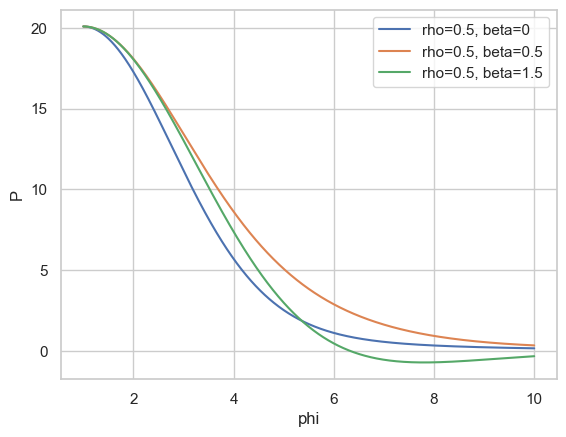

In [169]:
phi = np.linspace(0, np.pi, 1_000)
y1 = P(1, 0.5, 0, 2., phi)
plt.plot(x, y1, label="rho=0.5, beta=0")
y2 = P(1, 0.5, 0.5, 2., phi)
plt.plot(x, y2, label="rho=0.5, beta=0.5")
y3 = P(1, 0.5, 1.5, 2., phi)
plt.plot(x, y3, label="rho=0.5, beta=1.5")
plt.legend()
plt.xlabel("phi")
plt.ylabel("P")

In [170]:
# special case rho=1 => Modified Bessel function of the first kind of real order 
# iv(v, z) = (1/2*z)**v * Phi(rho=1, beta=v+1, 1/4*z**2)
v = -0.5
x = 1.5
[np.power(0.5*x, v) * Wright_Series_MPMATH(1, 1+v, 1/4*x**2),
 np.power(0.5*x, v) * Wright_Integral(1, 1+v, 1/4*x**2),
 ss.iv(v, x)
]

[1.5325243293765750491, 1.5325243293765027, 1.532524329376576]

In [171]:
rho = 0.5
beta = 0.
x = 1.1
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x)
y2/y1-1

-1.1283808953264353944e-13

In [172]:
rho = 2.3
beta = 0.
x = 50.5
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[1000])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=3)
y2/y1-1

3.6046342573683477772e-14

In [173]:
rho = 0.1
beta = 2
x = 100
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y2/y1-1

0.000065798802950041570693

In [174]:
rho = 1
beta = 0
x = 100
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y2/y1-1

-1.5145713967658260696e-14

Text(0.5, 0.98, 'K and P for x=100.0 and eps=8.236883025212506')

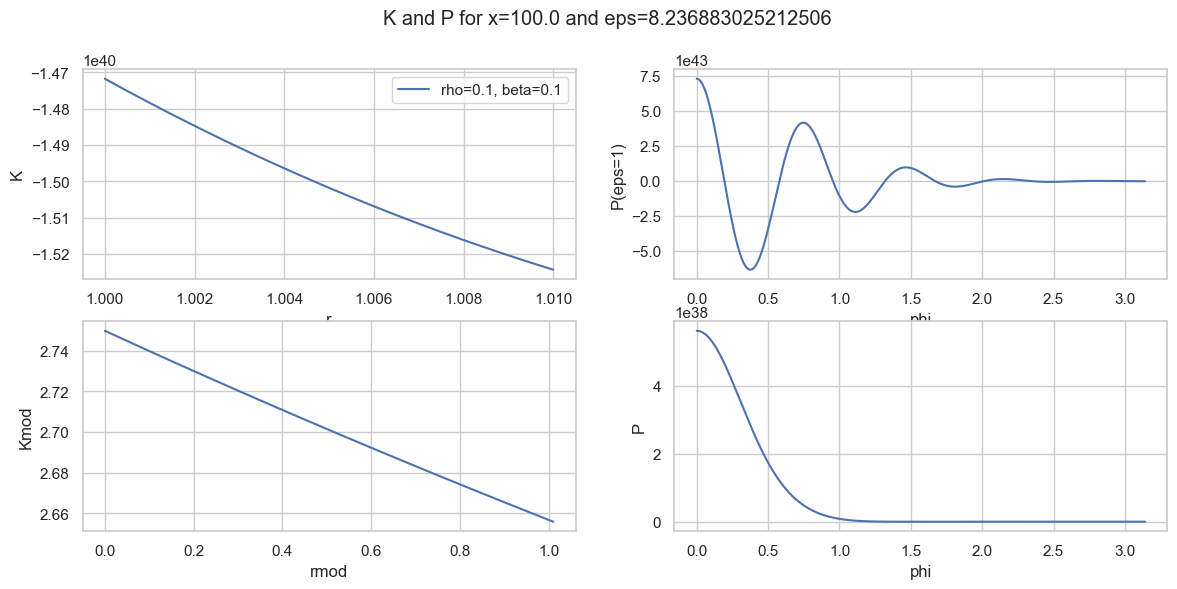

In [176]:
rho = 0.1
beta = 0.1
x = 100.

eps = eps_select(rho, beta, x)

r = np.linspace(1, 1.01, 1_000)
y1 = K(rho, beta, x, r)

r2 = np.linspace(0, 1.01, 1_000)
y2 = Kmod(eps, rho, beta, z, r2)

phi = np.linspace(0, np.pi, 1_000)
y3 = P(1, rho, beta, x, phi)
y4 = P(eps, rho, beta, x, phi)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6))
ax1.plot(r, y1, label=f"rho={rho}, beta={beta}")
ax1.legend()
ax1.set(xlabel="r", ylabel="K")
ax3.plot(r2, y2, label=f"rho={rho}, beta={beta}")
ax3.set(xlabel="rmod", ylabel="Kmod")

ax2.plot(phi, y3, label=f"rho={rho}, beta={beta}")
ax2.set(xlabel="phi", ylabel="P(eps=1)")
ax4.plot(phi, y4, label=f"rho={rho}, beta={beta}")
ax4.set(xlabel="phi", ylabel="P")
fig.suptitle(f'K and P for x={x} and eps={eps}')

In [59]:
fixed_laguerre(lambda r: Kmod(eps, rho, beta, x, r), n=50)[0], \
np.power(eps, 1.-beta) * fixed_quad(lambda phi: P(eps, rho, beta, x, phi), 0, np.pi, n=50)[0]

(6.496749014286437e+31, 1.5417289007523538e+39)

In [60]:
fixed_quad(lambda phi: P(1, rho, beta, x, phi), 0, np.pi, n=100), \
integrate.quad(lambda phi: P(1, rho, beta, x, phi), 0, np.pi, limit=1000, )

((5.1091032367569883e+39, None),
 (5.1091032367250945e+39, 4.727212154768601e+29))

Text(0, 0.5, '$\\Phi(2, 0, x)$')

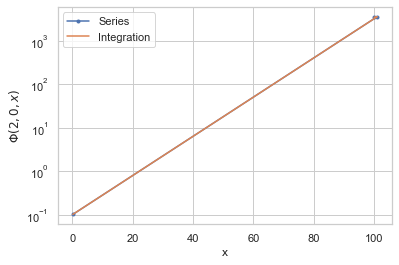

In [61]:
rho = 2.
beta = 0
x = [0.1, 101, 100]
y1 = np.array([Wright_Series_MPMATH(rho, beta, z, nstep=[100]) for z in x])
y2 = np.array([Wright_Integral(rho, beta, z) for z in x])

plt.plot(x, y1, '.-', label="Series")
plt.plot(x, y2, '-', label="Integration")
plt.yscale('log')
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\Phi(2, 0, x)$")

In [62]:
rho, beta = 10, 10
x = np.array([1, 2, 10, 100, 500])
y1 = np.array([Wright_Series_MPMATH(rho, beta, z, nstep=[100]) for z in x])
y2 = np.array([Wright_Integral(rho, beta, z) for z in x])
y2/y1 - 1

array([-1.9208767538278319342e-14, -1.9274265207957705370e-14,
       -1.8722444418645210057e-14, -1.8930850946086499875e-14,
       -1.9310660519635328147e-14], dtype=object)

In [63]:
z = 2
y1 = Wright_Series_MPMATH(rho, beta, z, nstep=[1000])
y2 = Wright_Integral(rho, beta, z, n_legendre=50)


eps = 2*np.power(z, 1/rho)
K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=50)
P_int = fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=50)
res = 1./np.pi * (K_int[0] + np.power(eps, 1.-beta) * P_int[0])
y2/y1 - 1, res/y1 - 1

(-1.9274265207957705370e-14, -4.0129497726919868134e-12)

Text(0.5, 0.98, 'K and P for x=1 and eps=13.91549665014884')

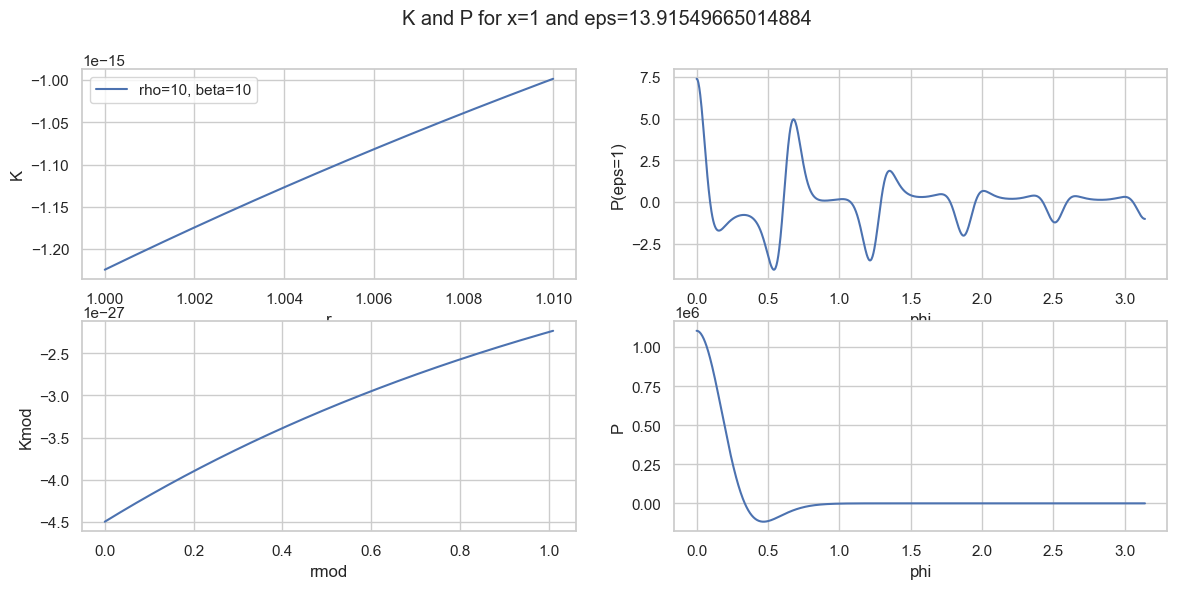

In [181]:
rho = 10
beta = 10
x = 1

eps = eps_select(rho, beta, x)

r = np.linspace(1, 1.01, 1_000)
y1 = K(rho, beta, x, r)

r2 = np.linspace(0, 1.01, 1_000)
y2 = Kmod(eps, rho, beta, z, r2)

phi = np.linspace(0, np.pi, 1_000)
y3 = P(1, rho, beta, x, phi)
y4 = P(eps, rho, beta, x, phi)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6))
ax1.plot(r, y1, label=f"rho={rho}, beta={beta}")
ax1.legend()
ax1.set(xlabel="r", ylabel="K")
ax3.plot(r2, y2, label=f"rho={rho}, beta={beta}")
ax3.set(xlabel="rmod", ylabel="Kmod")

ax2.plot(phi, y3, label=f"rho={rho}, beta={beta}")
ax2.set(xlabel="phi", ylabel="P(eps=1)")
ax4.plot(phi, y4, label=f"rho={rho}, beta={beta}")
ax4.set(xlabel="phi", ylabel="P")
fig.suptitle(f'K and P for x={x} and eps={eps}')

In [65]:
rho = 0.1
beta = 10.
x = 2.1
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y2/y1-1

-1.8437624507933268042e-14

Text(0.5, 0.98, 'K and P for x=2.1 and eps=13.91549665014884')

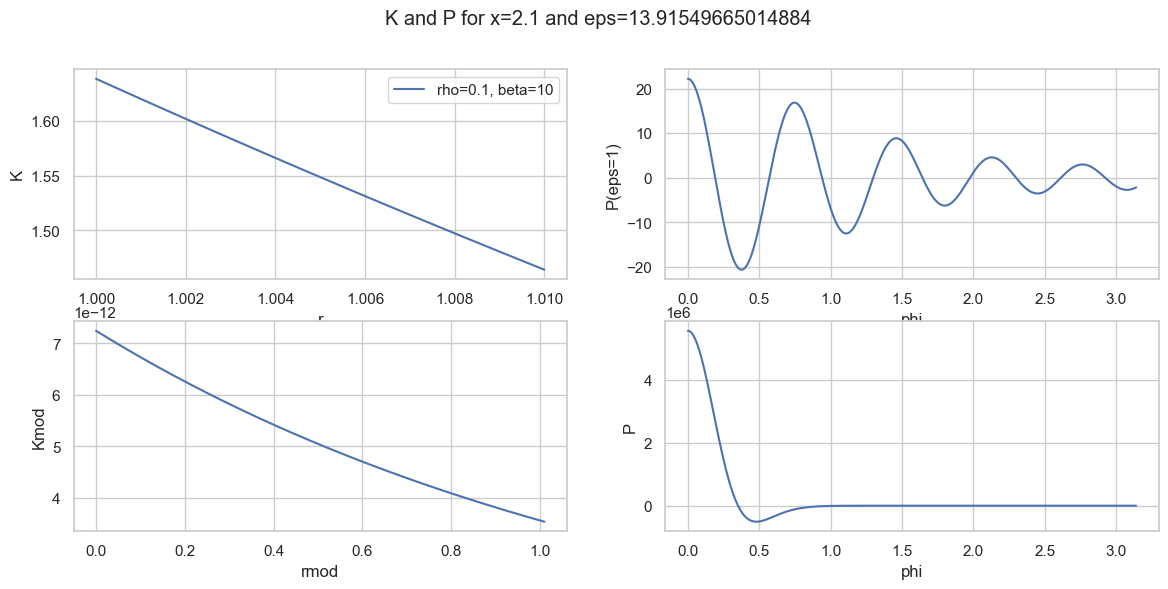

In [177]:
rho = 0.1
beta = 10
x = 2.1

eps = eps_select(rho, beta, x)

r = np.linspace(1, 1.01, 1_000)
y1 = K(rho, beta, x, r)

r2 = np.linspace(0, 1.01, 1_000)
y2 = Kmod(eps, rho, beta, z, r2)

phi = np.linspace(0, np.pi, 1_000)
y3 = P(1, rho, beta, x, phi)
y4 = P(eps, rho, beta, x, phi)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6))
ax1.plot(r, y1, label=f"rho={rho}, beta={beta}")
ax1.legend()
ax1.set(xlabel="r", ylabel="K")
ax3.plot(r2, y2, label=f"rho={rho}, beta={beta}")
ax3.set(xlabel="rmod", ylabel="Kmod")

ax2.plot(phi, y3, label=f"rho={rho}, beta={beta}")
ax2.set(xlabel="phi", ylabel="P(eps=1)")
ax4.plot(phi, y4, label=f"rho={rho}, beta={beta}")
ax4.set(xlabel="phi", ylabel="P")
fig.suptitle(f'K and P for x={x} and eps={eps}')

/var/folders/1c/ynyjslg54654183kt57yfsdw0000gn/T/ipykernel_56174/3775859768.py:24: RuntimeWarning: overflow encountered in exp
  np.exp(eps*np.cos(phi) + x * eps_rho * np.cos(rho*phi))


(3.7622588069752322333e+31,
 3.76225877893833e+31,
 -7.4521460653801237196e-9,
 2.3264286557709039013e-11)

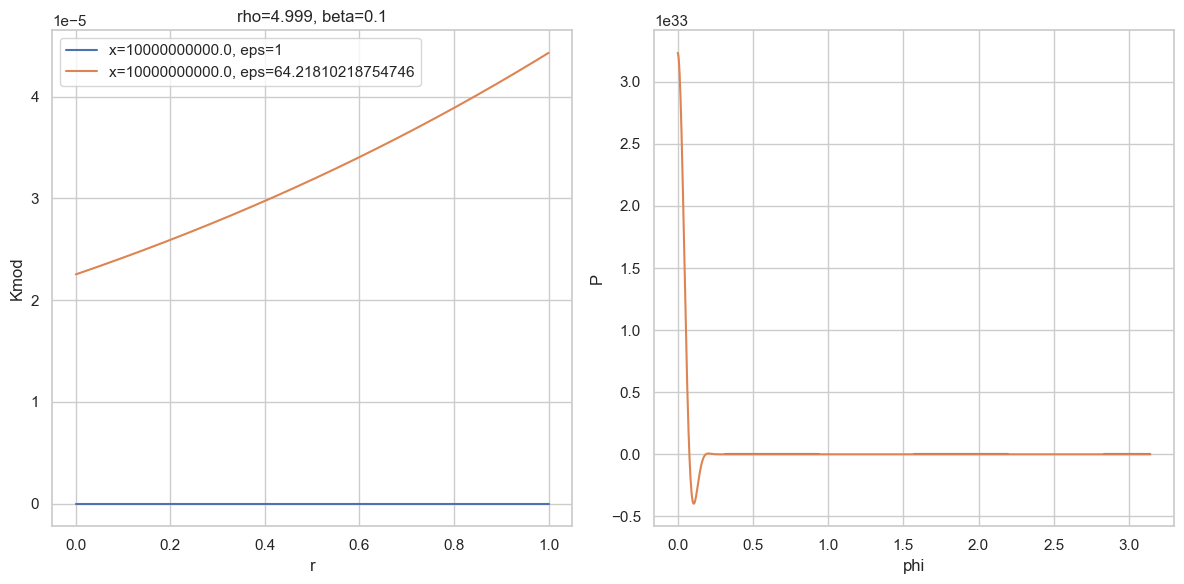

In [180]:
# look at special case
rho = 4.999
beta = 0.1
x = 1e10

fig, axes = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

eps = 1.
r = np.linspace(0, 1 + np.power(1e-6, 1./beta), 1_000)
y1 = Kmod(eps, rho, beta, x, r)
phi = np.linspace(0, np.pi, 1_000)
y2 = np.power(eps, 1.-beta) * P(eps, rho, beta, x, phi)
        
# modified eps
eps = eps_select(rho, beta, x)   
y3 = Kmod(eps, rho, beta, x, r)
y4 = np.power(eps, 1.-beta) * P(eps, rho, beta, x, phi)
    
axes[0].plot(r, y1, label=f"x={x}, eps={1}")
axes[0].plot(r, y3, label=f"x={x}, eps={eps}")
axes[1].plot(phi, y2, label=f"rho={x}, eps={1}")
axes[1].plot(phi, y4, label=f"rho={x}, eps={eps}")
axes[0].set_xlabel("r")
axes[0].set_ylabel("Kmod")
#axes[i, 0].set_yscale("log")
axes[0].legend()
axes[0].set_title(f"rho={rho}, beta={beta}")
axes[1].set_xlabel("phi")
axes[1].set_ylabel("P")

y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=eps)
y3 = Wright_Asymptotic(rho, beta, x)
y1, y2, y2/y1-1, y3/y1-1

In [68]:
rho = 1
beta = 10
x = 1000
np.power(rho*x, 1/(1+rho))
y1 = float(Wright_Series_MPMATH(rho, beta, x, steps=[2000], dps=50))
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y3 = Wright_Asymptotic(rho, beta, x)
y2/y1-1, y3/y1-1

(-3.47499806707674e-14, 2.773311231107911e-06)

In [69]:
rho = 1
beta = 100
x = 100_000
np.power(rho*x, 1/(1+rho))
y1 = float(Wright_Series_MPMATH(rho, beta, x, steps=[2000], dps=50))
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=100_000)
y3 = Wright_Asymptotic(rho, beta, x)
y2/y1-1, y3/y1-1

/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(nan, 372436.10590366233)

In [70]:
K(rho, beta, x, 5.)

0.0

### 2.6. Taylor Series for large rho and large z<a id="series_rho_large"></a>
[back to TOC](#toc)

For $\rho >= 1$ we can use a Stirling approximation to find the largest term in $k$.

See:
- Dunn, P.K., Smyth, G.K. Series evaluation of Tweedie exponential dispersion model densities. Stat Comput 15, 267–280 (2005). https://doi.org/10.1007/s11222-005-4070-y

In [72]:
def Wright_large_rho(rho, beta, z, n=20):
    k_max = int(np.power(np.power(1.*rho, -rho) * z, 1/(1+rho)))
    #print(k_max)
    k_start = max(0, k_max - n//2)
    
    res = 0
    lnz = np.log(z)
    max_exponent = max(0, k_max * lnz - ss.loggamma(k_max + 1) - ss.loggamma(rho * k_max + beta));
    for k in range(k_start, k_start + n):
        exponent = k * lnz - ss.loggamma(k+1) - ss.loggamma(rho*k+beta) - max_exponent
        #print(k, " ", exponent)
        #print(k, " ", np.exp(exponent))
        res += np.exp(exponent)
    return res

In [8]:
rho = 10
beta = 10.3
z = 1E20
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1_000], method='r')
y2 = Wright_large_rho(rho, beta, z)
y3 = Wright_Series(rho, beta, z, nstop=5)
y4 = Wright_Asymptotic(rho, beta, z)
y1, y2/y1-1, y3/y1-1, y4/y1-1

(13105081926519195809.,
 7.9219242588870163180e-14,
 -0.99983781142514353881,
 -3.2676784069786812267e-7)

In [172]:
rho = 10
beta = 100
z = 1e20
order = int(np.fmin(np.log10(z) - 5 + beta/10, 30))
print(f"order={order}")
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1_000], method='r')
y2 = Wright_large_rho(rho, beta, z, n=order)
y1, y2/y1-1

order=25


(1.8571851438779072711e-156, -1.0494570503957224850e-14)

In [9]:
# Hardest is low rho, start with rho = 5
rho = 5
beta = 0
z = 1e10
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1_000], method='r')
y2 = Wright_large_rho(rho, beta, z, n=20)
y3 = Wright_Asymptotic(rho, beta, z)
y2/y1-1, y3/y1-1

(-1.1719041877700797920e-9, 2.3225026292612600126e-11)

In [15]:
# Hardest is low rho, start with rho = 5
rho = 10.
beta = 0
z = 1e20
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1_000], method='r')
y2 = Wright_large_rho(rho, beta, z, n=20)
y3 = Wright_Asymptotic(rho, beta, z)
y2/y1-1, y3/y1-1

(6.1502955573983393578e-14, 2.3129853414516513097e-7)

In [451]:
%%time
# Grid search for region of convergence, hardest is low rho, start with rho=5
rho = np.array([4, 5., 6, 10])
beta = np.array([0., 5])
x = np.power(10., range(1, 16))
n = np.arange(3, 21) * 2
df = pd.DataFrame(np.asarray(np.meshgrid(rho, beta, x, n)).T.reshape(-1, 4), columns=['rho', 'beta', 'x', 'n'])

df['n'] = df['n'].astype('int')
df['Wright_large_rho'] = 0.
df['MPMATH'] = 0.

for index, row in df.iterrows():
    # Note: itterrows gives back a copy not a view
    # row[..] = does not work
    df.at[index , 'Wright_large_rho'] = Wright_large_rho(row['rho'], row['beta'], row['x'], n=int(row['n']))
    df.at[index , 'MPMATH'] = float(Wright_Series_MPMATH(row['rho'], row['beta'], row['x'], dps=30,
                                                         steps=[200], maxterms=1000, method='s'))

df['rel_error'] = df['Wright_large_rho']/df['MPMATH'] - 1

/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


CPU times: user 1min 46s, sys: 173 ms, total: 1min 46s
Wall time: 1min 46s


In [452]:
with pd.option_context("display.max_rows", 150, "display.float_format", '{:.4g}'.format):
    display(df.query("rho >= 10 and abs(rel_error) > 1e-14").sort_values(by=['rho', 'beta', 'x']))

rho  beta     x  n  Wright_large_rho    MPMATH  rel_error
102   10     0 1e+13  6         4.575e+08 4.575e+08 -2.343e-14
110   10     0 1e+14  6         6.043e+10 6.043e+10 -1.657e-10
118   10     0 1e+15  6         2.502e+13 2.502e+13 -4.003e-07
111   10     5 1e+14  6              9772      9772 -1.119e-12
119   10     5 1e+15  6         1.398e+06 1.398e+06 -7.832e-09

In [453]:
with pd.option_context("display.max_rows", 150, "display.float_format", '{:.4g}'.format):
    display(df.query("5 <= rho < 10 and abs(rel_error) > 1e-11").sort_values(by=['rho', 'beta', 'x']))

rho  beta     x   n  Wright_large_rho    MPMATH  rel_error
34      5     0 1e+05   6         1.989e+04 1.989e+04   -7.9e-09
42      5     0 1e+06   6         3.687e+06 3.687e+06 -4.278e-05
162     5     0 1e+06   8         3.687e+06 3.687e+06   -3.3e-10
50      5     0 1e+07   6         6.818e+09 6.982e+09   -0.02348
170     5     0 1e+07   8         6.982e+09 6.982e+09 -1.756e-05
...   ...   ...   ...  ..               ...       ...        ...
1077    6     5 1e+15  22         9.441e+79 9.441e+79 -1.031e-06
1197    6     5 1e+15  24         9.441e+79 9.441e+79 -1.074e-07
1317    6     5 1e+15  26         9.441e+79 9.441e+79 -9.504e-09
1437    6     5 1e+15  28         9.441e+79 9.441e+79 -7.154e-10
1557    6     5 1e+15  30         9.441e+79 9.441e+79 -4.604e-11

[310 rows x 7 columns]

In [454]:
with pd.option_context("display.max_rows", 150, "display.float_format", '{:.4g}'.format):
    display(df.query("abs(rel_error) <= 1e-12").groupby(['rho', 'beta', 'x']).agg({'n': 'min'}))

n
rho beta x        
4   0    10      6
         100     6
         1000    8
         1e+04  10
         1e+05  12
         1e+06  16
         1e+07  20
         1e+08  28
         1e+09  36
    5    10      6
         100     6
         1000    6
         1e+04   8
         1e+05  10
         1e+06  14
         1e+07  20
         1e+08  26
         1e+09  34
5   0    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   8
         1e+06  10
         1e+07  12
         1e+08  16
         1e+09  20
         1e+10  24
         1e+11  30
         1e+12  34
         1e+13  40
    5    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   8
         1e+06   8
         1e+07  12
         1e+08  14
         1e+09  18
         1e+10  24
         1e+11  28
         1e+12  32
         1e+13  40
6   0    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   6
         1e+06   8
         1e+07   8
         1e+08  10
         1e+09  12
         1e+10  14
         1e+11  18
         1e+12  22
         1e+13  26
         1e+14  30
         1e+15  36
    5    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   6
         1e+06   6
         1e+07   8
         1e+08  10
         1e+09  12
         1e+10  14
         1e+11  18
         1e+12  20
         1e+13  24
         1e+14  28
         1e+15  34
10  0    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   6
         1e+06   6
         1e+07   6
         1e+08   6
         1e+09   6
         1e+10   6
         1e+11   6
         1e+12   6
         1e+13   6
         1e+14   8
         1e+15   8
    5    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   6
         1e+06   6
         1e+07   6
         1e+08   6
         1e+09   6
         1e+10   6
         1e+11   6
         1e+12   6
         1e+13   6
         1e+14   8
         1e+15   8

## 7. Check Precision on Data Grid <a id="grid"></a>
[back to TOC](#toc)

In [362]:
rho = 1.8
beta = 100
z = 1e5
y1 = float(Wright_Series_MPMATH(rho, beta, z, dps=50, steps=[1000], maxterms=2000, method='s'))
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=40)
y3 = Wright_Asymptotic(rho, beta, z, order=8)
y4 = Wright_Integral(rho, beta, z)
y5 = Wright_small_rho(rho, beta, z)
y6 = Wright_large_rho(rho, beta, z)

{'Phi':y1,
 'Z': (rho*z)**(1/(1+rho)),
 'Z_limit': 14 + beta**2 / (2 * (1 + rho)),
 'eps_select': eps_select(rho, beta, z),
 'precision Series': y2/y1-1,
 'precision Asympt': y3/y1-1,
 'precision Integral': y4/y1-1,
 'precision small rho': y5/y1-1,
 'precision large rho': y6/y1-1,
}

/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


{'Phi': 2.7844296176636242e-148,
 'Z': 75.31527003270547,
 'Z_limit': 1799.7142857142858,
 'eps_select': 114.76157527896652,
 'precision Series': -4.588940338834391e-10,
 'precision Asympt': 1.1640425329444341e+17,
 'precision Integral': -1.7853196698780494e-10,
 'precision small rho': inf,
 'precision large rho': -0.9999619112654368}

In [282]:
A = [0.41037, 0.30833, 6.9952, 18.382, -2.8566, 2.1122]
(A[0] * beta * np.exp(-0.5*rho)
 + np.exp(A[1] + 1/(1+rho) * np.log(z) - A[2] * np.exp(-A[3]*rho) + A[4] / (1 + np.exp(A[5]*rho))),
np.power(beta, -beta / (1. - beta)) + 0.1 * beta)

(75.72552478146449, 114.76157527896652)

In [278]:
beta = 100
z = 1000
0.1 * beta * (1 + 0.5*np.log(1+0.001*z))

13.465735902799727

In [73]:
rho = 1
beta = 10
z = 1000
y1 = float(Wright_Series_MPMATH(rho, beta, z, dps=50, steps=[1000], maxterms=2000, method='s'))
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=30)
y3 = Wright_Asymptotic(rho, beta, z, order=7)
y4 = Wright_Integral(rho, beta, z, eps=30)
y5 = Wright_small_rho(rho, beta, z)
y6 = Wright_large_rho(rho, beta, z)

{'Phi':y1,
 'Z': (rho*z)**(1/(1+rho)),
 'Z_limit': 15 + beta**2 / (10 * (1 + rho)),
 'eps_select': eps_select(rho, beta, z),
 'precision Series': y2/y1-1,
 'precision Asympt': y3/y1-1,
 'precision Integral': y4/y1-1,
 'precision small rho': y5/y1-1,
 'precision large rho': y6/y1-1,
}

/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


{'Phi': 2446819552254.583,
 'Z': 31.622776601683793,
 'Z_limit': 20.0,
 'eps_select': 34.11353940392128,
 'precision Series': -0.27494552817797435,
 'precision Asympt': -6.897911397629741e-08,
 'precision Integral': -9.43689570931383e-14,
 'precision small rho': inf,
 'precision large rho': -0.04148817263384408}

In [74]:
rho = 1
beta = 100
z = 100_000
y1 = float(Wright_Series_MPMATH(rho, beta, z, dps=50, steps=[1000], maxterms=2000, method='s'))
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=30)
y3 = Wright_Asymptotic(rho, beta, z, order=7)
y4 = Wright_Integral(rho, beta, z, eps=30)
y5 = Wright_small_rho(rho, beta, z)
y6 = Wright_large_rho(rho, beta, z)

{'Phi':y1,
 'Z': (rho*z)**(1/(1+rho)),
 'Z_limit': 15 + beta**2 / (10 * (1 + rho)),
 'eps_select': eps_select(rho, beta, z),
 'precision Series': y2/y1-1,
 'precision Asympt': y3/y1-1,
 'precision Integral': y4/y1-1,
 'precision small rho': y5/y1-1,
 'precision large rho': y6/y1-1,
}

/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


{'Phi': 1.0269334596230763e+22,
 'Z': 316.22776601683796,
 'Z_limit': 515.0,
 'eps_select': 100,
 'precision Series': -1.0,
 'precision Asympt': -382299.31505776744,
 'precision Integral': nan,
 'precision small rho': inf,
 'precision large rho': -0.9971996509519786}

In [75]:
eps = 1e-6
data_rho = np.array([eps, 0.1, 0.5, 1-eps, 1, 2, 5, 10, 100])
data_beta = np.array([eps, 0.5, 1-eps, 1, 2, 5, 10, 100])
data_z = np.array([eps, 0.1, 0.5, 1-eps, 1, 2, 5, 10, 100, 500])

grid = np.asarray(np.meshgrid(data_rho, data_beta, data_z)).T.reshape(-1, 3)

# add manually
grid = np.concatenate((grid,
                      [[2, 1, 1000],
                       [5, 1, 1000],
                       [10, 1, 1000]]))
grid.shape

(723, 3)

In [76]:
%%time
#rgrid_MPMATH = [Wright_Series_MPMATH(rho, beta, z, dps=40, steps=[200], maxterms=1000, method='s') \
#                for rho, beta, z in grid]
rgrid_MPMATH = []
for i in range(grid.shape[0]):
    rho, beta, z = grid[i, :]
    if z >= 50 and rho < 10:
        steps = 1000
        maxterms = 2000
    else:
        steps = 100
        maxterms = 1000

    rgrid_MPMATH.append(Wright_Series_MPMATH(rho, beta, z, dps=40,
                                             steps=[steps], maxterms=maxterms, method='s'))

rgrid_MPMATH = np.asarray(rgrid_MPMATH)

CPU times: user 59.9 s, sys: 408 ms, total: 1min
Wall time: 1min


In [77]:
%%time
rgrid_Series18 = np.asarray([Wright_Series(rho, beta, z, nstart=0, nstop=18, tol=0) for rho, beta, z in grid])
rgrid_Series20 = np.asarray([Wright_Series(rho, beta, z, nstart=0, nstop=20, tol=0) for rho, beta, z in grid])
rgrid_Asymptotic = np.asarray([Wright_Asymptotic(rho, beta, z, order=6) for rho, beta, z in grid])
rgrid_Integral = np.asarray([Wright_Integral(rho, beta, z) for rho, beta, z in grid])
rgrid_small_rho = np.asarray([Wright_small_rho(rho, beta, z) for rho, beta, z in grid])
rgrid_large_rho = np.asarray([Wright_large_rho(rho, beta, z) for rho, beta, z in grid])

/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: overflow encountered in exp
/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: overflow encountered in double_scalars


CPU times: user 517 ms, sys: 3.37 ms, total: 520 ms
Wall time: 521 ms


/Users/lorentzen/github/python3_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


In [78]:
df = pd.DataFrame(grid, columns=['rho', 'beta', 'z'])

df['MPMATH'] = rgrid_MPMATH
df['Series18'] = rgrid_Series18
df['Series20'] = rgrid_Series20
df['Asympt'] = rgrid_Asymptotic
df['Integral'] = rgrid_Integral
df['small_rho'] = rgrid_small_rho
df['large_rho'] = rgrid_large_rho

df['prec_Series18'] = (df['Series18'] / df['MPMATH'] - 1).astype(np.float).abs()
df['prec_Series20'] = (df['Series20'] / df['MPMATH'] - 1).astype(np.float).abs()
df['prec_Asympt'] = (df['Asympt'] / df['MPMATH'] - 1).astype(np.float).abs()
df['prec_Integral'] = (df['Integral'] / df['MPMATH'] - 1).astype(np.float).abs()
df['prec_small_rho'] = (df['small_rho'] / df['MPMATH'] - 1).astype(np.float).abs()
df['prec_large_rho'] = (df['large_rho'] / df['MPMATH'] - 1).astype(np.float).abs()

### Taylor Series

In [79]:
# worst precision of series for z <= 1
idx = df.loc[(df['z'] <= 1), 'prec_Series18'].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                         100
z                                                              1
MPMATH            2.912653546540608349972994089760195499317e-156
Series18                                            2.91265e-156
Series20                                            2.91265e-156
Asympt                                                       inf
Integral                                            2.91265e-156
small_rho                                           2.91265e-156
large_rho                                           2.91265e-156
prec_Series18                                        4.44747e-14
prec_Series20                                        4.44747e-14
prec_Asympt                                                  inf
prec_Integral                                        3.77921e-14
prec_small_rho                                       1.29791e-15
prec_large_rho           

In [80]:
rho = 1e-5
beta = 100
z = 1

y1 = Wright_Series_MPMATH(rho, beta, z, steps=[100])
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=18, tol=0)
y3 = Wright_small_rho(rho, beta, z)
y2/y1 - 1, y3/y1 - 1

(1.2633667508953234926e-14, 8.2287927760291666723e-14)

In [81]:
# worst precision of series for z <= 1 and rho > 1e-6
idx = df.loc[(df['z'] <= 1) & (df['rho'] > 1e-6), 'prec_Series18'].idxmax()
df.iloc[idx]

rho                                                          0.1
beta                                                         100
z                                                              1
MPMATH            2.014338509398109100293351206148654413321e-156
Series18                                            2.01434e-156
Series20                                            2.01434e-156
Asympt                                              1.63863e+115
Integral                                            2.01434e-156
small_rho                                           2.18886e-156
large_rho                                           2.01434e-156
prec_Series18                                        3.80357e-14
prec_Series20                                        3.80357e-14
prec_Asympt                                         8.13485e+270
prec_Integral                                        3.41592e-14
prec_small_rho                                         0.0866416
prec_large_rho           

In [82]:
#with pd.option_context('display.max_rows', 1000):
#    print(df.loc[(df['z'] <= 1), ['rho', 'beta', 'z', 'MPMATH']].to_numpy())
#with np.printoptions(precision=20, threshold=10_000):
#    with mpmath.workdps(20):
#        df_tmp = df.loc[(df['z'] <= 1), ['rho', 'beta', 'z', 'MPMATH']].copy()
#        df_tmp['MPMATH'] = df_tmp['MPMATH'].astype(np.float64)
#        print(repr(df_tmp.to_numpy()))

In [83]:
# worst precision of series for z <= 2
idx = df.loc[(df['z'] <= 2), 'prec_Series20'].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                       1e-06
z                                                              2
MPMATH            0.00002216721521243239310329838655352902434539
Series18                                             2.21672e-05
Series20                                             2.21672e-05
Asympt                                                4.5413e+27
Integral                                             2.21672e-05
small_rho                                            2.21672e-05
large_rho                                            2.21672e-05
prec_Series18                                        3.94371e-11
prec_Series20                                        4.53408e-13
prec_Asympt                                          2.04866e+32
prec_Integral                                        3.13066e-08
prec_small_rho                                       7.15743e-17
prec_large_rho           

In [84]:
rho = 1e-6
beta = 1e-6
z = 2

y1 = Wright_Series_MPMATH(rho, beta, z, steps=[100])
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=20, tol=0)
y3 = Wright_small_rho(rho, beta, z)
y2/y1 - 1, y3/y1 - 1

(-4.5340767425972429774e-13, -7.1574284042988378651e-17)

In [85]:
# worst precision of series for z <= 5 & rho >= 1
idx = df.loc[(df['z'] <= 5) & (df['rho'] >= 1) , 'prec_Series20'].idxmax()
df.iloc[idx]

rho                                                            1
beta                                                         100
z                                                              5
MPMATH            1.126433863380004396007515798109053161921e-156
Series18                                            1.12643e-156
Series20                                            1.12643e-156
Asympt                                               9.87026e-19
Integral                                            1.12643e-156
small_rho                                           4.69558e-152
large_rho                                           1.12643e-156
prec_Series18                                        2.07203e-15
prec_Series20                                        2.07203e-15
prec_Asympt                                         8.76239e+137
prec_Integral                                        3.29601e-14
prec_small_rho                                           41684.4
prec_large_rho           

### Series small rho

In [86]:
# worst precision of small rho series for rho <= 1e-3 and z <= 100
idx = df.loc[(df['rho'] <= 1e-3) & (df['z'] <= 100), 'prec_small_rho'].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                         100
z                                                            100
MPMATH            2.879020475358926022697194662161724289679e-113
Series18                                            3.62056e-137
Series20                                            1.08433e-135
Asympt                                                       inf
Integral                                            2.87902e-113
small_rho                                           2.87902e-113
large_rho                                           1.96665e-113
prec_Series18                                                  1
prec_Series20                                                  1
prec_Asympt                                                  inf
prec_Integral                                        3.44262e-14
prec_small_rho                                        1.6696e-11
prec_large_rho           

### Series large rho

In [87]:
# worst precision of large rho series for rho >= 1
idx = df.loc[(df['rho'] >= 1), 'prec_large_rho'].idxmax()
df.iloc[idx]

rho                                                            1
beta                                                         100
z                                                            500
MPMATH            1.415608181830990498307985973573740034485e-154
Series18                                            1.41561e-154
Series20                                            1.41561e-154
Asympt                                              8.98056e-107
Integral                                            1.41561e-154
small_rho                                            3.98087e+67
large_rho                                           4.32263e-157
prec_Series18                                        1.35843e-06
prec_Series20                                        6.17762e-08
prec_Asympt                                          6.34396e+47
prec_Integral                                        3.94611e-14
prec_small_rho                                      2.81213e+221
prec_large_rho           

In [88]:
# worst precision of large rho series for rho >= 5
idx = df.loc[(df['rho'] >= 5), 'prec_large_rho'].idxmax()
df.iloc[idx]

rho                                                          10
beta                                                      1e-06
z                                                           100
MPMATH            0.0002765725723362120068937494521631770267046
Series18                                            0.000276573
Series20                                            0.000276573
Asympt                                                 -20.8696
Integral                                            0.000276573
small_rho                                           4.93447e+57
large_rho                                           0.000276573
prec_Series18                                       1.93712e-15
prec_Series20                                       1.93712e-15
prec_Asympt                                             75458.9
prec_Integral                                       3.73395e-10
prec_small_rho                                      1.78415e+61
prec_large_rho                          

In [89]:
rho = 5
beta = 1
z = 1e9
print("Z = {}".format(np.power(rho*z, 1/(1+rho))))
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
print(f"Phi = {y1}")
y2 = Wright_large_rho(rho, beta, z)
y3 = Wright_Asymptotic(rho, beta, z)
y4 = Wright_Integral(rho, beta, z)
y2/y1 - 1, y3/y1 - 1, y4/y1 - 1

Z = 41.351855420001364
Phi = 89731607525854102066


(-1.0231244054281860706e-14,
 2.0591267362229449030e-10,
 2.1401427156196800930e-11)

In [90]:
rho = 10
beta = 1
z = 1e20

y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y2 = Wright_large_rho(rho, beta, z)
y3 = Wright_Asymptotic(rho, beta, z)
y4 = Wright_Integral(rho, beta, z)
y1, y2/y1 - 1, y3/y1 - 1, y4/y1 - 1

(7.4576280919632674035e+36,
 9.5368727021441501712e-15,
 9.5128861940007908207e-7,
 -0.015169941356521301079)

For $\rho >= 10$ the large-rho-series is even better than the asymptotic series.

### Asymptotic Series

In [91]:
# worst precision of asymptotic for z >= 100
idx = df.loc[(df['z'] >= 100), 'prec_Asympt'].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                         100
z                                                            100
MPMATH            2.879020475358926022697194662161724289679e-113
Series18                                            3.62056e-137
Series20                                            1.08433e-135
Asympt                                                       inf
Integral                                            2.87902e-113
small_rho                                           2.87902e-113
large_rho                                           1.96665e-113
prec_Series18                                                  1
prec_Series20                                                  1
prec_Asympt                                                  inf
prec_Integral                                        3.44262e-14
prec_small_rho                                        1.6696e-11
prec_large_rho           

In [92]:
# worst precision of asymptotic for z >= 100 and 0.1 <= rho <= 5
idx = df.loc[(df['z'] >= 500) & (df['rho'] >= 0.1) & (df['rho'] <= 5), 'prec_Asympt'].idxmax()
df.iloc[idx]

rho                                                            5
beta                                                         100
z                                                            500
MPMATH            1.071510336673791611741081962632298914999e-156
Series18                                            1.07151e-156
Series20                                            1.07151e-156
Asympt                                               2.91542e-45
Integral                                            1.07151e-156
small_rho                                            9.95909e+68
large_rho                                           1.07151e-156
prec_Series18                                        1.28258e-15
prec_Series20                                        1.28258e-15
prec_Asympt                                         2.72085e+111
prec_Integral                                        3.43378e-14
prec_small_rho                                      9.29444e+224
prec_large_rho           

In [93]:
rho = 5
beta = 100
z = 500
print("Z = {}".format(np.power(rho*z, 1/(1+rho))))

Z = 3.6840314986403864


In [94]:
# worst precision of asymptotic for z >= 100 & rho + beta <= 0.5
idx = df.loc[(df['z'] >= 500) & (df['rho']<= 0.5) & (df['beta'] <= 0.5), 'prec_Asympt'].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                       1e-06
z                                                            500
MPMATH            7.034033446103676460268167396650062895267e+213
Series18                                             3.98881e+26
Series20                                             3.25316e+29
Asympt                                              5.57942e+230
Integral                                            7.03403e+213
small_rho                                           7.03403e+213
large_rho                                           2.42667e+213
prec_Series18                                                  1
prec_Series20                                                  1
prec_Asympt                                          7.93204e+16
prec_Integral                                        2.69933e-10
prec_small_rho                                       4.43231e-16
prec_large_rho           

In [95]:
rho = 1e-6
beta = 1e-6
z = 500

y1 = Wright_Series_MPMATH(rho, beta, z, dps=40, steps=[500], maxterms=2000, method='s')
y2 = Wright_Asymptotic(rho, beta, z, order=5)
y3 = Wright_small_rho(rho, beta, z)
y4 = Wright_Integral(rho, beta, z)
y2/y1 - 1, y3/y1 - 1, y4/y1 - 1

(-448579052279504.1240256377905184250768176,
 4.432307363698025847022530470366158925976e-16,
 -0.0000000002699330950418051811163929301444261014965)

In [96]:
# worst precision of asymptotic for z >= 100
idx = df.loc[(df['z'] >= 100), 'prec_Asympt'].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                         100
z                                                            100
MPMATH            2.879020475358926022697194662161724289679e-113
Series18                                            3.62056e-137
Series20                                            1.08433e-135
Asympt                                                       inf
Integral                                            2.87902e-113
small_rho                                           2.87902e-113
large_rho                                           1.96665e-113
prec_Series18                                                  1
prec_Series20                                                  1
prec_Asympt                                                  inf
prec_Integral                                        3.44262e-14
prec_small_rho                                        1.6696e-11
prec_large_rho           

### Integral

In [97]:
# worst precision of integral for beta < 50 and z >= 100
idx = df.loc[(df['beta'] <= 50), 'prec_Integral'].idxmax()
df.iloc[idx]

rho                                                         1e-06
beta                                                        1e-06
z                                                           1e-06
MPMATH            0.000001000002577218817838843927401023796398533
Series18                                                    1e-06
Series20                                                    1e-06
Asympt                                                2.78116e+61
Integral                                                    1e-06
small_rho                                                   1e-06
large_rho                                                   1e-06
prec_Series18                                         1.26373e-16
prec_Series20                                         1.26373e-16
prec_Asympt                                           2.78115e+67
prec_Integral                                         9.40402e-08
prec_small_rho                                        1.26373e-16
prec_large

In [98]:
rho = 1e-6
beta = 2.
z = 500.
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000], maxterms=200, method='s')
y2 = Wright_Integral(rho, beta, z, n_legendre=1_000)
y1, y2/y1 - 1

(1.4032954275295532301e+217, -4.5845047813493919678e-13)

In [99]:
eps = np.power(z, 1/(1+rho))
#eps = 20
eps

499.9968927087136

In [100]:
eps = 1
z = 500.
K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=50)
P_int = fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=50)
y2 = 1./np.pi * (K_int[0] + np.power(eps, 1-beta) * P_int[0])
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000], maxterms=1000, method='s')
y1, y2/y1 - 1

(1.4032954275295532301e+217, 0.00012758369126284745588)

In [101]:
eps = 1
rho = 1e-1
beta = 0.1
z = 100.
K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=50)
P_int = fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=50)
y2 = 1./np.pi * (K_int[0] + np.power(eps, 1-beta) * P_int[0])
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y1, y2/y1 - 1

(4.9074755093021763476e+38, -3.9760640874827699883)

In [102]:
rho = 0.5
beta = 10.
z = 500.
Wright_Integral(rho, beta, z, n_legendre=50), Wright_Series_MPMATH(rho, beta, z, steps=[1000])

(5.322458641324036e+35, 5.3224586413241018583e+35)

In [103]:
np.power(z, 1/(1+rho))

62.996052494743644

In [104]:
# worst precision of integral for rho > 1e-6 and z>=2
idx = df.loc[(df['rho'] > 51e-6) & (df['z'] >= 2), 'prec_Integral'].idxmax()
df.iloc[idx]

rho                                                           100
beta                                                        1e-06
z                                                               2
MPMATH            0.000001000000577215008978167397469913343926818
Series18                                                    1e-06
Series20                                                    1e-06
Asympt                                               -3.07854e+06
Integral                                                    1e-06
small_rho                                             5.58373e+12
large_rho                                                   1e-06
prec_Series18                                          2.1631e-16
prec_Series20                                          2.1631e-16
prec_Asympt                                           3.07854e+12
prec_Integral                                         9.38452e-08
prec_small_rho                                        5.58373e+18
prec_large

In [105]:
rho = 100.
beta = 100.
z = 2
Wright_Integral(rho, beta, z, n_legendre=1000), Wright_Series_MPMATH(rho, beta, z, steps=[1000])

(1.0715102881229886e-156, 1.0715102881254669232e-156)

In [106]:
eps = np.power(z, 1/rho)
eps = 20
eps

20

In [107]:
K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=100)
P_int = fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=10)
1./np.pi * (K_int[0] + np.power(eps, 1-beta) * P_int[0]), Wright_Series_MPMATH(rho, beta, z, steps=[1000])

(-4.826648189985485e-122, 1.0715102881254669232e-156)

In [108]:
df[(df['z'] <=2) & (np.abs(df['prec_Series18']) > 1e-14)]

rho        beta         z  \
151  0.000001  100.000000  0.500000   
159  0.100000  100.000000  0.500000   
223  0.000001  100.000000  0.999999   
231  0.100000  100.000000  0.999999   
295  0.000001  100.000000  1.000000   
303  0.100000  100.000000  1.000000   
360  0.000001    0.000001  2.000000   
361  0.000001    0.500000  2.000000   
362  0.000001    0.999999  2.000000   
363  0.000001    1.000000  2.000000   
364  0.000001    2.000000  2.000000   
365  0.000001    5.000000  2.000000   
366  0.000001   10.000000  2.000000   
367  0.000001  100.000000  2.000000   
368  0.100000    0.000001  2.000000   
369  0.100000    0.500000  2.000000   
370  0.100000    0.999999  2.000000   
371  0.100000    1.000000  2.000000   
372  0.100000    2.000000  2.000000   
373  0.100000    5.000000  2.000000   
374  0.100000   10.000000  2.000000   
375  0.100000  100.000000  2.000000   
383  0.500000  100.000000  2.000000   

                                             MPMATH       Series18  \
151  1.766617740447377647406003359758460955454e-156  1.766618e-156   
159  1.469151460530944557177165646484615266997e-156  1.469151e-156   
223  2.912650633901916685459994838965809685530e-156  2.912651e-156   
231  2.014337237944559066153032406495121506025e-156  2.014337e-156   
295  2.912653546540608349972994089760195499317e-156  2.912654e-156   
303  2.014338509398109100293351206148654413321e-156  2.014339e-156   
360  0.00002216721521243239310329838655352902434539   2.216722e-05   
361       4.168844854326239591887808194361726379328   4.168845e+00   
362       7.389060363995040281180224082073815746676   7.389060e+00   
363       7.389064629059430579178797141845769376775   7.389065e+00   
364       7.389049850965976618789167984832322948423   7.389050e+00   
365      0.3078764100583391910797678923611373820890   3.078764e-01   
366  0.00002036216606698719088188296386501926714961   2.036217e-05   
367  7.917376786943299611071614625976311593244e-156  7.917377e-156   
368       1.628958088563662980437045664172694516914   1.628958e+00   
369       5.613880752421059027577502431512021886017   5.613881e+00   
370       7.954508835688431642507608362868265449794   7.954509e+00   
371       7.954511198879110418102354655300477148131   7.954511e+00   
372       6.689820259129364048944111852553778180699   6.689820e+00   
373      0.2316043658955719446297469544883734968393   2.316044e-01   
374  0.00001357573252879098838789527687145445722957   1.357573e-05   
375  3.786615483113074449282244189208026512970e-156  3.786615e-156   
383  1.309007572559849474559850995724187981912e-156  1.309008e-156   

          Series20         Asympt       Integral      small_rho  \
151  1.766618e-156            inf  1.766618e-156  1.766618e-156   
159  1.469151e-156  6.466958e+143  1.469151e-156  1.500409e-156   
223  2.912651e-156            inf  2.912651e-156  2.912651e-156   
231  2.014337e-156  1.638790e+115  2.014337e-156  2.188862e-156   
295  2.912654e-156            inf  2.912654e-156  2.912654e-156   
303  2.014339e-156  1.638635e+115  2.014339e-156  2.188864e-156   
360   2.216722e-05   4.541301e+27   2.216721e-05   2.216722e-05   
361   4.168845e+00   1.610753e+30   4.168845e+00   4.168845e+00   
362   7.389060e+00   2.270165e+33   7.389060e+00   7.389060e+00   
363   7.389065e+00   2.270336e+33   7.389065e+00   7.389065e+00   
364   7.389050e+00   1.766286e+43   7.389050e+00   7.389050e+00   
365   3.078764e-01   7.074230e+64   3.078764e-01   3.078764e-01   
366   2.036217e-05   4.296633e+96   2.036217e-05   2.036217e-05   
367  7.917377e-156            inf  7.917377e-156  7.917377e-156   
368   1.628958e+00  -9.349700e+00   1.628958e+00   1.629775e+00   
369   5.613881e+00   2.454799e+01   5.613881e+00   5.670937e+00   
370   7.954509e+00  -2.859033e+01   7.954509e+00   7.951290e+00   
371   7.954511e+00  -2.859057e+01   7.954511e+00   7.951293e+00   
372   6.689820e+00   9.962647e+03   6.689820e+00   6.660920e+00   
373   2.316044e-01   2.388347e+11   2.316044e-01   2

In [109]:
df[(df['z'] >=1) & (np.abs(df['prec_Series18']) > 1e-14)]

rho        beta       z  \
295  0.000001  100.000000     1.0   
303  0.100000  100.000000     1.0   
360  0.000001    0.000001     2.0   
361  0.000001    0.500000     2.0   
362  0.000001    0.999999     2.0   
..        ...         ...     ...   
686  1.000000   10.000000   500.0   
687  1.000000  100.000000   500.0   
688  2.000000    0.000001   500.0   
689  2.000000    0.500000   500.0   
720  2.000000    1.000000  1000.0   

                                             MPMATH       Series18  \
295  2.912653546540608349972994089760195499317e-156  2.912654e-156   
303  2.014338509398109100293351206148654413321e-156  2.014339e-156   
360  0.00002216721521243239310329838655352902434539   2.216722e-05   
361       4.168844854326239591887808194361726379328   4.168845e+00   
362       7.389060363995040281180224082073815746676   7.389060e+00   
..                                              ...            ...   
686       454308.6292213986445404969728192688995617   2.007631e+05   
687  1.415608181830990498307985973573740034485e-154  1.415606e-154   
688       2313565.628264446320317587583786919889431   2.313566e+06   
689       747360.0162723390279256173686484890885028   7.473600e+05   
720       10513320.79372690808040526682632610146054   1.051332e+07   

          Series20         Asympt       Integral      small_rho  \
295  2.912654e-156            inf  2.912654e-156  2.912654e-156   
303  2.014339e-156  1.638635e+115  2.014339e-156  2.188864e-156   
360   2.216722e-05   4.541301e+27   2.216721e-05   2.216722e-05   
361   4.168845e+00   1.610753e+30   4.168845e+00   4.168845e+00   
362   7.389060e+00   2.270165e+33   7.389060e+00   7.389060e+00   
..             ...            ...            ...            ...   
686   3.069093e+05   4.543271e+05   4.543086e+05  2.401089e+217   
687  1.415608e-154  8.980555e-107  1.415608e-154   3.980869e+67   
688   2.313566e+06   2.313566e+06   2.313566e+06  2.383902e+231   
689   7.473600e+05   7.473600e+05   7.473600e+05 -4.266954e+222   
720   1.051332e+07   1.051332e+07   1.051332e+07           -inf   

         large_rho  prec_Series18  prec_Series20    prec_Asympt  \
295  2.912654e-156   4.447466e-14   4.447466e-14            inf   
303  2.014339e-156   3.803569e-14   3.803569e-14  8.134853e+270   
360   2.216722e-05   3.943710e-11   4.534077e-13   2.048657e+32   
361   4.168845e+00   6.189054e-12   6.425128e-14   3.863786e+29   
362   7.389060e+00   6.188979e-12   6.433648e-14   3.072333e+32   
..             ...            ...            ...            ...   
686   4.458204e+05   5.580908e-01   3.244475e-01   4.058306e-05   
687  4.322631e-157   1.358430e-06   6.177619e-08   6.343955e+47   
688   2.313566e+06   2.397029e-14   1.390271e-15   4.053803e-08   
689   7.473600e+05   1.322613e-14   1.421703e-17   2.546545e-08   
720   1.051332e+07   4.148206e-11   4.925682e-14   2.595894e-09   

     prec_Integral  prec_small_rho  prec_large_rho  
295   3.779214e-14    1.297914e-15    4.411930e-14  
303   3.415918e-14    8.664158e-02    3.790723e-14  
360   3.130661e-08    7.157435e-17    4.540191e-13  
361   9.578290e-14    1.227968e-16    6.425128e-14  
362   2.947795e-14    2.851163e-17    6.445668e-14  
..             ...             ...             ...  
686   2.671207e-14   5.285149e+211    1.868374e-02  
687   3.946114e-14   2.812126e+221    9.969464e-01  
688   1.974353e-14   1.030402e+225    1.792819e-15  
689   1.945687e-14   5.709369e+216    1.231933e-15  
720   2.126396e-14             inf    5.067418e-14  

[148 rows x 16 columns]

### Output for Test

In [ ]:
df_out = df.loc[:, ['rho', 'beta', 'z', 'MPMATH']].copy()
df_out['MPMATH'] = df_out['MPMATH'].astype(np.float)
#pd.w (df_out)